In [2]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#import altair as alt
# need to 'pip install vega' before using renderer
#alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.utils import shuffle
import scipy
import os
from joblib import dump, load
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prfs
# test for Selecting The Best Number Of Components For TSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from varname import varname
%matplotlib inline
#fix random seed
np.random.seed(1)

# Data With Irrelevant Keywords

In [3]:
TRAINING_FILE = "../keyword.csv"
TEST_FILE = "../key_word_test.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
print(df_train.isnull().sum())
df_train.head(5)

Unnamed: 0         0
article_number     0
article_words      0
topic              0
IR_binary          0
key_word_10       62
key_word_20       18
key_word_50        0
key_word_100       0
dtype: int64


Unnamed: 0  article_number  \
0           0               1   
1           1               2   
2           2               3   
3           3               4   
4           4               5   

                                       article_words          topic  \
0  open,absent,cent,cent,cent,stock,inflow,rate,k...  FOREX MARKETS   
1  morn,stead,end,end,day,day,day,patch,patch,pat...  MONEY MARKETS   
2  socc,socc,world,world,recent,law,fifa,fifa,fif...         SPORTS   
3  open,forint,forint,forint,forint,cent,cent,ste...  FOREX MARKETS   
4  morn,complet,weekend,minut,minut,minut,arrow,d...     IRRELEVANT   

   IR_binary                                        key_word_10  \
0      False  stock,rate,defend,bank,bank,bank,bank,bank,dol...   
1      False  day,day,day,bank,year,dollar,dollar,deal,deal,...   
2      False  world,world,stat,stat,stat,stat,year,releas,re...   
3      False  play,bank,bank,mark,mark,percent,percent,perce...   
4       True                                                day   

                                         key_word_20  \
0  cent,cent,cent,stock,rate,end,won,won,won,won,...   
1  end,end,day,day,day,point,time,bank,year,dolla...   
2  world,world,stat,stat,stat,stat,govern,time,ye...   
3  cent,cent,end,play,unit,bank,bank,mark,mark,pe...   
4                               day,time,season,clos   

                                         key_word_50  \
0  open,cent,cent,cent,stock,rate,end,won,won,won...   
1  end,end,day,day,day,point,time,bank,early,year...   
2  socc,socc,world,world,stat,stat,stat,stat,gove...   
3  open,cent,cent,end,play,unit,made,bank,bank,tu...   
4  minut,minut,minut,day,friday,friday,race,time,...   

                                        key_word_100  
0  open,cent,cent,cent,stock,rate,end,won,won,won...  
1  end,end,day,day,day,index,point,time,busi,bank...  
2  socc,socc,world,world,recent,law,stat,stat,sta...  
3  open,cent,cent,end,play,unit,made,bank,bank,ra...  
4  minut,minut,minut,day,friday,friday,race,time,...

In [4]:
# Separate out training sets with different size of keywords in the training set
df_train_10 = pd.DataFrame(df_train,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_train_10.name = 'df_train_10'
df_train_20 = pd.DataFrame(df_train,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_train_20.name = 'df_train_20'
df_train_50 = pd.DataFrame(df_train,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_train_50.name = 'df_train_50'
df_train_100 = pd.DataFrame(df_train,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_train_100.name = 'df_train_100'
df_train_full = pd.DataFrame(df_train,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_train_full.name = 'df_train_full'
df_train_all = [df_train_10,df_train_20,df_train_50,df_train_100,df_train_full]

In [5]:
# Separate out training sets with different size of keywords in the test set
df_test_10 = pd.DataFrame(df_test,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_test_10.name = 'df_test_10'
df_test_20 = pd.DataFrame(df_test,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_test_20.name = 'df_test_20'
df_test_50 = pd.DataFrame(df_test,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_test_50.name = 'df_test_50'
df_test_100 = pd.DataFrame(df_test,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_test_100.name = 'df_test_100'
df_test_full = pd.DataFrame(df_test,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_test_full.name = 'df_test_full'
df_test_all = [df_test_10,df_test_20,df_test_50,df_test_100,df_test_full]

In [6]:
print(df_test_10.isnull().values.any())

True


 ## Functions

In [4]:
def get_scores(en_train_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_train_y,pred_y,average='macro')
    accuracy = accuracy_score(en_train_y,pred_y)
    recall = recall_score(en_train_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])
def save_variable(variable,filename):
    file_name = "Models/"+filename+".joblib"
    if not os.path.exists(file_name):
    # Export the model (TFIDF+logistic regressor)
        with open(file_name, "wb") as file:
            dump(variable, file, compress=True)
    else:
        print("Warn: this model already exits...")
        
def retrieve_variable(filename):
    file_name = "Models/"+filename+".joblib"
    return(load(file_name))

def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    #le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
def grid_search(vectorizer,model,train_x,train_y,topics):
    kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
    estimators = [
                ("vectorizer",vectorizer),
                ("model",model)
                  ]
    pipe = Pipeline(estimators)

    param_grid = {
                "vectorizer__min_df":[i for i in range(1,6)],
                "model__alpha":[0.001,0.01,0.1,1],
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]],
                "model__fit_prior":[True,False]
                 }
    grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)
    grid_result=grid_search.fit(train_x, train_y)
    return (grid_result.best_estimator_,grid_result.best_score_)

#SMOTE with TfidfVectorizer
def get_model(df_train):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    new_train_x = vectorizer.inverse_transform(smo_x)
    new_train_x = pd.Series([','.join(item) for item in new_train_x])
    # Start grid search
    count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    if(count_clf_accuracy>=tfidf_clf_accuracy):
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is count_clf_NB')
        print(f'The accuracy is {count_clf_accuracy}')
        return (count_clf_NB,le,encode_mapping)
    else:
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is tfidf_clf_NB')
        print(f'The accuracy is {tfidf_clf_accuracy}')
        return (tfidf_clf_NB,le,encode_mapping)
    
def test_model(df_test,model,le,encode_mapping):
    test_x = df_test.key_word
    test_y = df_test.topic
    topics = list(set(df_test['topic']))
    en_test_y = le.transform(test_y)
    y_pred = model.predict(test_x)
    get_scores(en_test_y,y_pred,type(model).__name__)
    print(encode_mapping)
    print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")
    print("The scores for each topic is:")
    scores_for_topics(df_test,topics,model,le)
    conf_matrix = confusion_matrix(en_test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=le.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: {'+'.join([step for step in model.named_steps.keys()])}", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()

# SMOTE with CountVectorizer
def get_model_2(df_train):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = CountVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    new_train_x = vectorizer.inverse_transform(smo_x)
    new_train_x = pd.Series([','.join(item) for item in new_train_x])
    # Start grid search
    count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    if(count_clf_accuracy>=tfidf_clf_accuracy):
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is count_clf_NB')
        print(f'The accuracy is {count_clf_accuracy}')
        return (count_clf_NB,le,encode_mapping)
    else:
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is tfidf_clf_NB')
        print(f'The accuracy is {tfidf_clf_accuracy}')
        return (tfidf_clf_NB,le,encode_mapping)

*************************************************************
Now the training set is df_train_10, and the model chosen is count_clf_NB
The accuracy is 0.7212933530903729
----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_20
F1 score for  Pipeline  model is  0.3823428928932277
Accuracy score for  Pipeline  model is  0.398
Recall score for  Pipeline  model is  0.602017061885483 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.67      0.20         3
           1       0.19      0.20      0.19        15
           2       0.28      0.85      0.42        13
           3       0.02      0.50      0.04         2
   

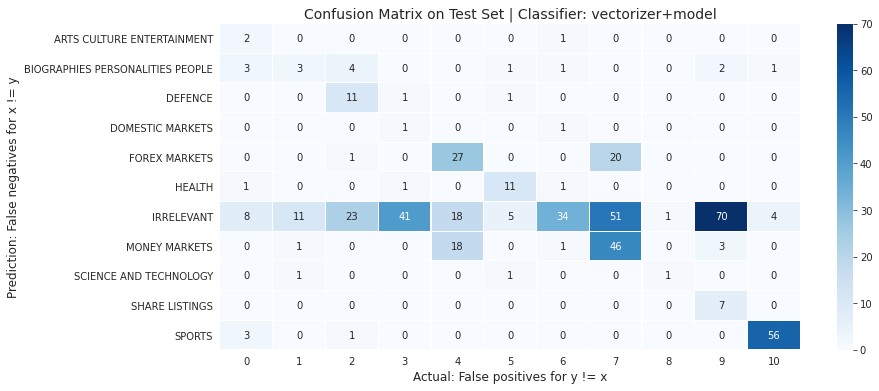

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_50
F1 score for  Pipeline  model is  0.3823428928932277
Accuracy score for  Pipeline  model is  0.398
Recall score for  Pipeline  model is  0.602017061885483 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.67      0.20         3
           1       0.19      0.20      0.19        15
           2       0.28      0.85      0.42        13
           3       0.02      0.50      0.04         2
           4       0.43      0.56      0.49        48
           5       0.58      0.79      0.67        14
           6       0.87      0.13      0.22       266
           7

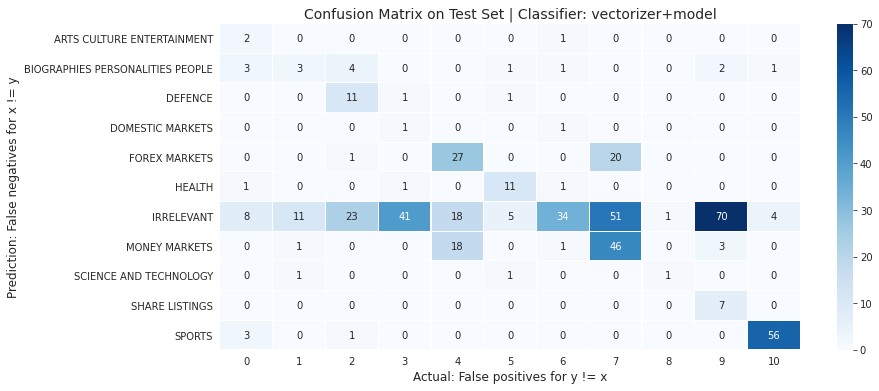

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_100
F1 score for  Pipeline  model is  0.3823428928932277
Accuracy score for  Pipeline  model is  0.398
Recall score for  Pipeline  model is  0.602017061885483 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.67      0.20         3
           1       0.19      0.20      0.19        15
           2       0.28      0.85      0.42        13
           3       0.02      0.50      0.04         2
           4       0.43      0.56      0.49        48
           5       0.58      0.79      0.67        14
           6       0.87      0.13      0.22       266
           

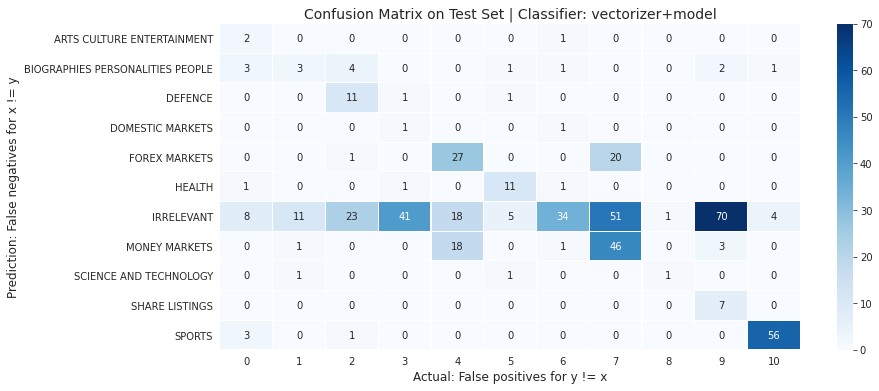

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is test_df
F1 score for  Pipeline  model is  0.3823428928932277
Accuracy score for  Pipeline  model is  0.398
Recall score for  Pipeline  model is  0.602017061885483 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.67      0.20         3
           1       0.19      0.20      0.19        15
           2       0.28      0.85      0.42        13
           3       0.02      0.50      0.04         2
           4       0.43      0.56      0.49        48
           5       0.58      0.79      0.67        14
           6       0.87      0.13      0.22       266
           7   

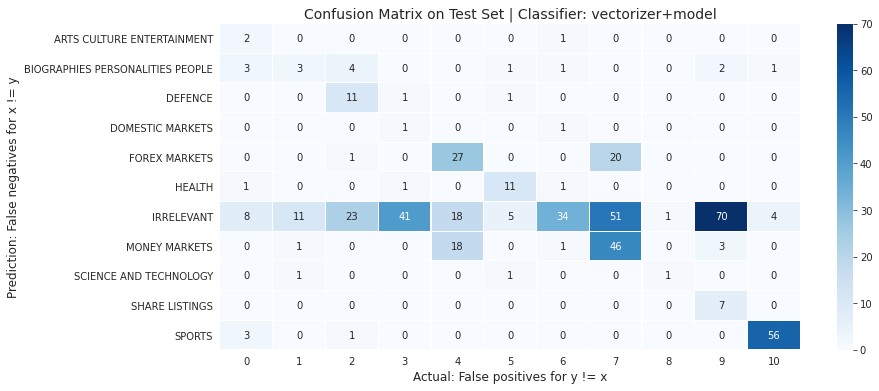

*************************************************************
Now the training set is df_train_20, and the model chosen is count_clf_NB
The accuracy is 0.7715514506864991
----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_20
F1 score for  Pipeline  model is  0.4114358737162307
Accuracy score for  Pipeline  model is  0.436
Recall score for  Pipeline  model is  0.6734490814296307 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.67      0.22         3
           1       0.35      0.40      0.38        15
           2       0.40      0.92      0.56        13
           3       0.04      1.00      0.08         2
  

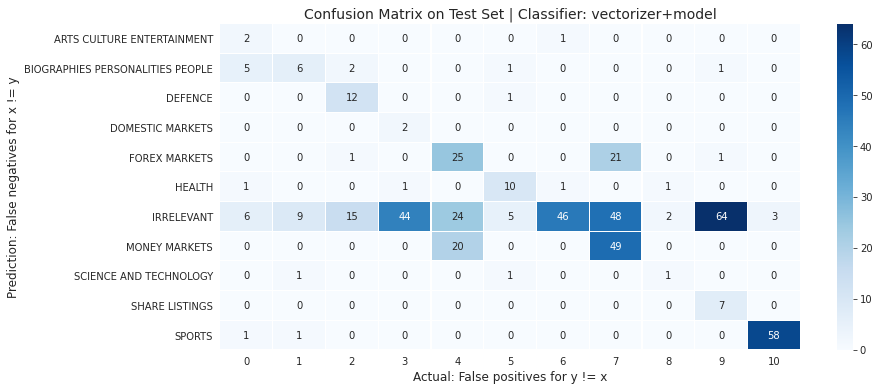

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_50
F1 score for  Pipeline  model is  0.4114358737162307
Accuracy score for  Pipeline  model is  0.436
Recall score for  Pipeline  model is  0.6734490814296307 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.67      0.22         3
           1       0.35      0.40      0.38        15
           2       0.40      0.92      0.56        13
           3       0.04      1.00      0.08         2
           4       0.36      0.52      0.43        48
           5       0.56      0.71      0.63        14
           6       0.96      0.17      0.29       266
           

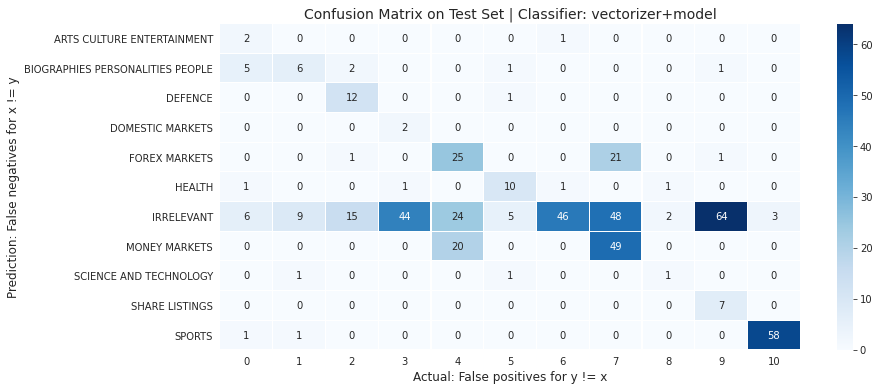

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_100
F1 score for  Pipeline  model is  0.4114358737162307
Accuracy score for  Pipeline  model is  0.436
Recall score for  Pipeline  model is  0.6734490814296307 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.67      0.22         3
           1       0.35      0.40      0.38        15
           2       0.40      0.92      0.56        13
           3       0.04      1.00      0.08         2
           4       0.36      0.52      0.43        48
           5       0.56      0.71      0.63        14
           6       0.96      0.17      0.29       266
          

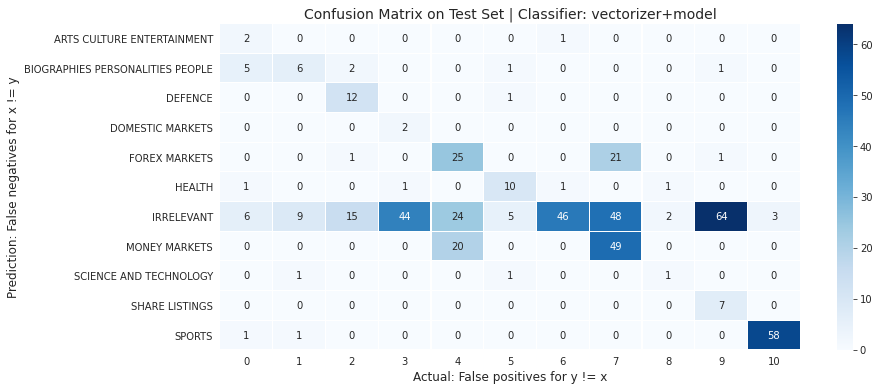

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is test_df
F1 score for  Pipeline  model is  0.4114358737162307
Accuracy score for  Pipeline  model is  0.436
Recall score for  Pipeline  model is  0.6734490814296307 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.67      0.22         3
           1       0.35      0.40      0.38        15
           2       0.40      0.92      0.56        13
           3       0.04      1.00      0.08         2
           4       0.36      0.52      0.43        48
           5       0.56      0.71      0.63        14
           6       0.96      0.17      0.29       266
           7  

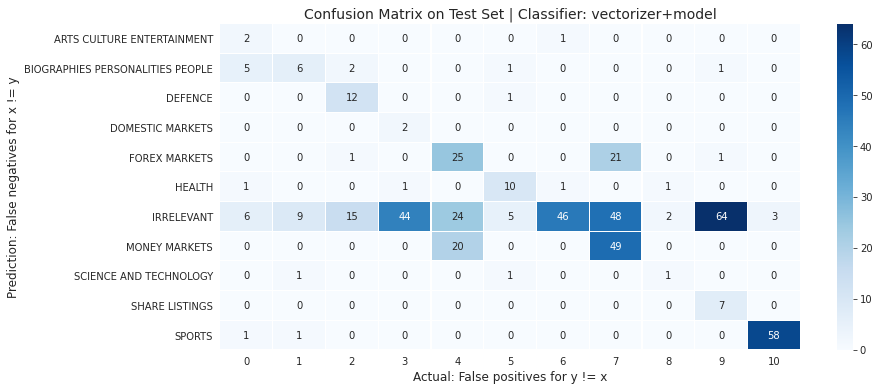

*************************************************************
Now the training set is df_train_50, and the model chosen is count_clf_NB
The accuracy is 0.8204093796398974
----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_20
F1 score for  Pipeline  model is  0.41208607076351983
Accuracy score for  Pipeline  model is  0.436
Recall score for  Pipeline  model is  0.6654245735195392 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.67      0.25         3
           1       0.26      0.33      0.29        15
           2       0.48      0.92      0.63        13
           3       0.04      1.00      0.07         2
 

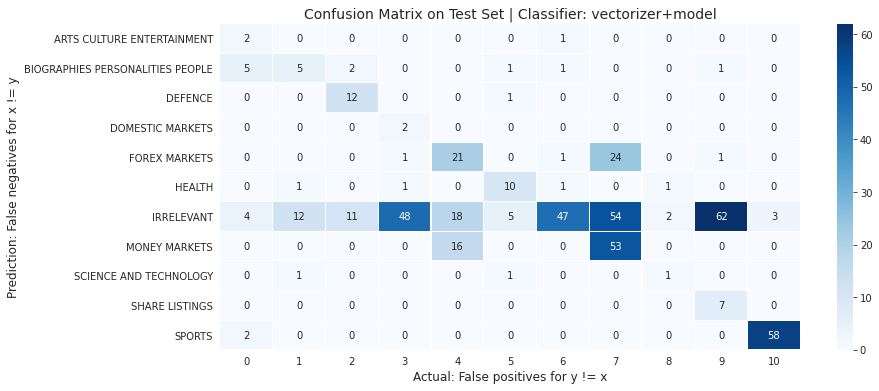

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_50
F1 score for  Pipeline  model is  0.45939726306375694
Accuracy score for  Pipeline  model is  0.486
Recall score for  Pipeline  model is  0.7353492617222593 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.59      0.67      0.62        15
           2       0.32      0.92      0.48        13
           3       0.05      1.00      0.09         2
           4       0.33      0.46      0.39        48
           5       0.55      0.79      0.65        14
           6       0.97      0.26      0.41       266
          

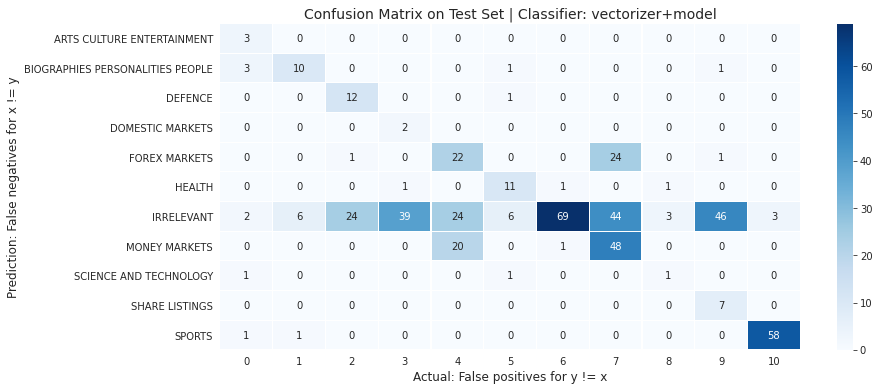

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_100
F1 score for  Pipeline  model is  0.45939726306375694
Accuracy score for  Pipeline  model is  0.486
Recall score for  Pipeline  model is  0.7353492617222593 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.59      0.67      0.62        15
           2       0.32      0.92      0.48        13
           3       0.05      1.00      0.09         2
           4       0.33      0.46      0.39        48
           5       0.55      0.79      0.65        14
           6       0.97      0.26      0.41       266
         

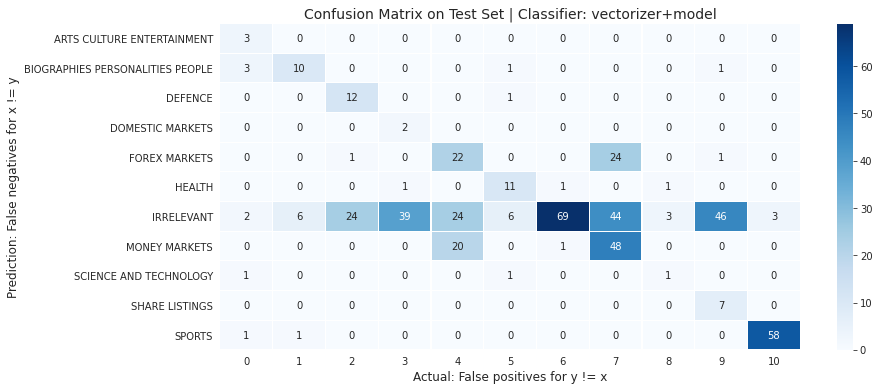

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is test_df
F1 score for  Pipeline  model is  0.45939726306375694
Accuracy score for  Pipeline  model is  0.486
Recall score for  Pipeline  model is  0.7353492617222593 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.59      0.67      0.62        15
           2       0.32      0.92      0.48        13
           3       0.05      1.00      0.09         2
           4       0.33      0.46      0.39        48
           5       0.55      0.79      0.65        14
           6       0.97      0.26      0.41       266
           7 

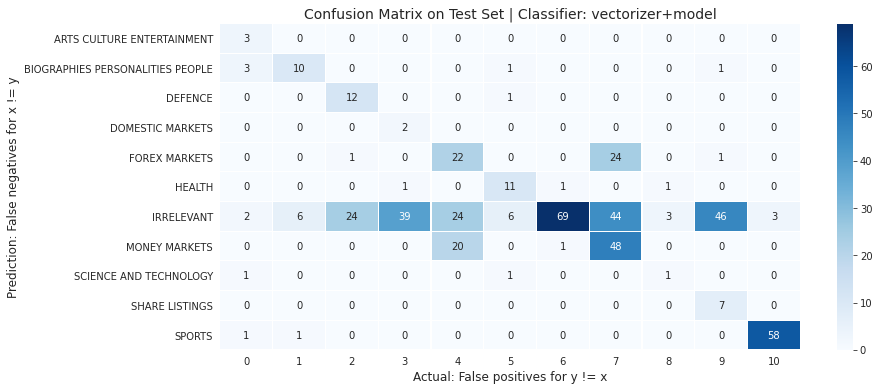

*************************************************************
Now the training set is df_train_100, and the model chosen is tfidf_clf_NB
The accuracy is 0.8355800209277537
----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_20
F1 score for  Pipeline  model is  0.4082877489777397
Accuracy score for  Pipeline  model is  0.426
Recall score for  Pipeline  model is  0.6417584417870459 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.33      0.18         3
           1       0.32      0.40      0.35        15
           2       0.43      0.92      0.59        13
           3       0.04      1.00      0.08         2


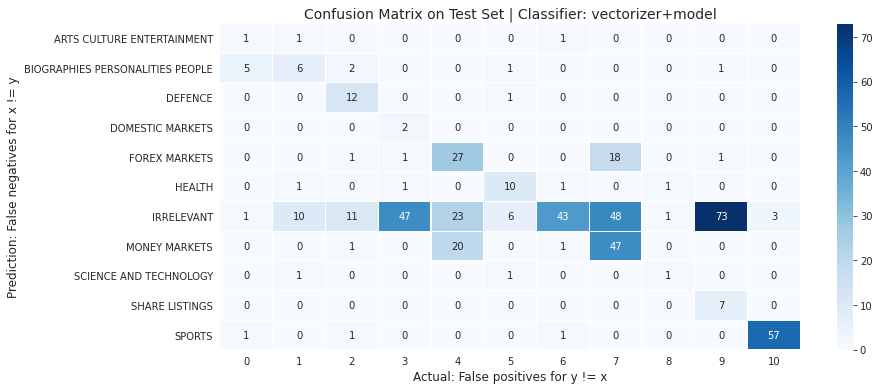

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_50
F1 score for  Pipeline  model is  0.4367893347823545
Accuracy score for  Pipeline  model is  0.48
Recall score for  Pipeline  model is  0.697095648440042 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.67      0.36         3
           1       0.44      0.47      0.45        15
           2       0.31      0.92      0.46        13
           3       0.05      1.00      0.09         2
           4       0.39      0.60      0.47        48
           5       0.52      0.79      0.63        14
           6       0.97      0.24      0.39       266
           7

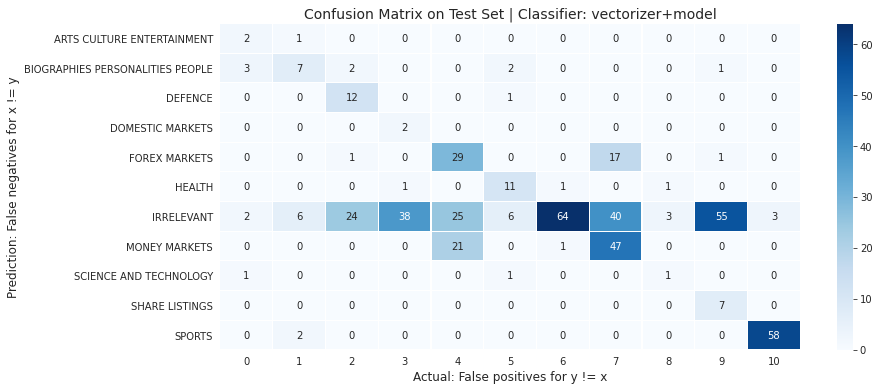

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_100
F1 score for  Pipeline  model is  0.476988168785576
Accuracy score for  Pipeline  model is  0.536
Recall score for  Pipeline  model is  0.6930498372718052 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.33      0.17         3
           1       0.62      0.67      0.65        15
           2       0.32      0.92      0.47        13
           3       0.06      1.00      0.11         2
           4       0.32      0.46      0.38        48
           5       0.55      0.86      0.67        14
           6       0.98      0.35      0.51       266
          

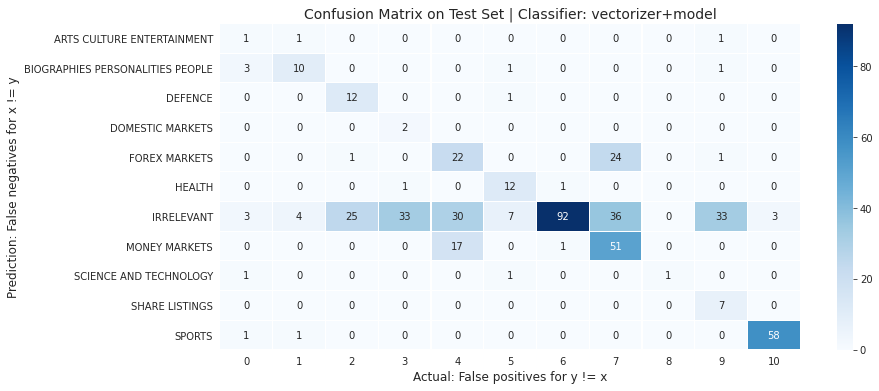

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is test_df
F1 score for  Pipeline  model is  0.476988168785576
Accuracy score for  Pipeline  model is  0.536
Recall score for  Pipeline  model is  0.6930498372718052 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.33      0.17         3
           1       0.62      0.67      0.65        15
           2       0.32      0.92      0.47        13
           3       0.06      1.00      0.11         2
           4       0.32      0.46      0.38        48
           5       0.55      0.86      0.67        14
           6       0.98      0.35      0.51       266
           7  

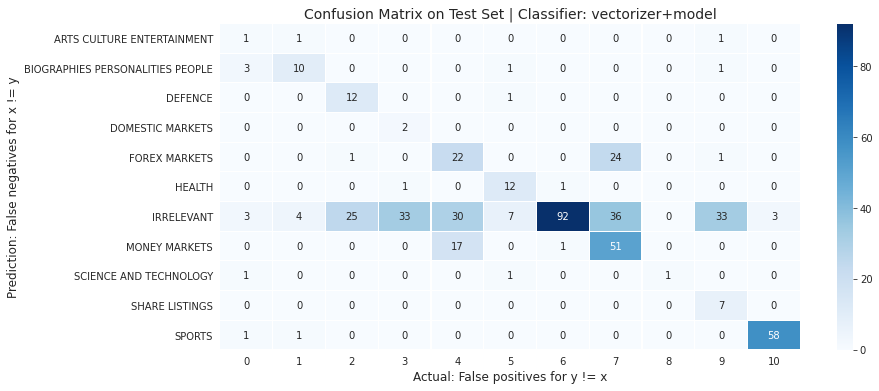

*************************************************************
Now the training set is train_df, and the model chosen is tfidf_clf_NB
The accuracy is 0.9623997900144465
----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is df_test_20
F1 score for  Pipeline  model is  0.3835806267089689
Accuracy score for  Pipeline  model is  0.376
Recall score for  Pipeline  model is  0.6176228805519424 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.50      0.20      0.29        15
           2       0.44      0.92      0.60        13
           3       0.04      1.00      0.08         2
        

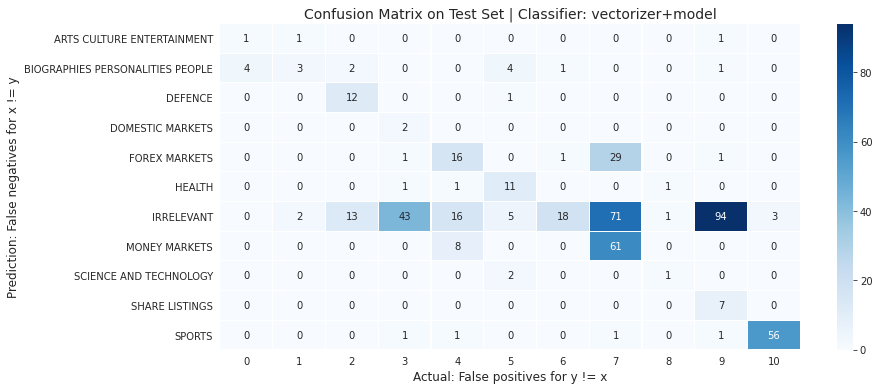

----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is df_test_50
F1 score for  Pipeline  model is  0.3575456353313808
Accuracy score for  Pipeline  model is  0.362
Recall score for  Pipeline  model is  0.5971740502060868 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.38      0.20      0.26        15
           2       0.27      0.85      0.41        13
           3       0.05      1.00      0.09         2
           4       0.33      0.29      0.31        48
           5       0.56      0.71      0.63        14
           6       0.85      0.06      0.12       266
           7  

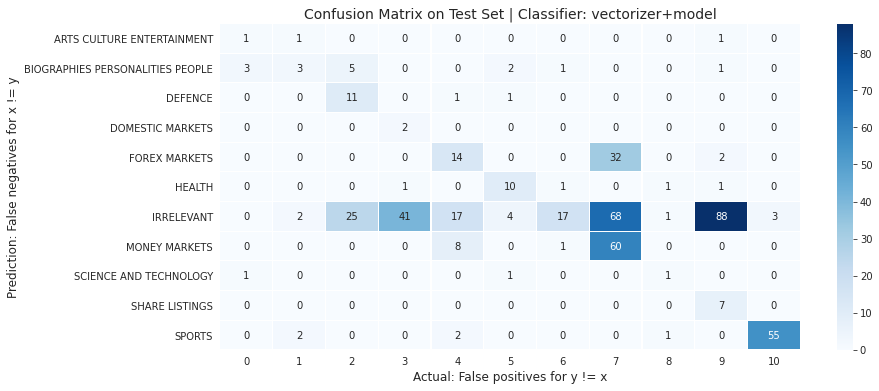

----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is df_test_100
F1 score for  Pipeline  model is  0.40439636005509955
Accuracy score for  Pipeline  model is  0.414
Recall score for  Pipeline  model is  0.6327242646750656 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.56      0.33      0.42        15
           2       0.32      0.85      0.47        13
           3       0.05      1.00      0.10         2
           4       0.39      0.31      0.35        48
           5       0.52      0.86      0.65        14
           6       0.88      0.14      0.24       266
           7

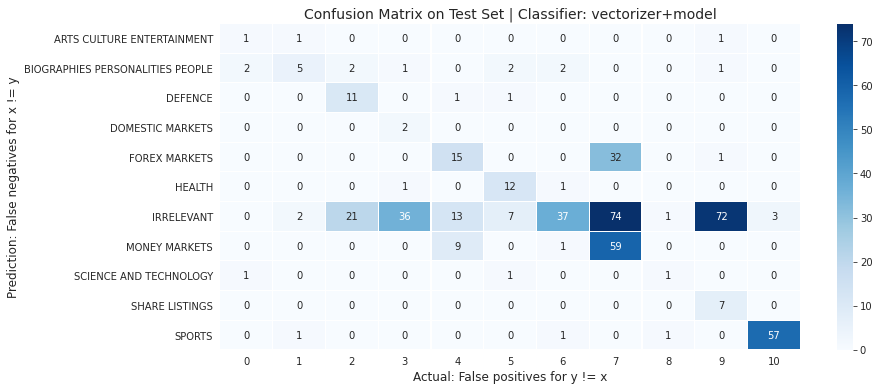

----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is test_df
F1 score for  Pipeline  model is  0.4556854016224356
Accuracy score for  Pipeline  model is  0.724
Recall score for  Pipeline  model is  0.4394210671098543 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       1.00      0.13      0.24        15
           2       0.86      0.46      0.60        13
           3       0.33      0.50      0.40         2
           4       0.36      0.33      0.34        48
           5       0.86      0.43      0.57        14
           6       0.82      0.84      0.83       266
           7     

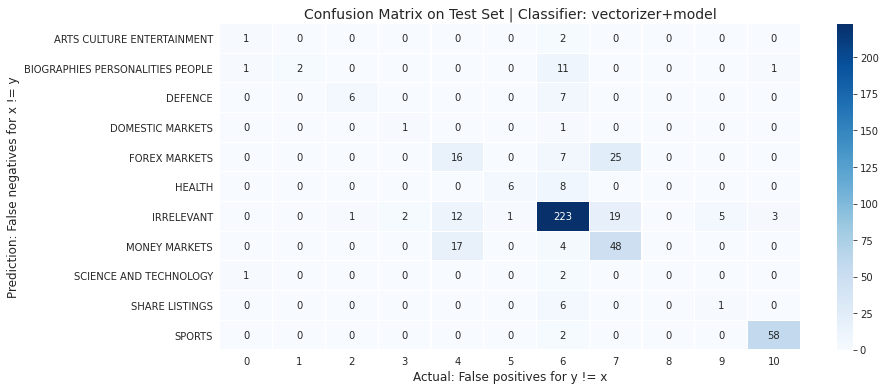

CPU times: user 4min 41s, sys: 2min 50s, total: 7min 31s
Wall time: 2h 35min 7s


In [42]:
%%time
for train_df in df_train_all:
    clf_NB,le,encode_mapping = get_model(train_df)
    for test_df in df_test_all:
        if (test_df.isnull().values.any()):
            continue
        print('----------------------------------------------------------------------')
        print(f'Now, the train_df is {train_df.name}, the test_df is {test_df.name}')
        test_model(test_df,clf_NB,le,encode_mapping)

*************************************************************
Now the training set is df_train_10, and the model chosen is count_clf_NB
The accuracy is 0.7093155030645182
----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_20
F1 score for  Pipeline  model is  0.4292663105706676
Accuracy score for  Pipeline  model is  0.462
Recall score for  Pipeline  model is  0.6387109458047673 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.67      0.18         3
           1       0.30      0.47      0.37        15
           2       0.39      0.85      0.54        13
           3       0.03      0.50      0.06         2
  

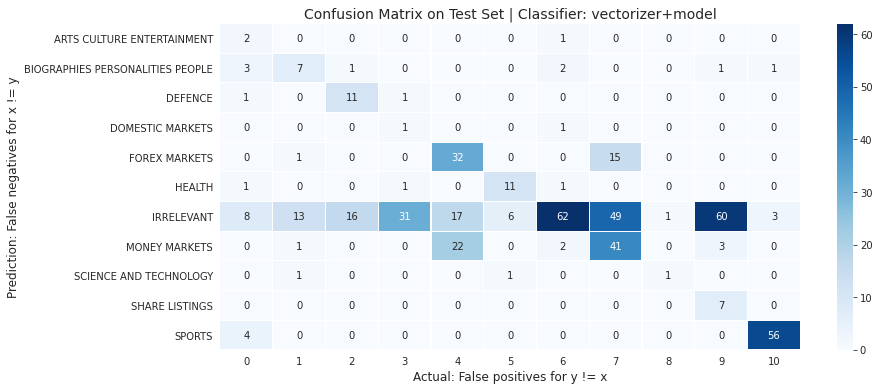

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_50
F1 score for  Pipeline  model is  0.4292663105706676
Accuracy score for  Pipeline  model is  0.462
Recall score for  Pipeline  model is  0.6387109458047673 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.67      0.18         3
           1       0.30      0.47      0.37        15
           2       0.39      0.85      0.54        13
           3       0.03      0.50      0.06         2
           4       0.45      0.67      0.54        48
           5       0.61      0.79      0.69        14
           6       0.90      0.23      0.37       266
           

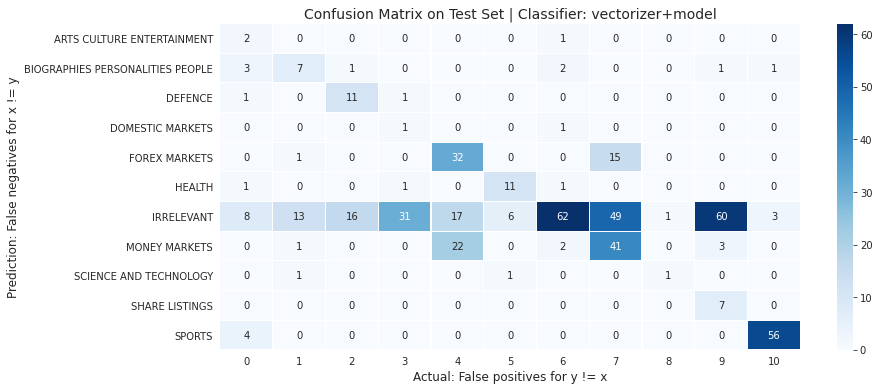

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_100
F1 score for  Pipeline  model is  0.4292663105706676
Accuracy score for  Pipeline  model is  0.462
Recall score for  Pipeline  model is  0.6387109458047673 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.67      0.18         3
           1       0.30      0.47      0.37        15
           2       0.39      0.85      0.54        13
           3       0.03      0.50      0.06         2
           4       0.45      0.67      0.54        48
           5       0.61      0.79      0.69        14
           6       0.90      0.23      0.37       266
          

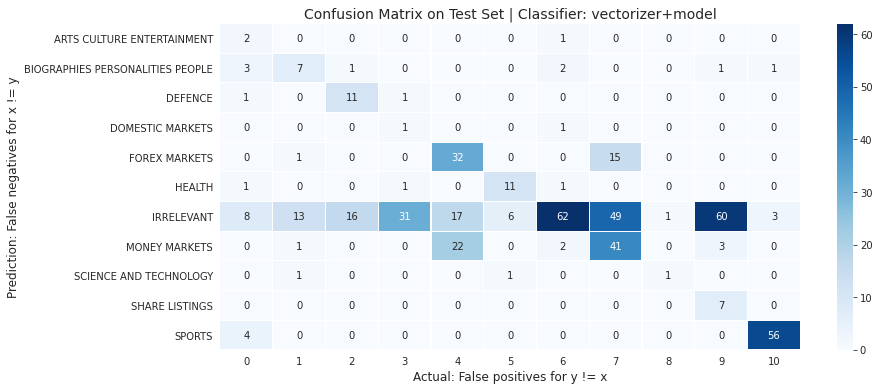

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is test_df
F1 score for  Pipeline  model is  0.4292663105706676
Accuracy score for  Pipeline  model is  0.462
Recall score for  Pipeline  model is  0.6387109458047673 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.67      0.18         3
           1       0.30      0.47      0.37        15
           2       0.39      0.85      0.54        13
           3       0.03      0.50      0.06         2
           4       0.45      0.67      0.54        48
           5       0.61      0.79      0.69        14
           6       0.90      0.23      0.37       266
           7  

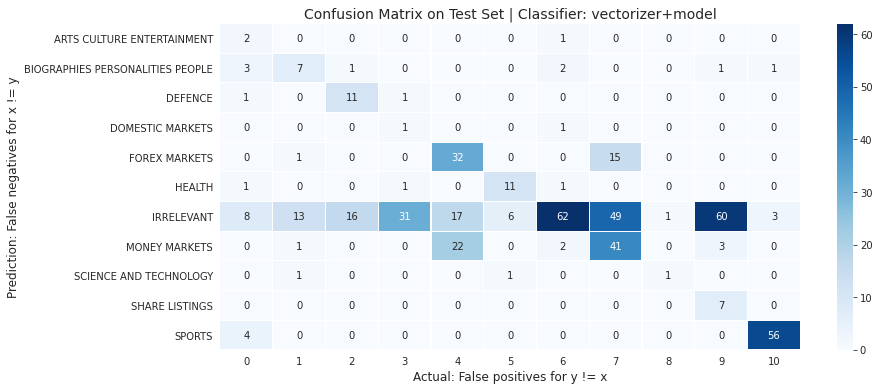

*************************************************************
Now the training set is df_train_20, and the model chosen is tfidf_clf_NB
The accuracy is 0.7613153153032632
----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_20
F1 score for  Pipeline  model is  0.465746454838321
Accuracy score for  Pipeline  model is  0.534
Recall score for  Pipeline  model is  0.691259931906385 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.67      0.25         3
           1       0.26      0.40      0.32        15
           2       0.50      0.85      0.63        13
           3       0.07      1.00      0.13         2
    

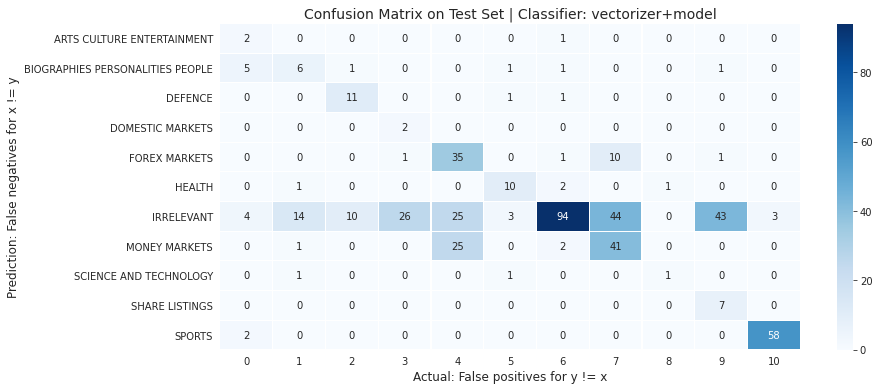

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_50
F1 score for  Pipeline  model is  0.465746454838321
Accuracy score for  Pipeline  model is  0.534
Recall score for  Pipeline  model is  0.691259931906385 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.67      0.25         3
           1       0.26      0.40      0.32        15
           2       0.50      0.85      0.63        13
           3       0.07      1.00      0.13         2
           4       0.41      0.73      0.53        48
           5       0.62      0.71      0.67        14
           6       0.92      0.35      0.51       266
           7 

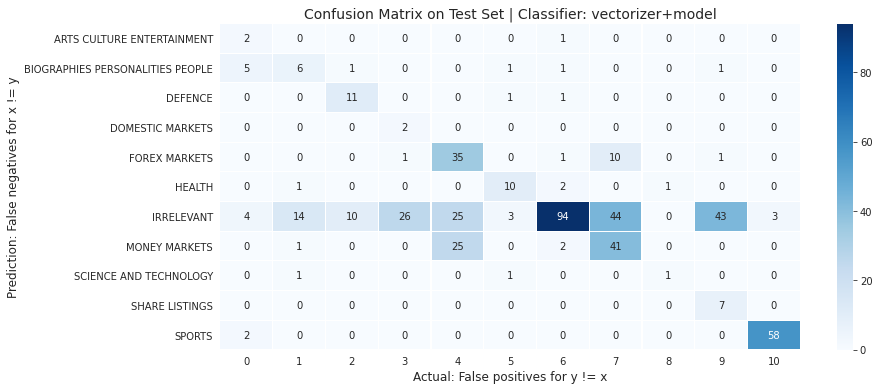

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_100
F1 score for  Pipeline  model is  0.465746454838321
Accuracy score for  Pipeline  model is  0.534
Recall score for  Pipeline  model is  0.691259931906385 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.67      0.25         3
           1       0.26      0.40      0.32        15
           2       0.50      0.85      0.63        13
           3       0.07      1.00      0.13         2
           4       0.41      0.73      0.53        48
           5       0.62      0.71      0.67        14
           6       0.92      0.35      0.51       266
           7

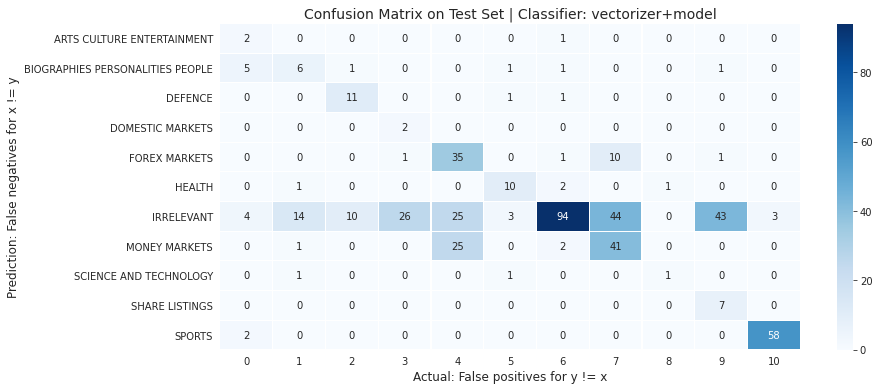

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is test_df
F1 score for  Pipeline  model is  0.465746454838321
Accuracy score for  Pipeline  model is  0.534
Recall score for  Pipeline  model is  0.691259931906385 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.67      0.25         3
           1       0.26      0.40      0.32        15
           2       0.50      0.85      0.63        13
           3       0.07      1.00      0.13         2
           4       0.41      0.73      0.53        48
           5       0.62      0.71      0.67        14
           6       0.92      0.35      0.51       266
           7    

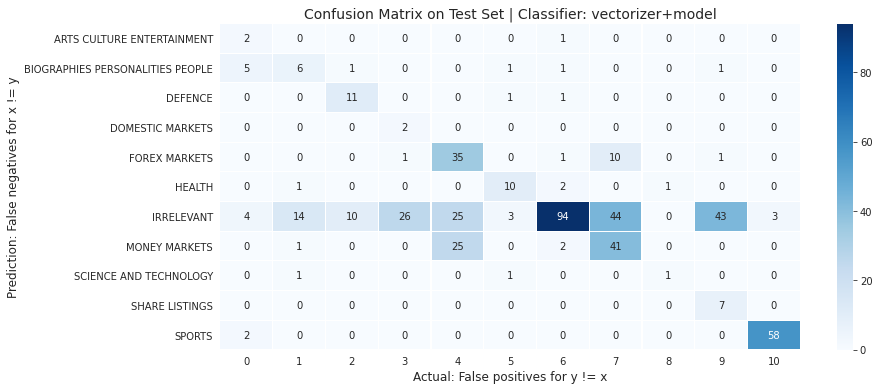

*************************************************************
Now the training set is df_train_50, and the model chosen is tfidf_clf_NB
The accuracy is 0.8105966851016164
----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_20
F1 score for  Pipeline  model is  0.4450420032464713
Accuracy score for  Pipeline  model is  0.466
Recall score for  Pipeline  model is  0.6984048750639139 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.67      0.24         3
           1       0.33      0.53      0.41        15
           2       0.52      0.92      0.67        13
           3       0.05      1.00      0.10         2
  

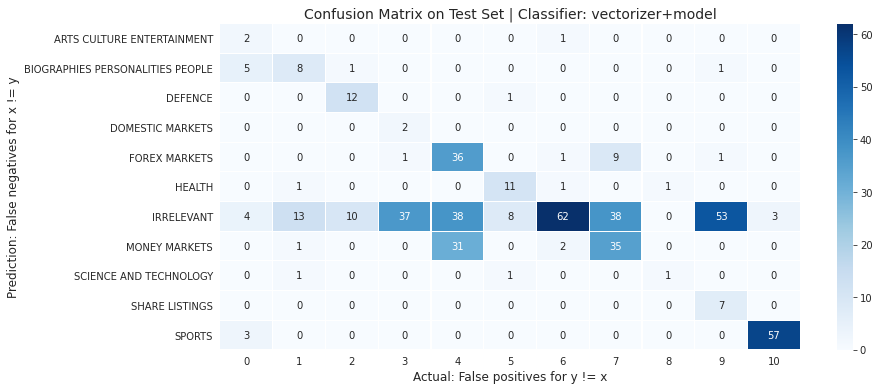

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_50
F1 score for  Pipeline  model is  0.5132226947392878
Accuracy score for  Pipeline  model is  0.586
Recall score for  Pipeline  model is  0.7547151361224587 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.52      0.73      0.61        15
           2       0.34      0.85      0.49        13
           3       0.06      1.00      0.12         2
           4       0.41      0.79      0.54        48
           5       0.61      0.79      0.69        14
           6       0.97      0.42      0.59       266
           

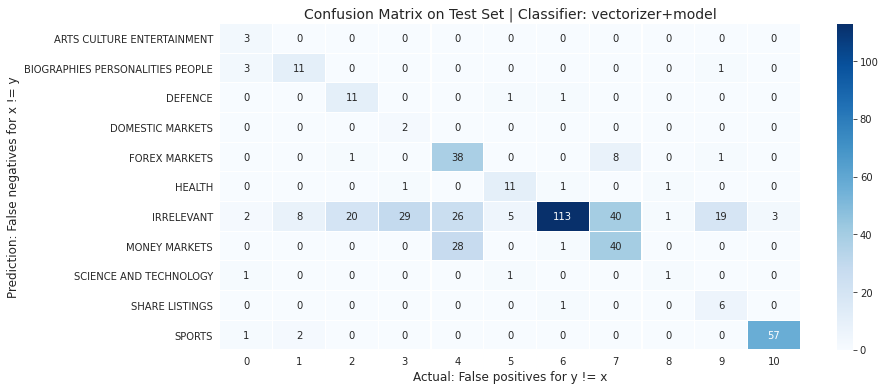

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_100
F1 score for  Pipeline  model is  0.5132226947392878
Accuracy score for  Pipeline  model is  0.586
Recall score for  Pipeline  model is  0.7547151361224587 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.52      0.73      0.61        15
           2       0.34      0.85      0.49        13
           3       0.06      1.00      0.12         2
           4       0.41      0.79      0.54        48
           5       0.61      0.79      0.69        14
           6       0.97      0.42      0.59       266
          

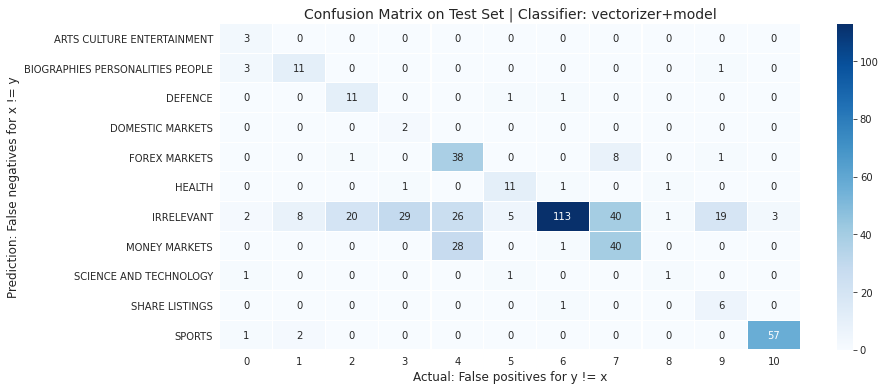

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is test_df
F1 score for  Pipeline  model is  0.5132226947392878
Accuracy score for  Pipeline  model is  0.586
Recall score for  Pipeline  model is  0.7547151361224587 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.52      0.73      0.61        15
           2       0.34      0.85      0.49        13
           3       0.06      1.00      0.12         2
           4       0.41      0.79      0.54        48
           5       0.61      0.79      0.69        14
           6       0.97      0.42      0.59       266
           7  

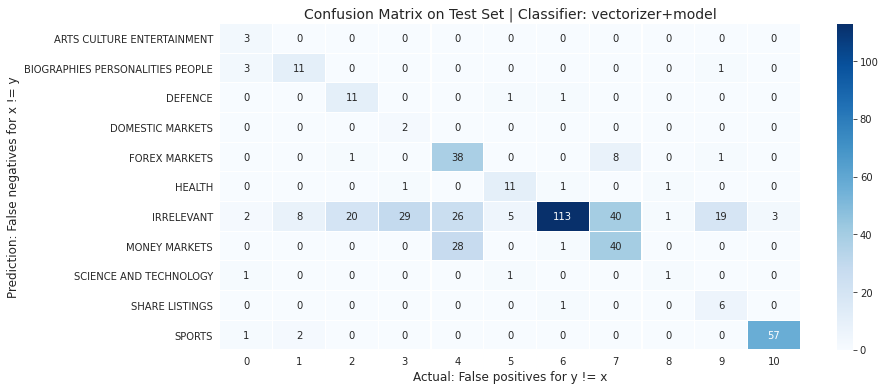

*************************************************************
Now the training set is df_train_100, and the model chosen is count_clf_NB
The accuracy is 0.840438543972326
----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_20
F1 score for  Pipeline  model is  0.42085046740228493
Accuracy score for  Pipeline  model is  0.416
Recall score for  Pipeline  model is  0.6846848041356051 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.67      0.27         3
           1       0.30      0.53      0.38        15
           2       0.46      0.92      0.62        13
           3       0.04      1.00      0.08         2


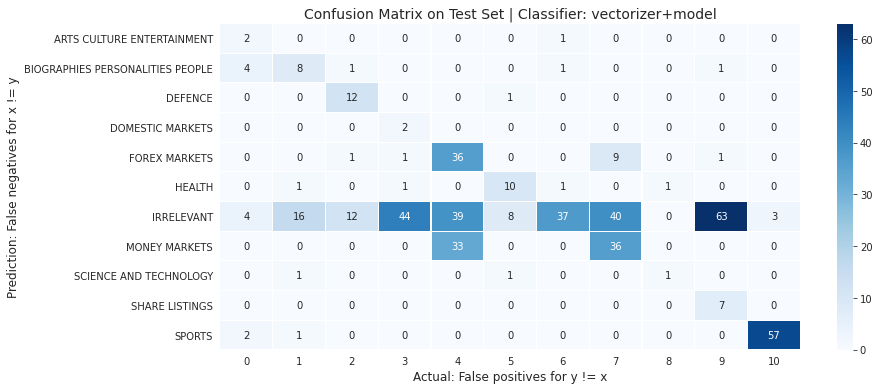

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_50
F1 score for  Pipeline  model is  0.49485225164114177
Accuracy score for  Pipeline  model is  0.528
Recall score for  Pipeline  model is  0.7576468725782225 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.52      0.73      0.61        15
           2       0.31      0.85      0.46        13
           3       0.06      1.00      0.11         2
           4       0.37      0.79      0.51        48
           5       0.61      0.79      0.69        14
           6       0.97      0.31      0.47       266
         

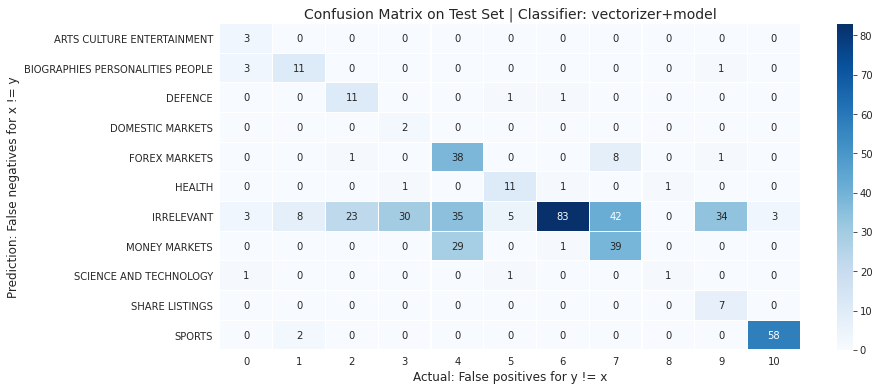

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_100
F1 score for  Pipeline  model is  0.5251245384370083
Accuracy score for  Pipeline  model is  0.61
Recall score for  Pipeline  model is  0.7289097630058727 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.56      0.60      0.58        15
           2       0.35      0.85      0.50        13
           3       0.08      1.00      0.14         2
           4       0.39      0.75      0.51        48
           5       0.58      0.79      0.67        14
           6       0.93      0.48      0.63       266
          

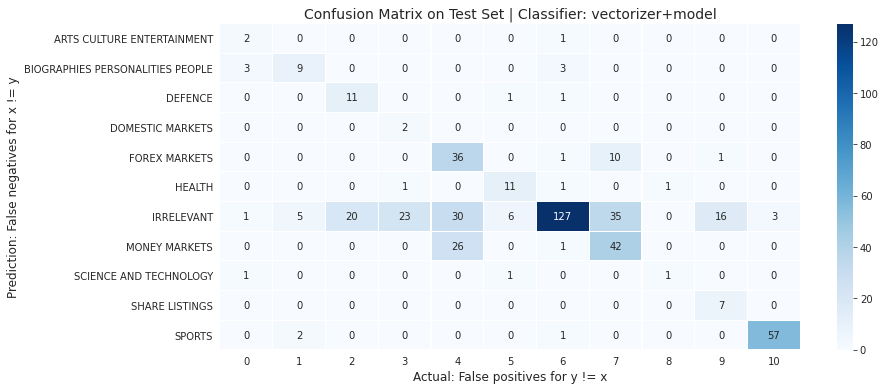

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is test_df
F1 score for  Pipeline  model is  0.5251245384370083
Accuracy score for  Pipeline  model is  0.61
Recall score for  Pipeline  model is  0.7289097630058727 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.56      0.60      0.58        15
           2       0.35      0.85      0.50        13
           3       0.08      1.00      0.14         2
           4       0.39      0.75      0.51        48
           5       0.58      0.79      0.67        14
           6       0.93      0.48      0.63       266
           7  

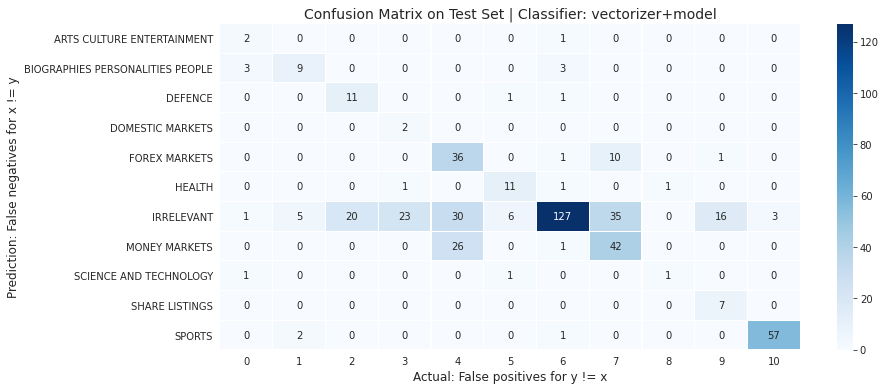

*************************************************************
Now the training set is train_df, and the model chosen is tfidf_clf_NB
The accuracy is 0.9308484280731626
----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is df_test_20
F1 score for  Pipeline  model is  0.38281620753617335
Accuracy score for  Pipeline  model is  0.35
Recall score for  Pipeline  model is  0.6782237404090952 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.50      0.53      0.52        15
           2       0.29      0.92      0.44        13
           3       0.04      1.00      0.07         2
        

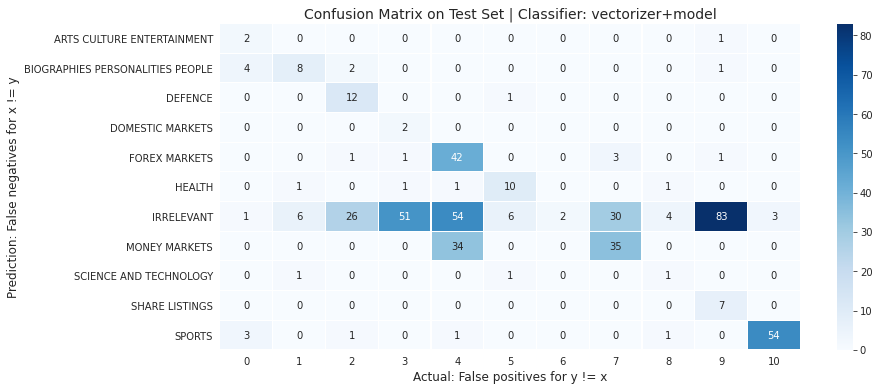

----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is df_test_50
F1 score for  Pipeline  model is  0.41275263275911606
Accuracy score for  Pipeline  model is  0.36
Recall score for  Pipeline  model is  0.7108860533059618 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       0.57      0.53      0.55        15
           2       0.24      0.92      0.38        13
           3       0.04      1.00      0.08         2
           4       0.31      0.85      0.45        48
           5       0.56      0.71      0.63        14
           6       0.83      0.02      0.04       266
           7  

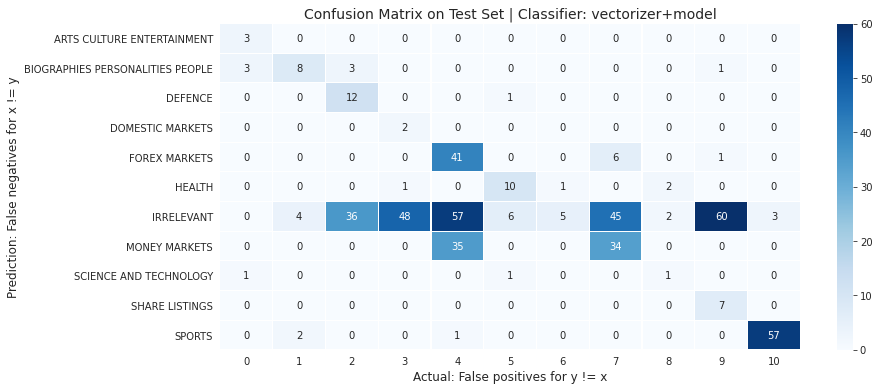

----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is df_test_100
F1 score for  Pipeline  model is  0.43908160786305644
Accuracy score for  Pipeline  model is  0.422
Recall score for  Pipeline  model is  0.6996227170998338 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.62      0.53      0.57        15
           2       0.26      0.92      0.41        13
           3       0.05      1.00      0.09         2
           4       0.32      0.85      0.46        48
           5       0.58      0.79      0.67        14
           6       0.92      0.13      0.22       266
           7

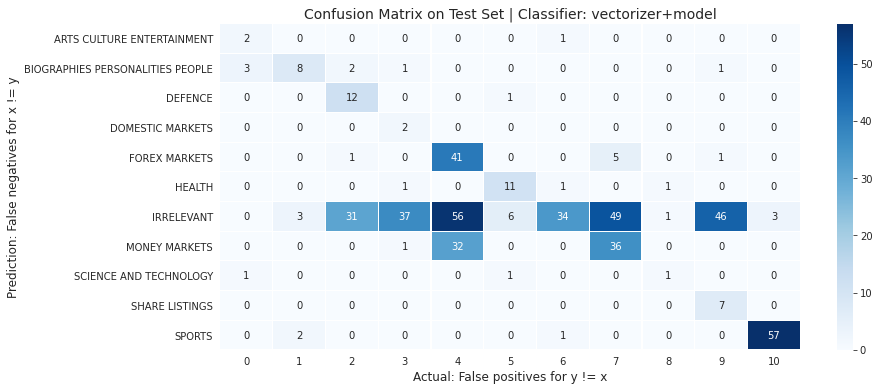

----------------------------------------------------------------------
Now, the train_df is train_df, the test_df is test_df
F1 score for  Pipeline  model is  0.5812766414258494
Accuracy score for  Pipeline  model is  0.724
Recall score for  Pipeline  model is  0.6403599737409805 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.83      0.33      0.48        15
           2       0.56      0.77      0.65        13
           3       0.11      0.50      0.18         2
           4       0.41      0.69      0.52        48
           5       0.76      0.93      0.84        14
           6       0.91      0.72      0.81       266
           7     

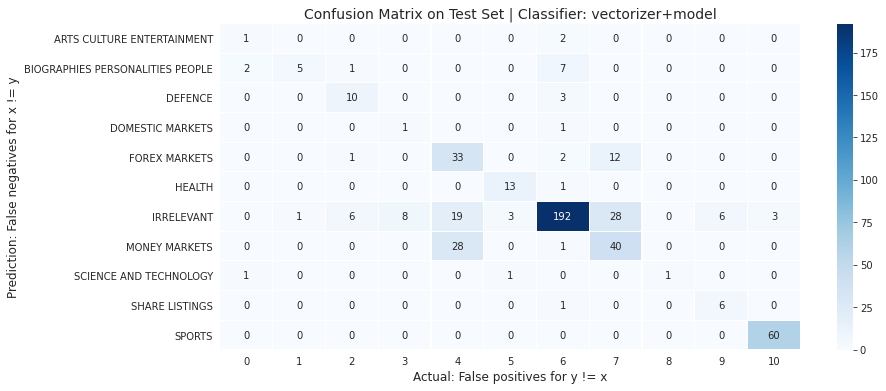

CPU times: user 3min 3s, sys: 10.3 s, total: 3min 13s
Wall time: 51min 4s


In [48]:
%%time
for train_df in df_train_all:
    clf_NB,le,encode_mapping = get_model_2(train_df)
    for test_df in df_test_all:
        if (test_df.isnull().values.any()):
            continue
        print('----------------------------------------------------------------------')
        print(f'Now, the train_df is {train_df.name}, the test_df is {test_df.name}')
        test_model(test_df,clf_NB,le,encode_mapping)

In [9]:
%%time
clf_NB_1,le,encode_mapping = get_model_2(df_train_full)
save_variable(clf_NB_1,"clf_NB_1")

clf_NB_2,le,encode_mapping = get_model(df_train_full)
save_variable(clf_NB_2,"clf_NB_2")

*************************************************************
Now the training set is df_train_full, and the model chosen is tfidf_clf_NB
The accuracy is 0.9308484280731626
*************************************************************
Now the training set is df_train_full, and the model chosen is tfidf_clf_NB
The accuracy is 0.9623997900144465
CPU times: user 2min 17s, sys: 59 s, total: 3min 16s
Wall time: 1h 16min 34s


In [10]:
%%time
clf_NB_3,le,encode_mapping = get_model_2(df_train_100)
save_variable(clf_NB_3,"clf_NB_3")

*************************************************************
Now the training set is df_train_100, and the model chosen is count_clf_NB
The accuracy is 0.840438543972326
CPU times: user 40.5 s, sys: 2.35 s, total: 42.9 s
Wall time: 10min 22s


# Data Without Irrelevant Keywords

In [110]:
TRAINING_FILE = "../keyword.csv"
TEST_FILE = "../key_word_test.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
print(df_train.isnull().sum())
df_train.head(5)

Unnamed: 0         0
article_number     0
article_words      0
topic              0
IR_binary          0
key_word_10       62
key_word_20       18
key_word_50        0
key_word_100       0
dtype: int64


Unnamed: 0  article_number  \
0           0               1   
1           1               2   
2           2               3   
3           3               4   
4           4               5   

                                       article_words          topic  \
0  open,absent,cent,cent,cent,stock,inflow,rate,k...  FOREX MARKETS   
1  morn,stead,end,end,day,day,day,patch,patch,pat...  MONEY MARKETS   
2  socc,socc,world,world,recent,law,fifa,fifa,fif...         SPORTS   
3  open,forint,forint,forint,forint,cent,cent,ste...  FOREX MARKETS   
4  morn,complet,weekend,minut,minut,minut,arrow,d...     IRRELEVANT   

   IR_binary                                        key_word_10  \
0      False  stock,rate,defend,bank,bank,bank,bank,bank,dol...   
1      False  day,day,day,bank,year,dollar,dollar,deal,deal,...   
2      False  world,world,stat,stat,stat,stat,year,releas,re...   
3      False  play,bank,bank,mark,mark,percent,percent,perce...   
4       True                                                day   

                                         key_word_20  \
0  cent,cent,cent,stock,rate,end,won,won,won,won,...   
1  end,end,day,day,day,point,time,bank,year,dolla...   
2  world,world,stat,stat,stat,stat,govern,time,ye...   
3  cent,cent,end,play,unit,bank,bank,mark,mark,pe...   
4                               day,time,season,clos   

                                         key_word_50  \
0  open,cent,cent,cent,stock,rate,end,won,won,won...   
1  end,end,day,day,day,point,time,bank,early,year...   
2  socc,socc,world,world,stat,stat,stat,stat,gove...   
3  open,cent,cent,end,play,unit,made,bank,bank,tu...   
4  minut,minut,minut,day,friday,friday,race,time,...   

                                        key_word_100  
0  open,cent,cent,cent,stock,rate,end,won,won,won...  
1  end,end,day,day,day,index,point,time,busi,bank...  
2  socc,socc,world,world,recent,law,stat,stat,sta...  
3  open,cent,cent,end,play,unit,made,bank,bank,ra...  
4  minut,minut,minut,day,friday,friday,race,time,...

In [111]:
rel_df_train = df_train[df_train.topic!="IRRELEVANT"]
irr_df_train = df_train[df_train.topic=="IRRELEVANT"]
irr_df_train = irr_df_train.rename(columns={'article_words':'key_word'})
irr_df_train = pd.DataFrame(irr_df_train,columns=['key_word','topic'])

In [112]:
# Separate out training sets with different size of keywords in the training set
df_train_10 = pd.DataFrame(rel_df_train,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_train_10 = pd.concat([df_train_10,irr_df_train]).sort_index()
df_train_10.name = 'df_train_10'
df_train_20 = pd.DataFrame(rel_df_train,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_train_20 = pd.concat([df_train_20,irr_df_train]).sort_index()
df_train_20.name = 'df_train_20'
df_train_50 = pd.DataFrame(rel_df_train,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_train_50 = pd.concat([df_train_50,irr_df_train]).sort_index()
df_train_50.name = 'df_train_50'
df_train_100 = pd.DataFrame(rel_df_train,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_train_100 = pd.concat([df_train_100,irr_df_train]).sort_index()
df_train_100.name = 'df_train_100'
df_train_full = pd.DataFrame(df_train,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_train_full.name = 'df_train_full'
df_train_all = [df_train_10,df_train_20,df_train_50,df_train_100,df_train_full]

In [113]:
# Separate out training sets with different size of keywords in the test set
df_test_10 = pd.DataFrame(df_test,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_test_10.name = 'df_test_10'
df_test_20 = pd.DataFrame(df_test,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_test_20.name = 'df_test_20'
df_test_50 = pd.DataFrame(df_test,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_test_50.name = 'df_test_50'
df_test_100 = pd.DataFrame(df_test,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_test_100.name = 'df_test_100'
df_test_full = pd.DataFrame(df_test,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_test_full.name = 'df_test_full'
df_test_all = [df_test_10,df_test_20,df_test_50,df_test_100,df_test_full]

*************************************************************
Now the training set is df_train_10, and the model chosen is count_clf_NB
The accuracy is 0.8114414248572981
----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_20
F1 score for  Pipeline  model is  0.3454309181546596
Accuracy score for  Pipeline  model is  0.54
Recall score for  Pipeline  model is  0.41828357569204255 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.33      0.13         3
           1       0.25      0.07      0.11        15
           2       0.62      0.62      0.62        13
           3       0.04      0.50      0.08         2
  

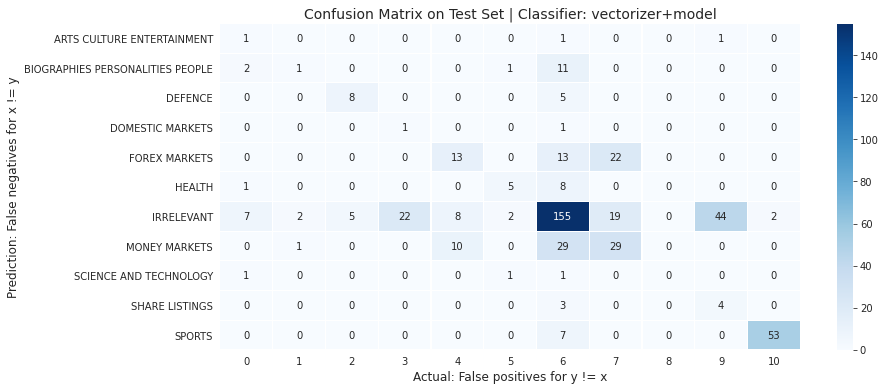

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_50
F1 score for  Pipeline  model is  0.13208628970897654
Accuracy score for  Pipeline  model is  0.558
Recall score for  Pipeline  model is  0.1288375335572132 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.75      0.06      0.12        48
           5       0.33      0.07      0.12        14
           6       0.55      0.96      0.70       266
          

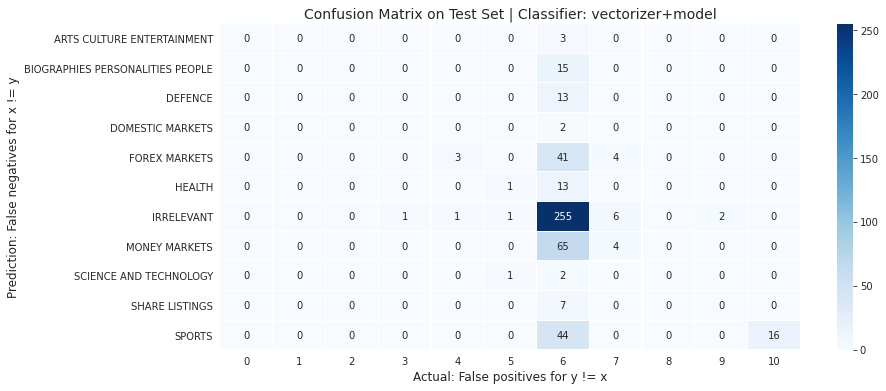

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_100
F1 score for  Pipeline  model is  0.09756062235101304
Accuracy score for  Pipeline  model is  0.548
Recall score for  Pipeline  model is  0.10898441756565326 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        48
           5       1.00      0.07      0.13        14
           6       0.54      1.00      0.70       266
        

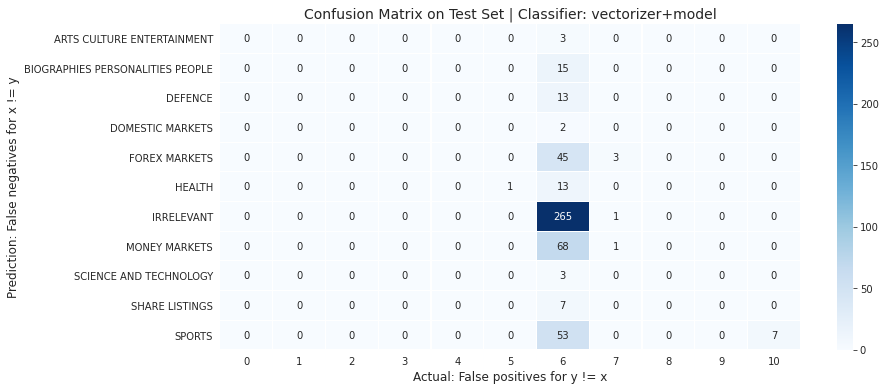

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_full
F1 score for  Pipeline  model is  0.0747247503153015
Accuracy score for  Pipeline  model is  0.54
Recall score for  Pipeline  model is  0.09677206851119896 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        14
           6       0.54      1.00      0.70       266
         

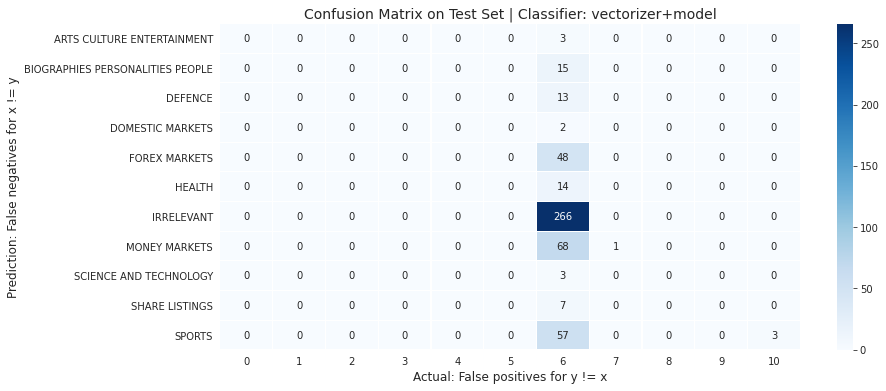

*************************************************************
Now the training set is df_train_20, and the model chosen is count_clf_NB
The accuracy is 0.8512116576497961
----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_20
F1 score for  Pipeline  model is  0.36772821928580407
Accuracy score for  Pipeline  model is  0.346
Recall score for  Pipeline  model is  0.6596218998392911 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.67      0.21         3
           1       0.32      0.40      0.35        15
           2       0.35      0.92      0.51        13
           3       0.04      1.00      0.07         2
 

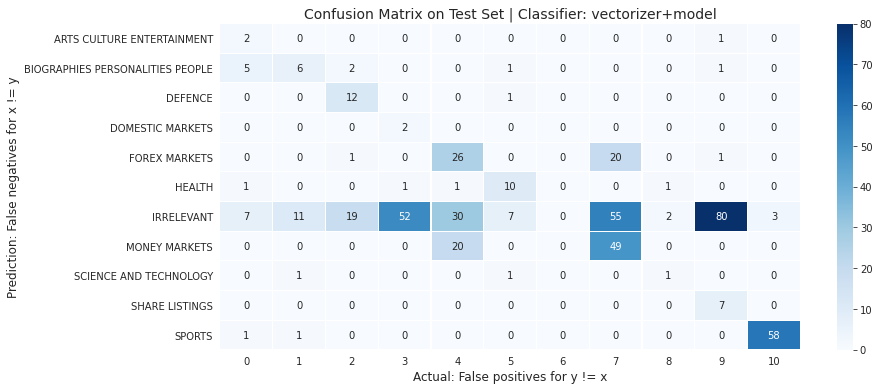

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_50
F1 score for  Pipeline  model is  0.25502734194102883
Accuracy score for  Pipeline  model is  0.558
Recall score for  Pipeline  model is  0.23016370547835077 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.00      0.00      0.00        15
           2       1.00      0.08      0.14        13
           3       0.00      0.00      0.00         2
           4       0.75      0.06      0.12        48
           5       0.33      0.14      0.20        14
           6       0.57      0.92      0.70       266
         

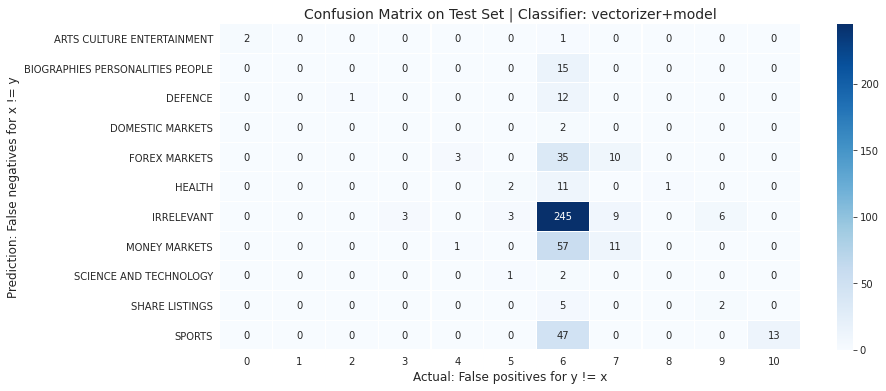

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_100
F1 score for  Pipeline  model is  0.07369707369707369
Accuracy score for  Pipeline  model is  0.532
Recall score for  Pipeline  model is  0.09520738605406799 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        14
           6       0.53      0.98      0.69       266
        

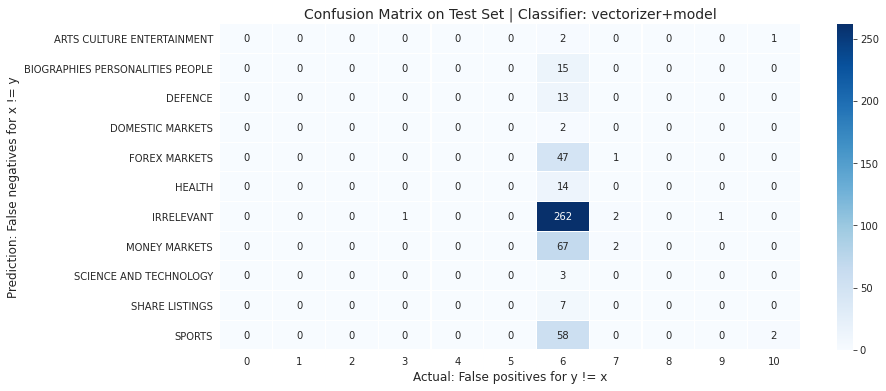

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_full
F1 score for  Pipeline  model is  0.06620106562247353
Accuracy score for  Pipeline  model is  0.534
Recall score for  Pipeline  model is  0.09242424242424242 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        14
           6       0.53      1.00      0.70       266
       

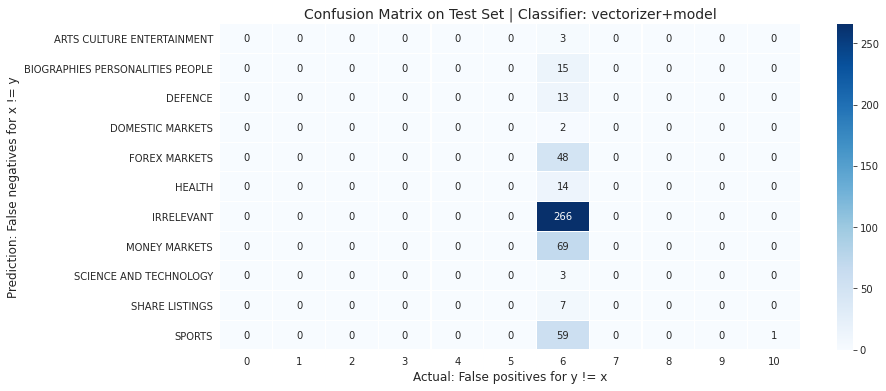

*************************************************************
Now the training set is df_train_50, and the model chosen is count_clf_NB
The accuracy is 0.8919805239726623
----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_20
F1 score for  Pipeline  model is  0.3620954218990978
Accuracy score for  Pipeline  model is  0.342
Recall score for  Pipeline  model is  0.6493616890356021 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.67      0.19         3
           1       0.24      0.33      0.28        15
           2       0.41      0.92      0.57        13
           3       0.03      1.00      0.06         2
  

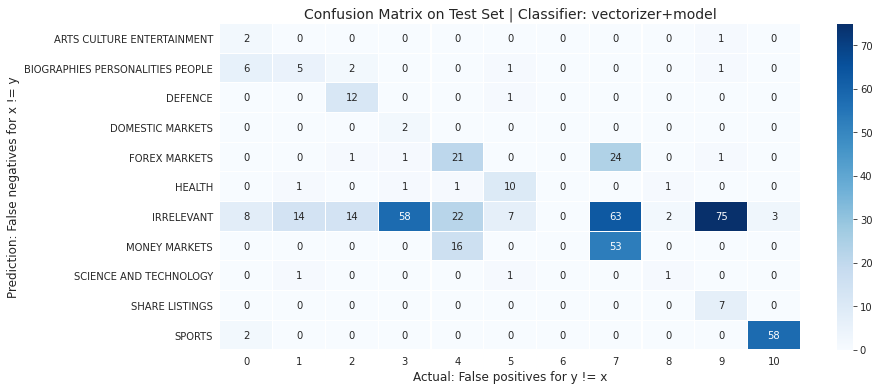

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_50
F1 score for  Pipeline  model is  0.3880420263098097
Accuracy score for  Pipeline  model is  0.35
Recall score for  Pipeline  model is  0.7136615196397804 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      1.00      0.33         3
           1       0.53      0.67      0.59        15
           2       0.29      0.92      0.44        13
           3       0.03      1.00      0.07         2
           4       0.30      0.48      0.37        48
           5       0.48      0.79      0.59        14
           6       0.00      0.00      0.00       266
           7

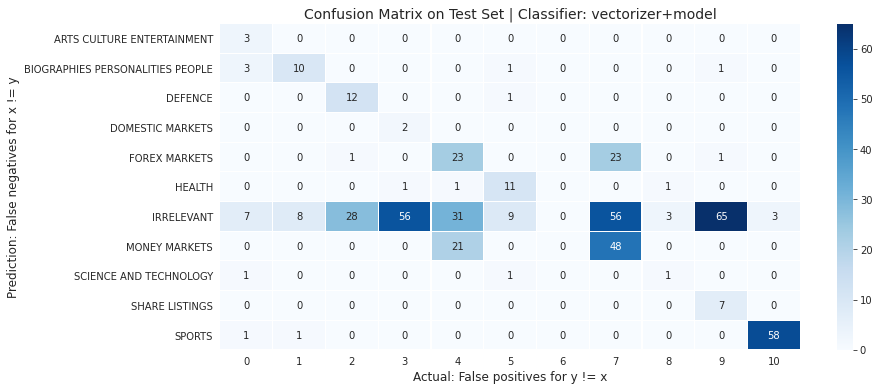

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_100
F1 score for  Pipeline  model is  0.2138179390232821
Accuracy score for  Pipeline  model is  0.568
Recall score for  Pipeline  model is  0.19018685357358125 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       1.00      0.31      0.47        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        48
           5       1.00      0.14      0.25        14
           6       0.56      0.94      0.71       266
         

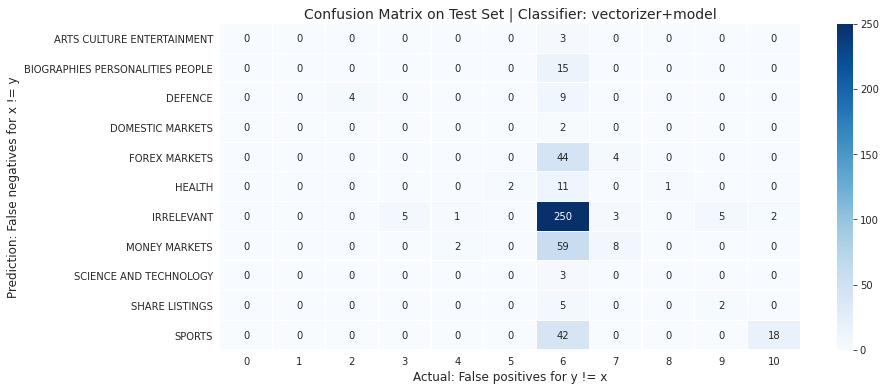

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_full
F1 score for  Pipeline  model is  0.06620106562247353
Accuracy score for  Pipeline  model is  0.534
Recall score for  Pipeline  model is  0.09242424242424242 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        14
           6       0.53      1.00      0.70       266
       

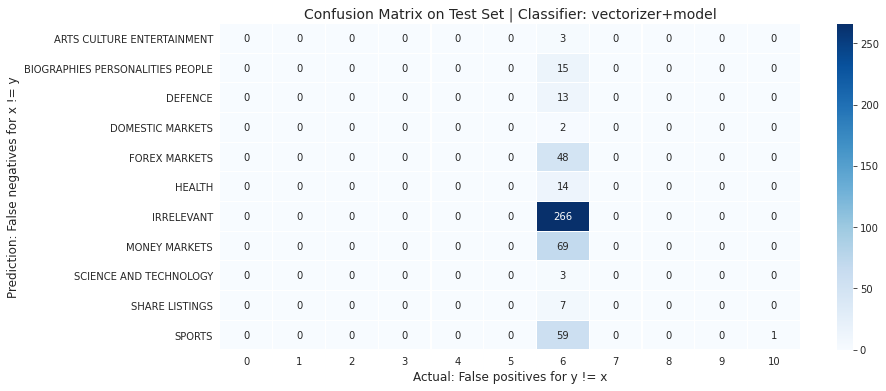

*************************************************************
Now the training set is df_train_100, and the model chosen is tfidf_clf_NB
The accuracy is 0.8981064535009441
----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_20
F1 score for  Pipeline  model is  0.3625522527186632
Accuracy score for  Pipeline  model is  0.342
Recall score for  Pipeline  model is  0.6285777628168933 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.33      0.15         3
           1       0.29      0.40      0.33        15
           2       0.36      0.92      0.52        13
           3       0.04      1.00      0.07         2


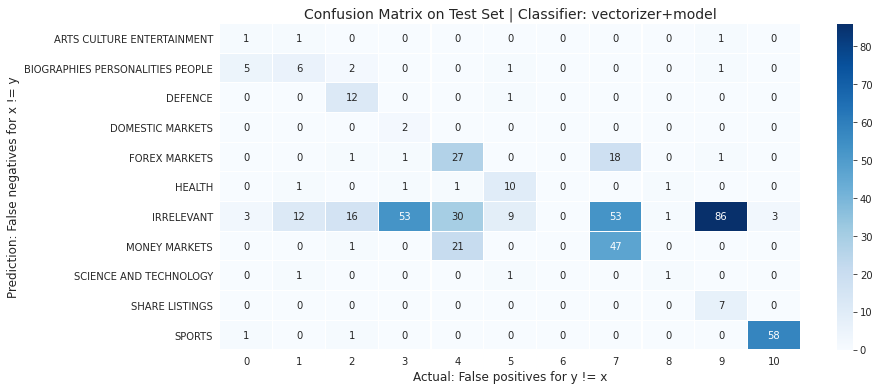

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_50
F1 score for  Pipeline  model is  0.37488683667963624
Accuracy score for  Pipeline  model is  0.352
Recall score for  Pipeline  model is  0.6752227844619149 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.41      0.47      0.44        15
           2       0.28      0.92      0.43        13
           3       0.04      1.00      0.07         2
           4       0.33      0.60      0.43        48
           5       0.46      0.79      0.58        14
           6       0.00      0.00      0.00       266
         

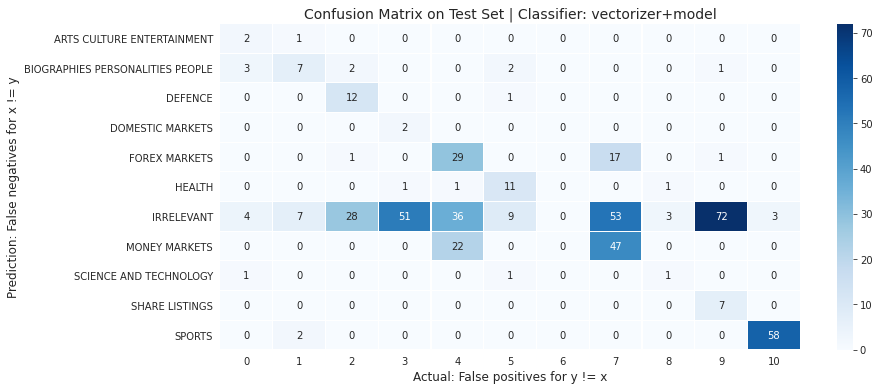

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_100
F1 score for  Pipeline  model is  0.3898170695836243
Accuracy score for  Pipeline  model is  0.352
Recall score for  Pipeline  model is  0.6616075953032475 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.33      0.15         3
           1       0.53      0.67      0.59        15
           2       0.27      0.92      0.41        13
           3       0.04      1.00      0.08         2
           4       0.27      0.46      0.34        48
           5       0.43      0.86      0.57        14
           6       0.00      0.00      0.00       266
         

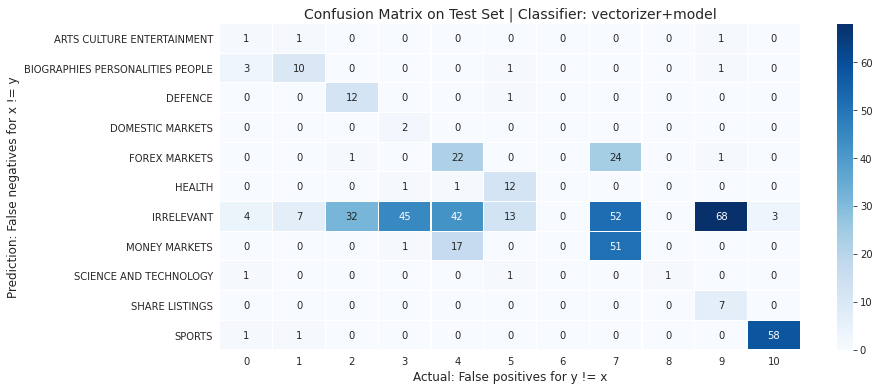

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_full
F1 score for  Pipeline  model is  0.06313790647994304
Accuracy score for  Pipeline  model is  0.532
Recall score for  Pipeline  model is  0.09090909090909091 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        14
           6       0.53      1.00      0.69       266
      

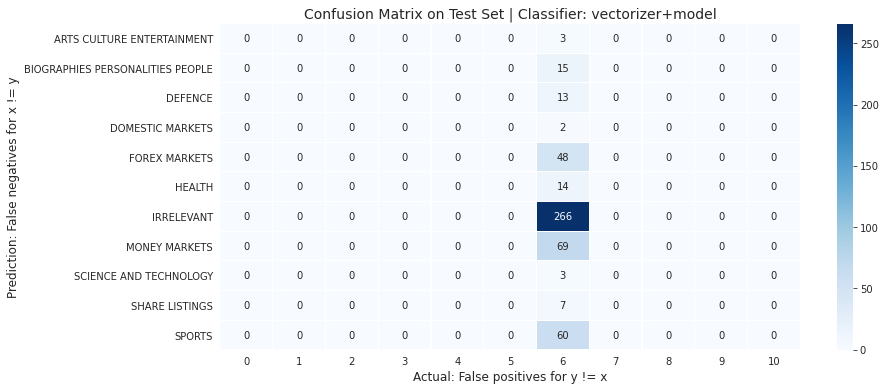

*************************************************************
Now the training set is df_train_full, and the model chosen is tfidf_clf_NB
The accuracy is 0.9623997900144465
----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_20
F1 score for  Pipeline  model is  0.3835806267089689
Accuracy score for  Pipeline  model is  0.376
Recall score for  Pipeline  model is  0.6176228805519424 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.50      0.20      0.29        15
           2       0.44      0.92      0.60        13
           3       0.04      1.00      0.08         

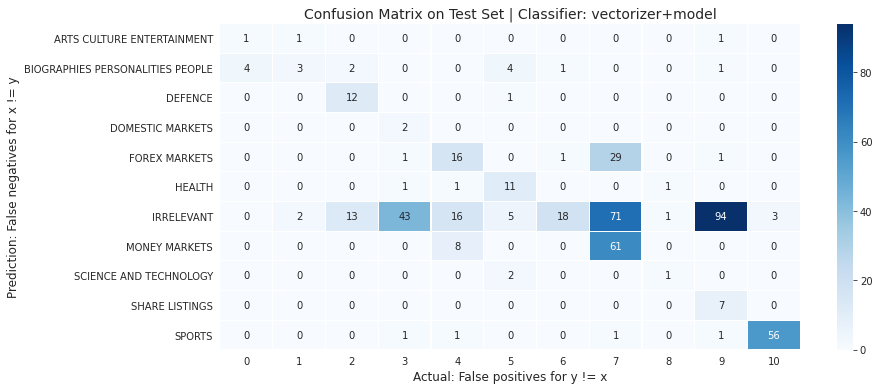

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_50
F1 score for  Pipeline  model is  0.3575456353313808
Accuracy score for  Pipeline  model is  0.362
Recall score for  Pipeline  model is  0.5971740502060868 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.38      0.20      0.26        15
           2       0.27      0.85      0.41        13
           3       0.05      1.00      0.09         2
           4       0.33      0.29      0.31        48
           5       0.56      0.71      0.63        14
           6       0.85      0.06      0.12       266
         

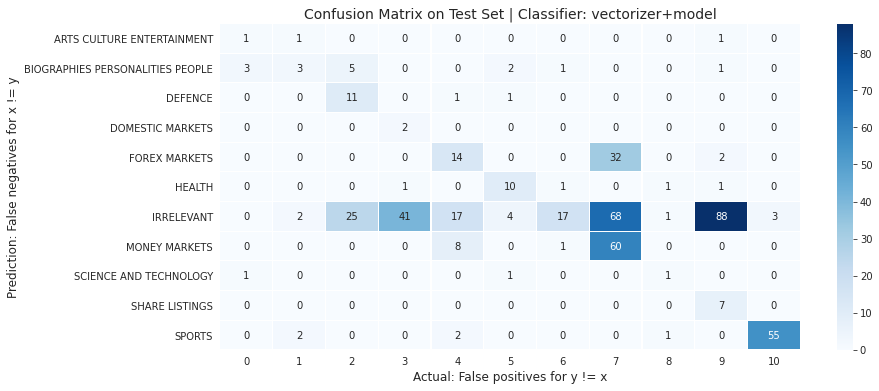

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_100
F1 score for  Pipeline  model is  0.40439636005509955
Accuracy score for  Pipeline  model is  0.414
Recall score for  Pipeline  model is  0.6327242646750656 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.56      0.33      0.42        15
           2       0.32      0.85      0.47        13
           3       0.05      1.00      0.10         2
           4       0.39      0.31      0.35        48
           5       0.52      0.86      0.65        14
           6       0.88      0.14      0.24       266
       

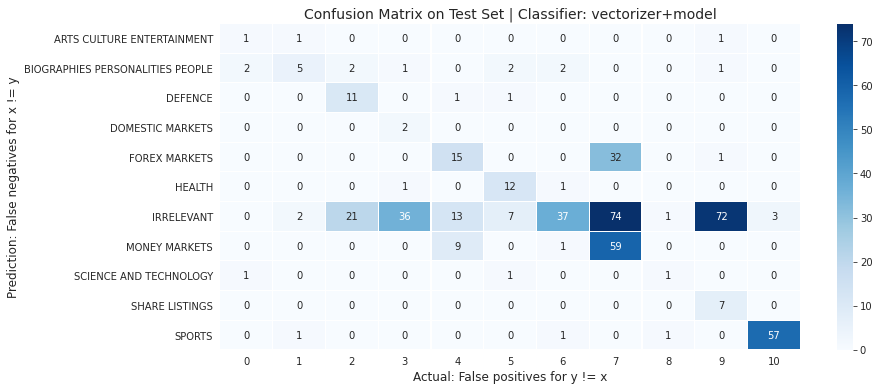

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_full
F1 score for  Pipeline  model is  0.4556854016224356
Accuracy score for  Pipeline  model is  0.724
Recall score for  Pipeline  model is  0.4394210671098543 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       1.00      0.13      0.24        15
           2       0.86      0.46      0.60        13
           3       0.33      0.50      0.40         2
           4       0.36      0.33      0.34        48
           5       0.86      0.43      0.57        14
           6       0.82      0.84      0.83       266
       

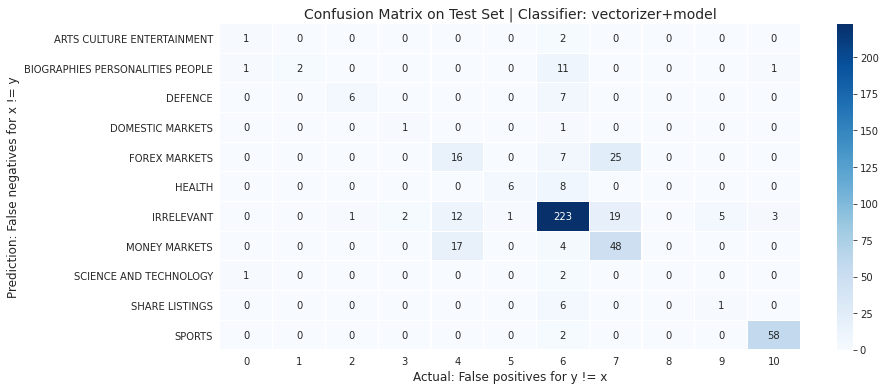

CPU times: user 5min 17s, sys: 2min 5s, total: 7min 22s
Wall time: 2h 48min 27s


In [114]:
%%time
for train_df in df_train_all:
    clf_NB,le,encode_mapping = get_model(train_df)
    for test_df in df_test_all:
        if (test_df.isnull().values.any()):
            continue
        print('----------------------------------------------------------------------')
        print(f'Now, the train_df is {train_df.name}, the test_df is {test_df.name}')
        test_model(test_df,clf_NB,le,encode_mapping)

*************************************************************
Now the training set is df_train_10, and the model chosen is count_clf_NB
The accuracy is 0.7857088870972166
----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_20
F1 score for  Pipeline  model is  0.43435680880439537
Accuracy score for  Pipeline  model is  0.532
Recall score for  Pipeline  model is  0.5419790545076585 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.19      1.00      0.32         3
           1       0.30      0.20      0.24        15
           2       0.62      0.62      0.62        13
           3       0.04      0.50      0.07         2
 

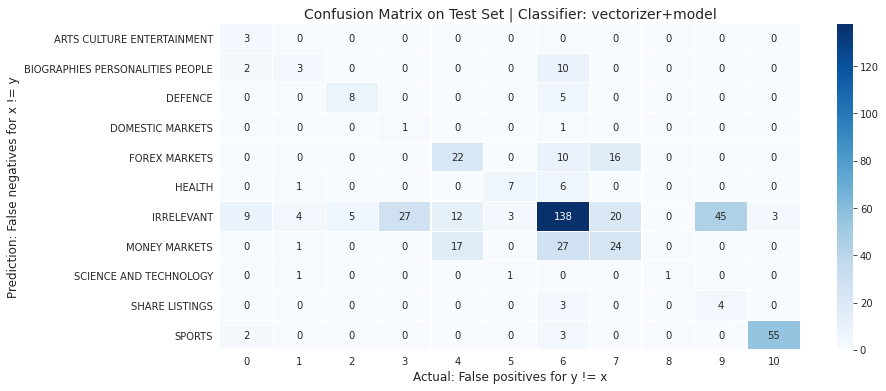

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_50
F1 score for  Pipeline  model is  0.1656156867280411
Accuracy score for  Pipeline  model is  0.562
Recall score for  Pipeline  model is  0.15319276451999564 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.50      0.08      0.14        48
           5       0.40      0.14      0.21        14
           6       0.56      0.94      0.70       266
          

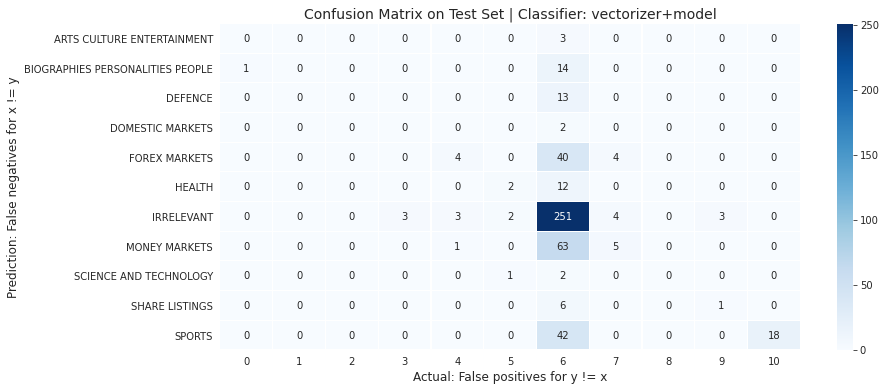

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_100
F1 score for  Pipeline  model is  0.10619474403847445
Accuracy score for  Pipeline  model is  0.554
Recall score for  Pipeline  model is  0.11390865998989566 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       1.00      0.02      0.04        48
           5       1.00      0.07      0.13        14
           6       0.55      1.00      0.71       266
        

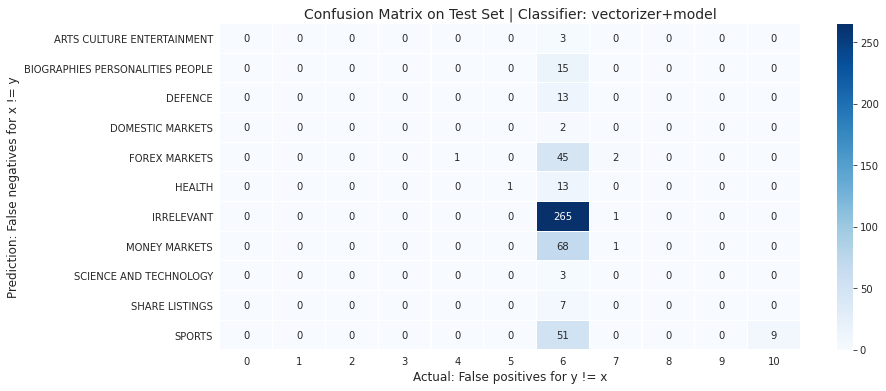

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_full
F1 score for  Pipeline  model is  0.08021978021978023
Accuracy score for  Pipeline  model is  0.544
Recall score for  Pipeline  model is  0.09980237154150197 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        14
           6       0.54      1.00      0.70       266
       

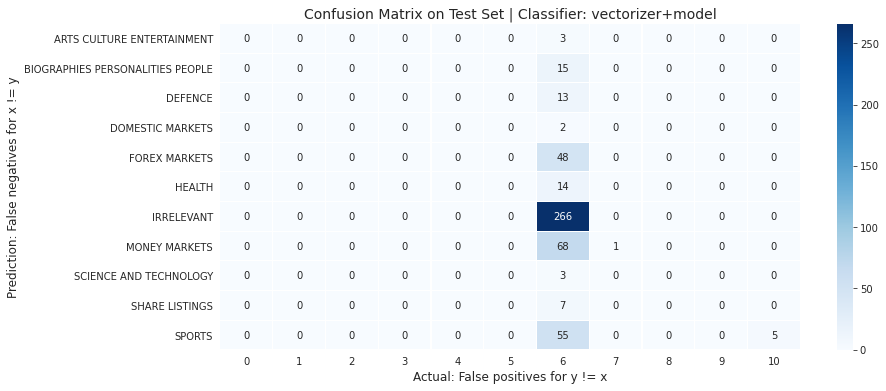

*************************************************************
Now the training set is df_train_20, and the model chosen is tfidf_clf_NB
The accuracy is 0.8220223123663436
----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_20
F1 score for  Pipeline  model is  0.37526295423038847
Accuracy score for  Pipeline  model is  0.354
Recall score for  Pipeline  model is  0.6994981467807554 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.13      1.00      0.23         3
           1       0.18      0.33      0.23        15
           2       0.39      0.92      0.55        13
           3       0.04      1.00      0.07         2
 

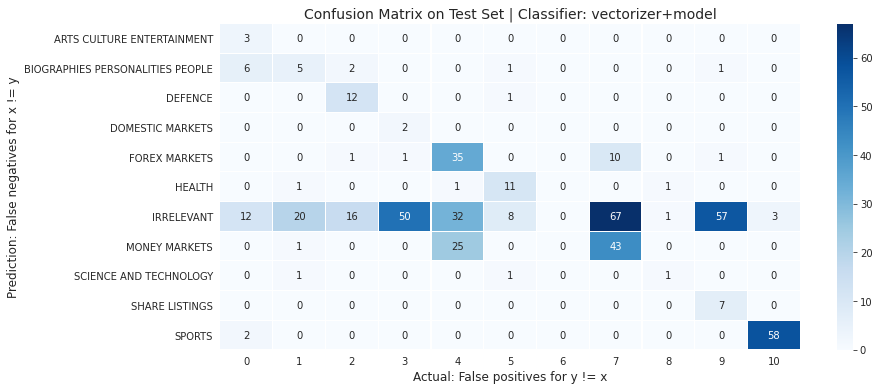

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_50
F1 score for  Pipeline  model is  0.1502665781664329
Accuracy score for  Pipeline  model is  0.53
Recall score for  Pipeline  model is  0.14952041665428392 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       1.00      0.02      0.04        48
           5       0.00      0.00      0.00        14
           6       0.53      0.97      0.69       266
           

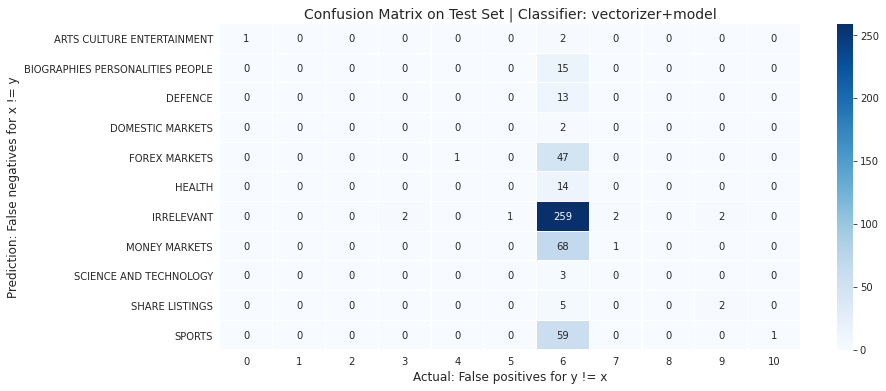

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_100
F1 score for  Pipeline  model is  0.06313790647994304
Accuracy score for  Pipeline  model is  0.532
Recall score for  Pipeline  model is  0.09090909090909091 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        14
           6       0.53      1.00      0.69       266
        

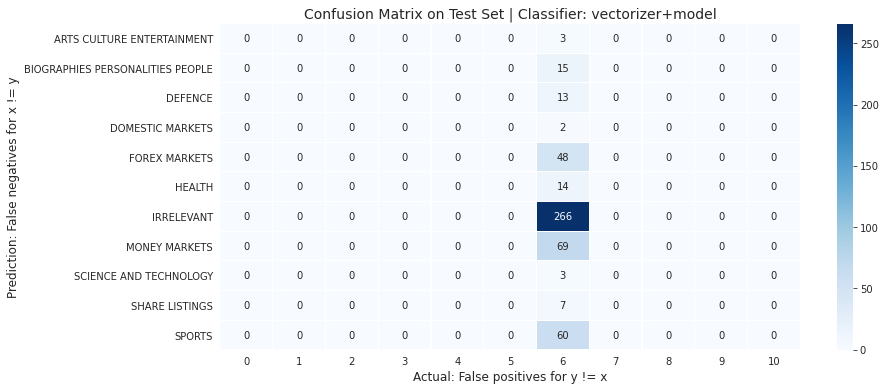

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_full
F1 score for  Pipeline  model is  0.06313790647994304
Accuracy score for  Pipeline  model is  0.532
Recall score for  Pipeline  model is  0.09090909090909091 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        14
           6       0.53      1.00      0.69       266
       

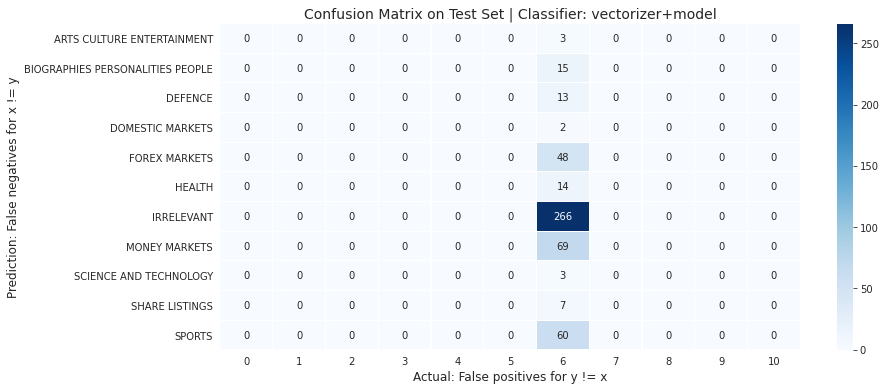

*************************************************************
Now the training set is df_train_50, and the model chosen is tfidf_clf_NB
The accuracy is 0.8612937409672728
----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_20
F1 score for  Pipeline  model is  0.37082509186799206
Accuracy score for  Pipeline  model is  0.348
Recall score for  Pipeline  model is  0.7101536145014407 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.12      1.00      0.22         3
           1       0.28      0.53      0.36        15
           2       0.43      0.92      0.59        13
           3       0.04      1.00      0.08         2
 

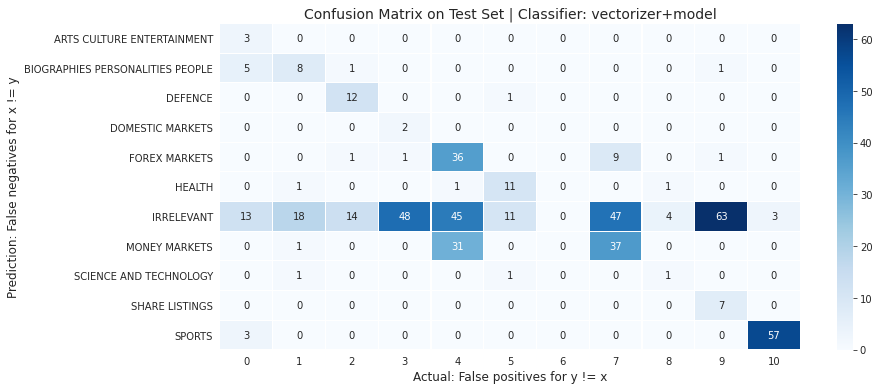

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_50
F1 score for  Pipeline  model is  0.3900036351119633
Accuracy score for  Pipeline  model is  0.362
Recall score for  Pipeline  model is  0.7230888676540851 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.18      1.00      0.30         3
           1       0.48      0.73      0.58        15
           2       0.27      0.92      0.42        13
           3       0.04      1.00      0.08         2
           4       0.33      0.79      0.47        48
           5       0.52      0.79      0.63        14
           6       0.00      0.00      0.00       266
           

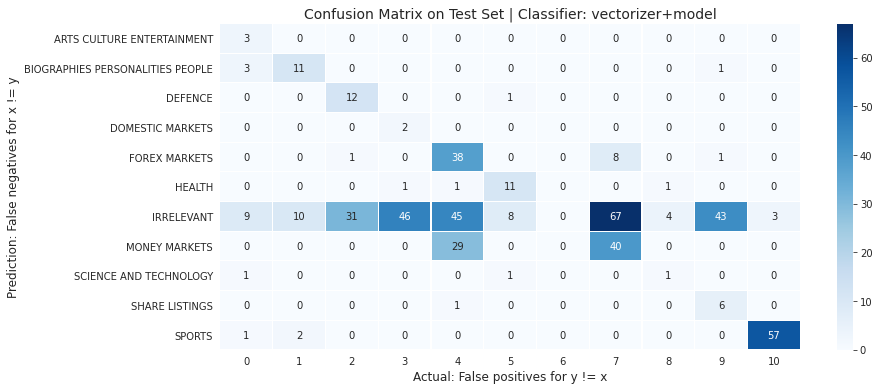

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_100
F1 score for  Pipeline  model is  0.3015443379857046
Accuracy score for  Pipeline  model is  0.582
Recall score for  Pipeline  model is  0.3001310379170791 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.07      0.12        15
           2       0.83      0.38      0.53        13
           3       0.08      0.50      0.14         2
           4       0.38      0.06      0.11        48
           5       1.00      0.29      0.44        14
           6       0.58      0.90      0.70       266
          

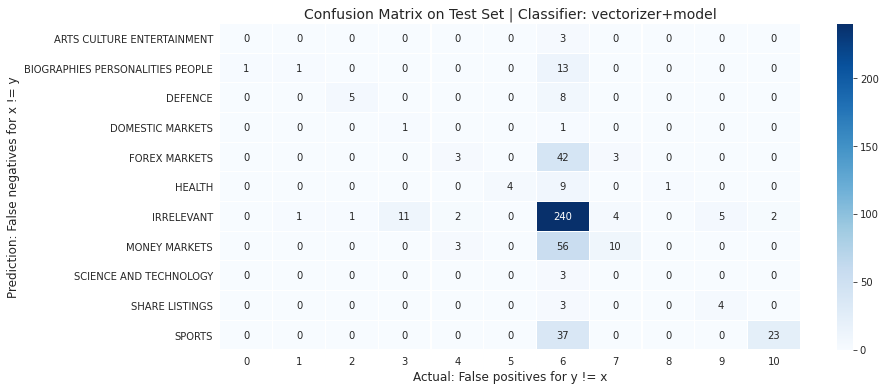

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_full
F1 score for  Pipeline  model is  0.06620106562247353
Accuracy score for  Pipeline  model is  0.534
Recall score for  Pipeline  model is  0.09242424242424242 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        14
           6       0.53      1.00      0.70       266
       

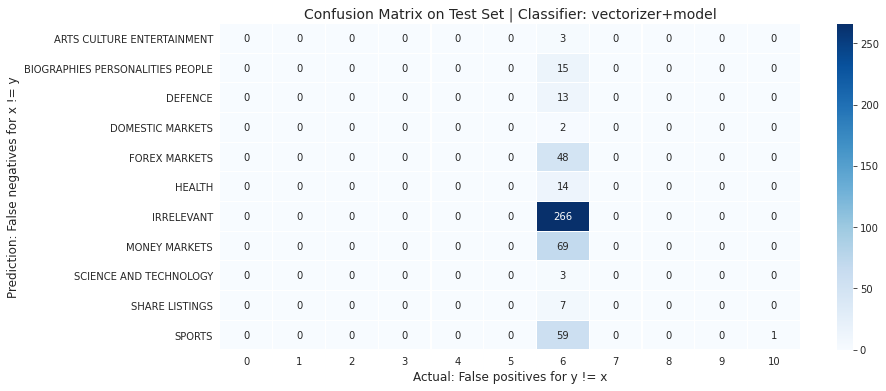

*************************************************************
Now the training set is df_train_100, and the model chosen is count_clf_NB
The accuracy is 0.8833966453937554
----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_20
F1 score for  Pipeline  model is  0.3761376356222168
Accuracy score for  Pipeline  model is  0.344
Recall score for  Pipeline  model is  0.7023425849512805 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.16      1.00      0.27         3
           1       0.28      0.53      0.36        15
           2       0.40      0.92      0.56        13
           3       0.04      1.00      0.07         2


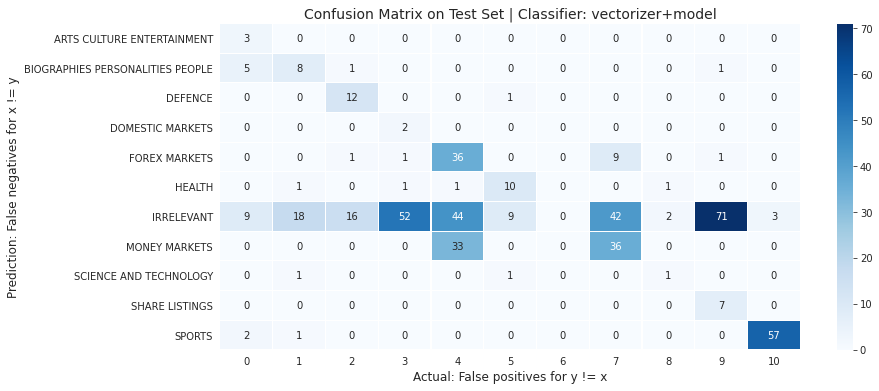

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_50
F1 score for  Pipeline  model is  0.40725795417582966
Accuracy score for  Pipeline  model is  0.364
Recall score for  Pipeline  model is  0.7362735090995961 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.23      1.00      0.38         3
           1       0.46      0.73      0.56        15
           2       0.26      0.92      0.41        13
           3       0.04      1.00      0.08         2
           4       0.34      0.79      0.47        48
           5       0.46      0.79      0.58        14
           6       0.00      0.00      0.00       266
         

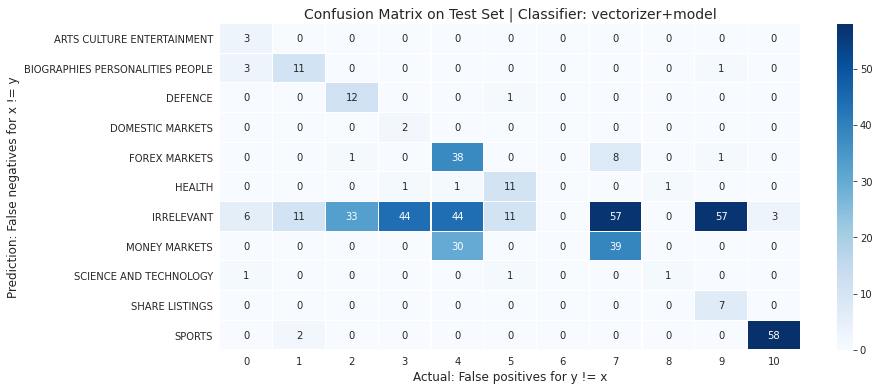

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_100
F1 score for  Pipeline  model is  0.39857311733366657
Accuracy score for  Pipeline  model is  0.364
Recall score for  Pipeline  model is  0.7303775934210716 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      1.00      0.33         3
           1       0.50      0.67      0.57        15
           2       0.27      0.92      0.41        13
           3       0.05      1.00      0.09         2
           4       0.32      0.75      0.45        48
           5       0.37      0.79      0.50        14
           6       0.00      0.00      0.00       266
        

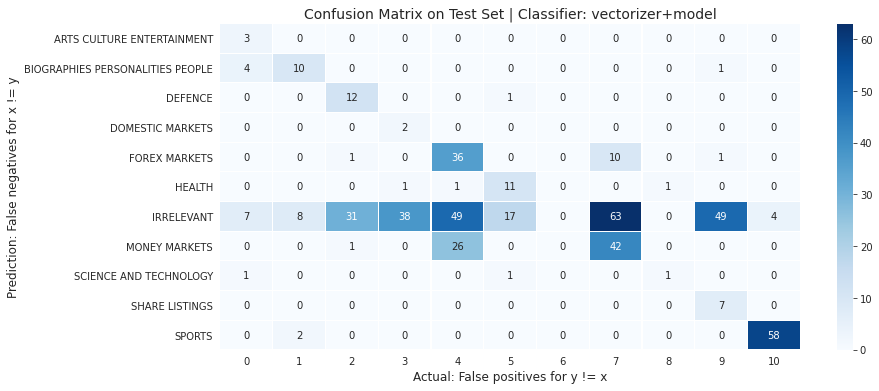

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_full
F1 score for  Pipeline  model is  0.12026269831788888
Accuracy score for  Pipeline  model is  0.542
Recall score for  Pipeline  model is  0.12707509881422926 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        14
           6       0.54      1.00      0.70       266
      

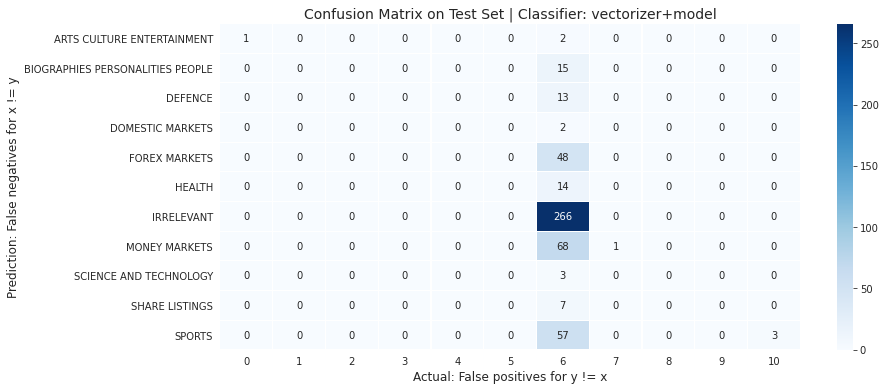

*************************************************************
Now the training set is train_df, and the model chosen is tfidf_clf_NB
The accuracy is 0.9308484280731626
----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_20
F1 score for  Pipeline  model is  0.38281620753617335
Accuracy score for  Pipeline  model is  0.35
Recall score for  Pipeline  model is  0.6782237404090952 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.50      0.53      0.52        15
           2       0.29      0.92      0.44        13
           3       0.04      1.00      0.07         2
   

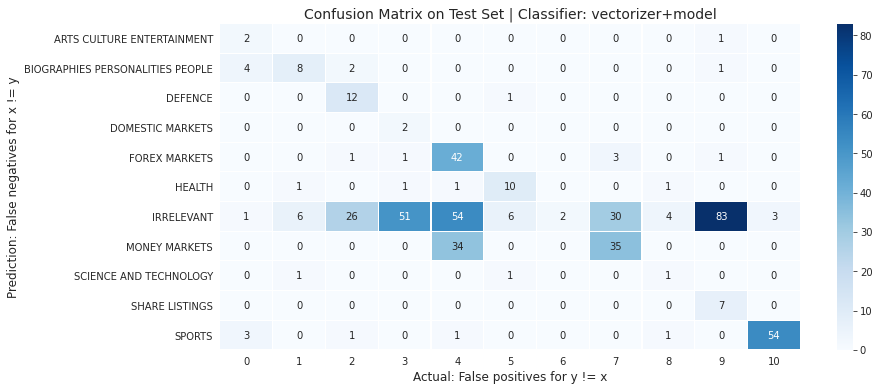

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_50
F1 score for  Pipeline  model is  0.41275263275911606
Accuracy score for  Pipeline  model is  0.36
Recall score for  Pipeline  model is  0.7108860533059618 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       0.57      0.53      0.55        15
           2       0.24      0.92      0.38        13
           3       0.04      1.00      0.08         2
           4       0.31      0.85      0.45        48
           5       0.56      0.71      0.63        14
           6       0.83      0.02      0.04       266
         

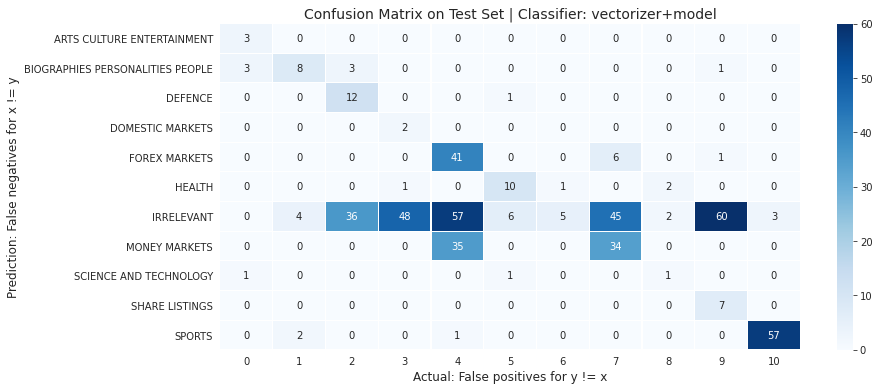

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_100
F1 score for  Pipeline  model is  0.43908160786305644
Accuracy score for  Pipeline  model is  0.422
Recall score for  Pipeline  model is  0.6996227170998338 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.62      0.53      0.57        15
           2       0.26      0.92      0.41        13
           3       0.05      1.00      0.09         2
           4       0.32      0.85      0.46        48
           5       0.58      0.79      0.67        14
           6       0.92      0.13      0.22       266
       

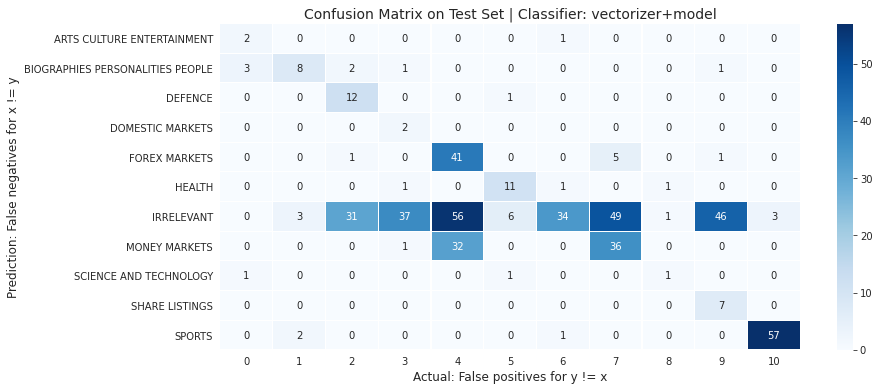

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_full
F1 score for  Pipeline  model is  0.5812766414258494
Accuracy score for  Pipeline  model is  0.724
Recall score for  Pipeline  model is  0.6403599737409805 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.83      0.33      0.48        15
           2       0.56      0.77      0.65        13
           3       0.11      0.50      0.18         2
           4       0.41      0.69      0.52        48
           5       0.76      0.93      0.84        14
           6       0.91      0.72      0.81       266
       

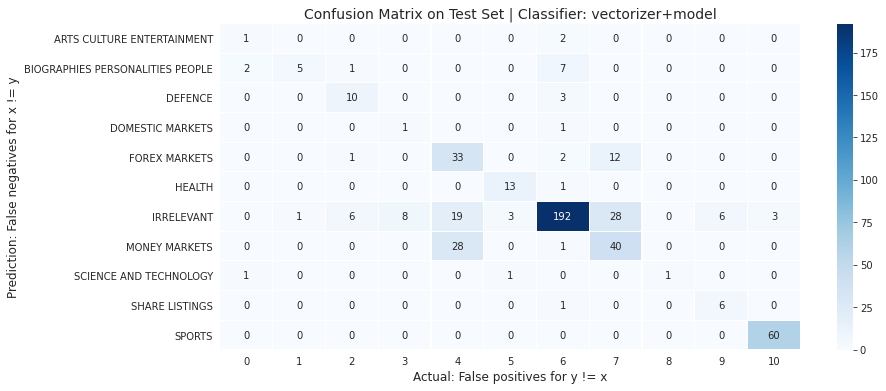

CPU times: user 3min 22s, sys: 12.1 s, total: 3min 34s
Wall time: 1h 5min


In [115]:
%%time
for train_df in df_train_all:
    clf_NB,le,encode_mapping = get_model_2(train_df)
    for test_df in df_test_all:
        if (test_df.isnull().values.any()):
            continue
        print('----------------------------------------------------------------------')
        print(f'Now, the train_df is {train_df.name}, the test_df is {test_df.name}')
        test_model(test_df,clf_NB,le,encode_mapping)

# Two Layer Model Test

In [19]:
TRAINING_FILE = "../keyword.csv"
TEST_FILE = "../key_word_test.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
print(df_train.isnull().sum())
df_train.head(5)

Unnamed: 0         0
article_number     0
article_words      0
topic              0
IR_binary          0
key_word_10       62
key_word_20       18
key_word_50        0
key_word_100       0
dtype: int64


Unnamed: 0  article_number  \
0           0               1   
1           1               2   
2           2               3   
3           3               4   
4           4               5   

                                       article_words          topic  \
0  open,absent,cent,cent,cent,stock,inflow,rate,k...  FOREX MARKETS   
1  morn,stead,end,end,day,day,day,patch,patch,pat...  MONEY MARKETS   
2  socc,socc,world,world,recent,law,fifa,fifa,fif...         SPORTS   
3  open,forint,forint,forint,forint,cent,cent,ste...  FOREX MARKETS   
4  morn,complet,weekend,minut,minut,minut,arrow,d...     IRRELEVANT   

   IR_binary                                        key_word_10  \
0      False  stock,rate,defend,bank,bank,bank,bank,bank,dol...   
1      False  day,day,day,bank,year,dollar,dollar,deal,deal,...   
2      False  world,world,stat,stat,stat,stat,year,releas,re...   
3      False  play,bank,bank,mark,mark,percent,percent,perce...   
4       True                                                day   

                                         key_word_20  \
0  cent,cent,cent,stock,rate,end,won,won,won,won,...   
1  end,end,day,day,day,point,time,bank,year,dolla...   
2  world,world,stat,stat,stat,stat,govern,time,ye...   
3  cent,cent,end,play,unit,bank,bank,mark,mark,pe...   
4                               day,time,season,clos   

                                         key_word_50  \
0  open,cent,cent,cent,stock,rate,end,won,won,won...   
1  end,end,day,day,day,point,time,bank,early,year...   
2  socc,socc,world,world,stat,stat,stat,stat,gove...   
3  open,cent,cent,end,play,unit,made,bank,bank,tu...   
4  minut,minut,minut,day,friday,friday,race,time,...   

                                        key_word_100  
0  open,cent,cent,cent,stock,rate,end,won,won,won...  
1  end,end,day,day,day,index,point,time,busi,bank...  
2  socc,socc,world,world,recent,law,stat,stat,sta...  
3  open,cent,cent,end,play,unit,made,bank,bank,ra...  
4  minut,minut,minut,day,friday,friday,race,time,...

In [20]:
rel_count_clf_NB = retrieve_variable('rel_count_clf_NB')

## Find The Best Model for Relevant Features

In [21]:
df_train = df_train[df_train.topic!="IRRELEVANT"]
df_test = df_test[df_test.topic!="IRRELEVANT"]

In [22]:
# Separate out training sets with different size of keywords in the training set
df_train_10 = pd.DataFrame(df_train,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_train_10.name = 'df_train_10'
df_train_20 = pd.DataFrame(df_train,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_train_20.name = 'df_train_20'
df_train_50 = pd.DataFrame(df_train,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_train_50.name = 'df_train_50'
df_train_100 = pd.DataFrame(df_train,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_train_100.name = 'df_train_100'
df_train_full = pd.DataFrame(df_train,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_train_full.name = 'df_train_full'
df_train_all = [df_train_10,df_train_20,df_train_50,df_train_100,df_train_full]

In [23]:
# Separate out training sets with different size of keywords in the test set
df_test_10 = pd.DataFrame(df_test,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_test_10.name = 'df_test_10'
df_test_20 = pd.DataFrame(df_test,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_test_20.name = 'df_test_20'
df_test_50 = pd.DataFrame(df_test,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_test_50.name = 'df_test_50'
df_test_100 = pd.DataFrame(df_test,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_test_100.name = 'df_test_100'
df_test_full = pd.DataFrame(df_test,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_test_full.name = 'df_test_full'
df_test_all = [df_test_10,df_test_20,df_test_50,df_test_100,df_test_full]

*************************************************************
Now the training set is df_train_10, and the model chosen is count_clf_NB
The accuracy is 0.7792690233672858
----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_20
F1 score for  Pipeline  model is  0.6065718718964155
Accuracy score for  Pipeline  model is  0.7051282051282052
Recall score for  Pipeline  model is  0.6948172479694219 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.60      0.20      0.30        15
           2       0.69      0.85      0.76        13
           3       0.40      1.00      0.57         2
       

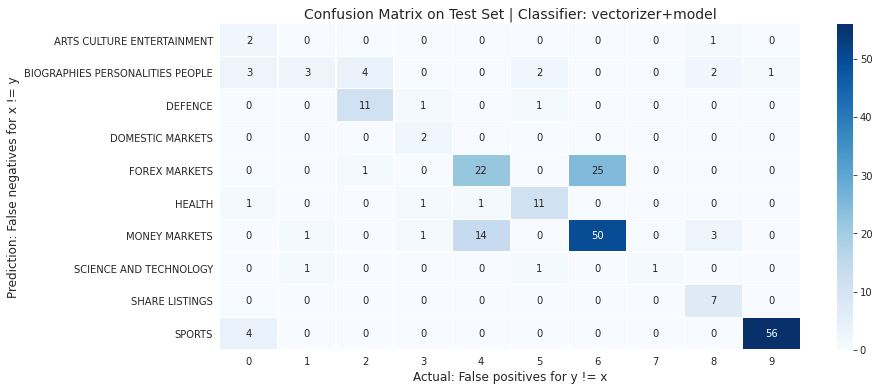

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_50
F1 score for  Pipeline  model is  0.6065718718964155
Accuracy score for  Pipeline  model is  0.7051282051282052
Recall score for  Pipeline  model is  0.6948172479694219 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.60      0.20      0.30        15
           2       0.69      0.85      0.76        13
           3       0.40      1.00      0.57         2
           4       0.59      0.46      0.52        48
           5       0.73      0.79      0.76        14
           6       0.67      0.72      0.69        69
           7    

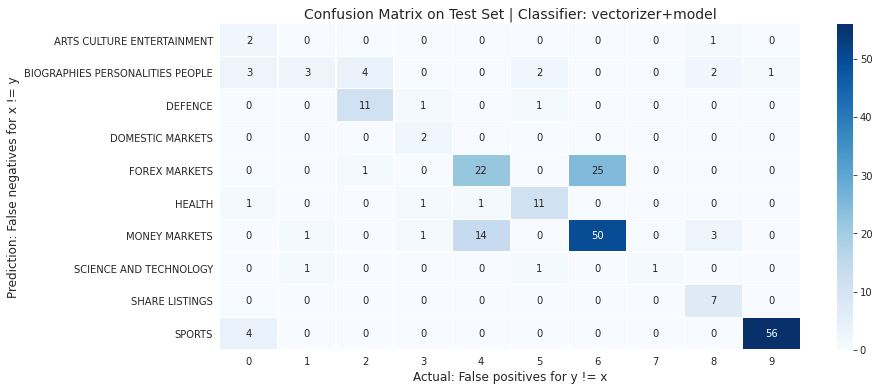

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_100
F1 score for  Pipeline  model is  0.6065718718964155
Accuracy score for  Pipeline  model is  0.7051282051282052
Recall score for  Pipeline  model is  0.6948172479694219 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.60      0.20      0.30        15
           2       0.69      0.85      0.76        13
           3       0.40      1.00      0.57         2
           4       0.59      0.46      0.52        48
           5       0.73      0.79      0.76        14
           6       0.67      0.72      0.69        69
           7   

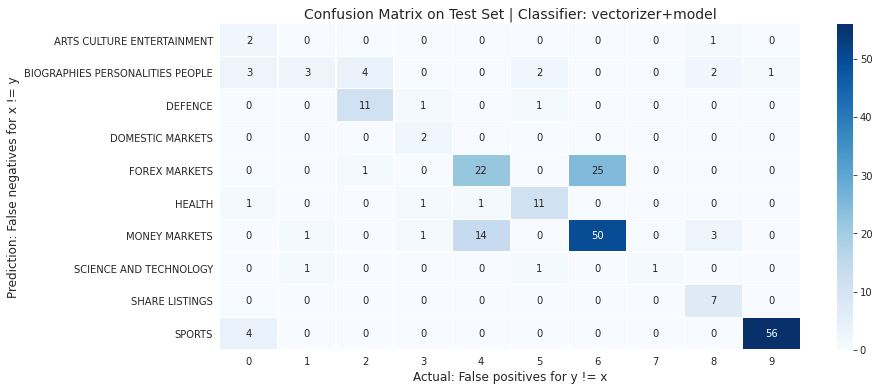

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_full
F1 score for  Pipeline  model is  0.6065718718964155
Accuracy score for  Pipeline  model is  0.7051282051282052
Recall score for  Pipeline  model is  0.6948172479694219 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.60      0.20      0.30        15
           2       0.69      0.85      0.76        13
           3       0.40      1.00      0.57         2
           4       0.59      0.46      0.52        48
           5       0.73      0.79      0.76        14
           6       0.67      0.72      0.69        69
           7  

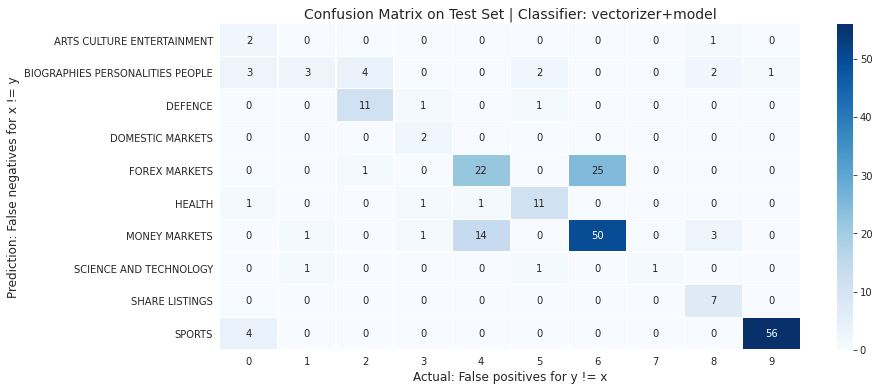

*************************************************************
Now the training set is df_train_20, and the model chosen is count_clf_NB
The accuracy is 0.8292887029288704
----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_20
F1 score for  Pipeline  model is  0.6598476143040749
Accuracy score for  Pipeline  model is  0.7350427350427351
Recall score for  Pipeline  model is  0.7163811912724957 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.71      0.33      0.45        15
           2       0.80      0.92      0.86        13
           3       0.67      1.00      0.80         2
       

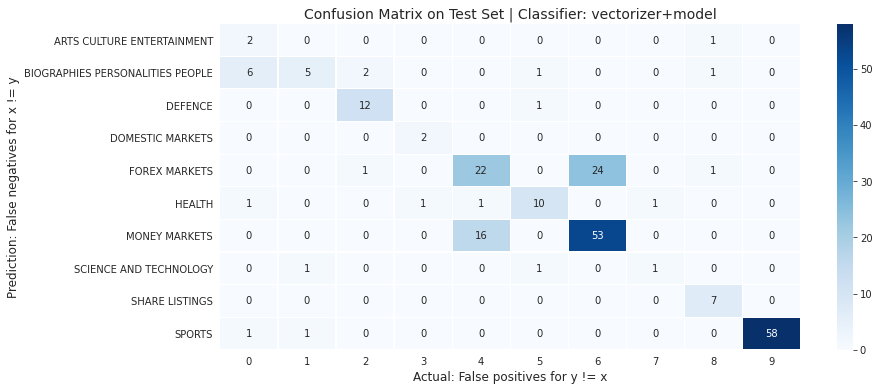

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_50
F1 score for  Pipeline  model is  0.6598476143040749
Accuracy score for  Pipeline  model is  0.7350427350427351
Recall score for  Pipeline  model is  0.7163811912724957 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.71      0.33      0.45        15
           2       0.80      0.92      0.86        13
           3       0.67      1.00      0.80         2
           4       0.56      0.46      0.51        48
           5       0.77      0.71      0.74        14
           6       0.69      0.77      0.73        69
           7    

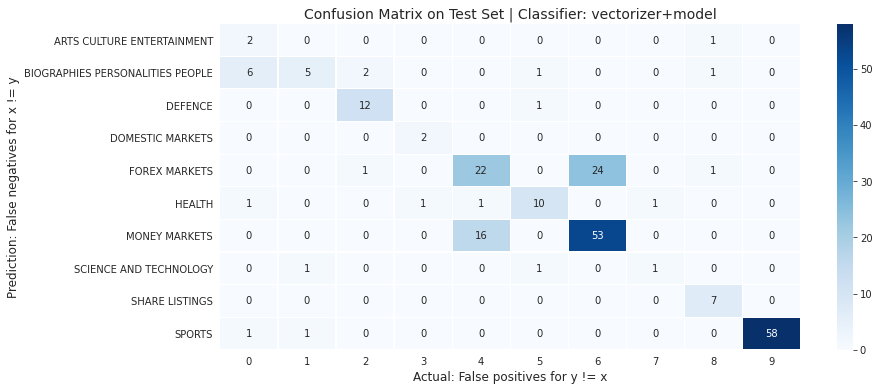

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_100
F1 score for  Pipeline  model is  0.6598476143040749
Accuracy score for  Pipeline  model is  0.7350427350427351
Recall score for  Pipeline  model is  0.7163811912724957 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.71      0.33      0.45        15
           2       0.80      0.92      0.86        13
           3       0.67      1.00      0.80         2
           4       0.56      0.46      0.51        48
           5       0.77      0.71      0.74        14
           6       0.69      0.77      0.73        69
           7   

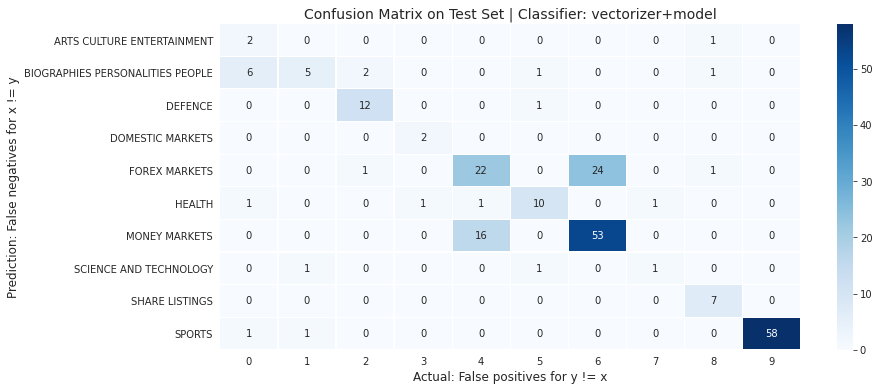

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_full
F1 score for  Pipeline  model is  0.6598476143040749
Accuracy score for  Pipeline  model is  0.7350427350427351
Recall score for  Pipeline  model is  0.7163811912724957 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.71      0.33      0.45        15
           2       0.80      0.92      0.86        13
           3       0.67      1.00      0.80         2
           4       0.56      0.46      0.51        48
           5       0.77      0.71      0.74        14
           6       0.69      0.77      0.73        69
           7  

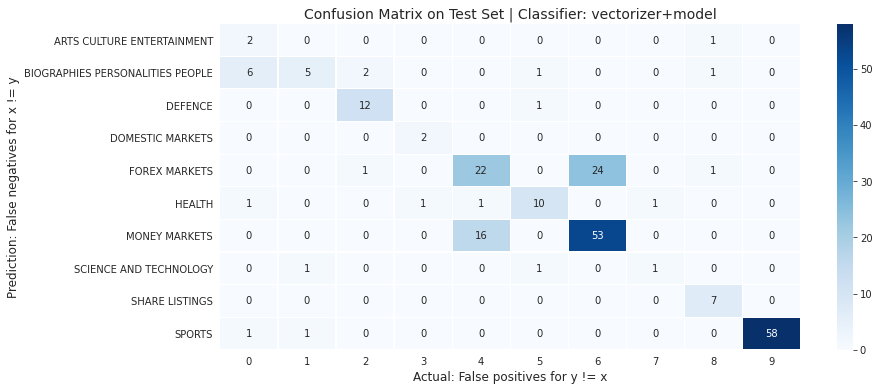

*************************************************************
Now the training set is df_train_50, and the model chosen is tfidf_clf_NB
The accuracy is 0.8735206216377766
----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_20
F1 score for  Pipeline  model is  0.6235561456683414
Accuracy score for  Pipeline  model is  0.7264957264957265
Recall score for  Pipeline  model is  0.6790623506927854 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.33      0.17         3
           1       0.62      0.33      0.43        15
           2       0.75      0.92      0.83        13
           3       0.50      1.00      0.67         2
       

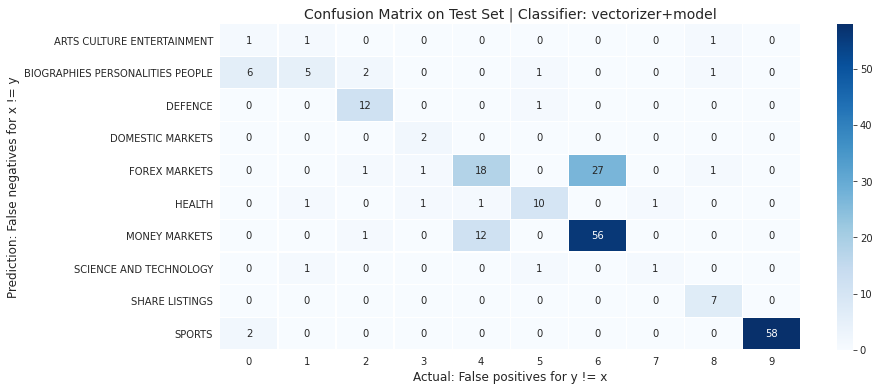

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_50
F1 score for  Pipeline  model is  0.694073483014161
Accuracy score for  Pipeline  model is  0.7264957264957265
Recall score for  Pipeline  model is  0.7387776716037585 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.82      0.60      0.69        15
           2       0.86      0.92      0.89        13
           3       0.67      1.00      0.80         2
           4       0.48      0.42      0.44        48
           5       0.79      0.79      0.79        14
           6       0.65      0.70      0.67        69
           7     

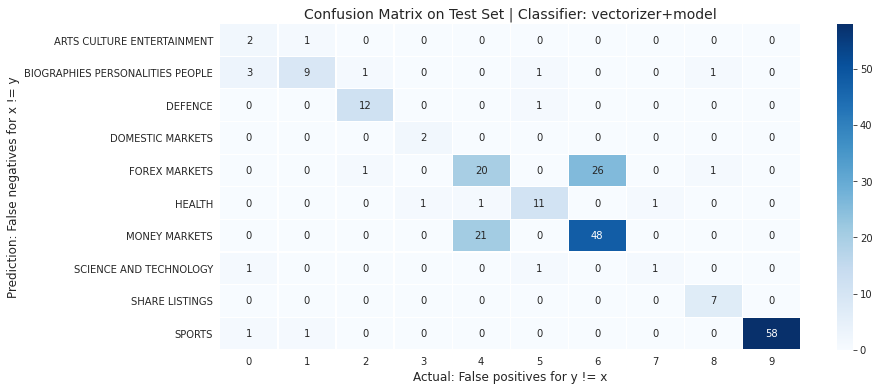

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_100
F1 score for  Pipeline  model is  0.694073483014161
Accuracy score for  Pipeline  model is  0.7264957264957265
Recall score for  Pipeline  model is  0.7387776716037585 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.82      0.60      0.69        15
           2       0.86      0.92      0.89        13
           3       0.67      1.00      0.80         2
           4       0.48      0.42      0.44        48
           5       0.79      0.79      0.79        14
           6       0.65      0.70      0.67        69
           7    

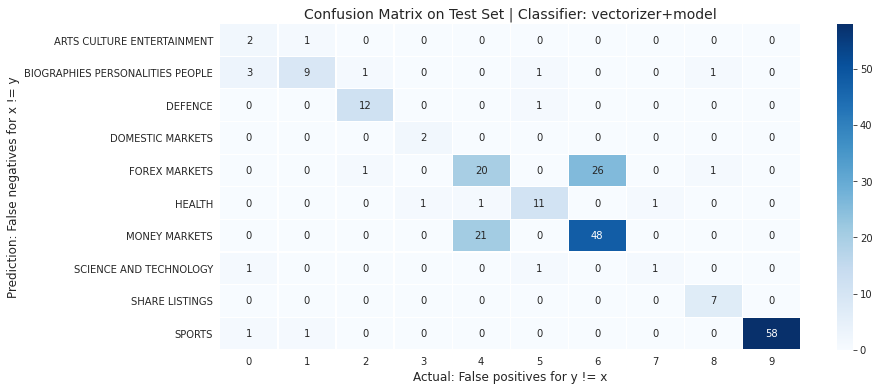

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_full
F1 score for  Pipeline  model is  0.694073483014161
Accuracy score for  Pipeline  model is  0.7264957264957265
Recall score for  Pipeline  model is  0.7387776716037585 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.82      0.60      0.69        15
           2       0.86      0.92      0.89        13
           3       0.67      1.00      0.80         2
           4       0.48      0.42      0.44        48
           5       0.79      0.79      0.79        14
           6       0.65      0.70      0.67        69
           7   

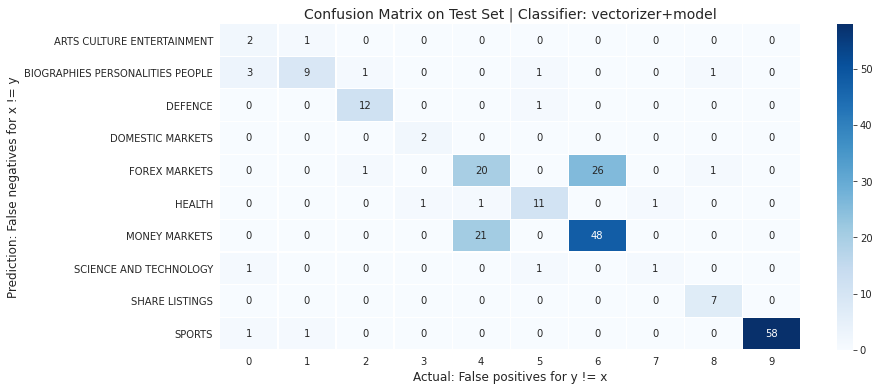

*************************************************************
Now the training set is df_train_100, and the model chosen is tfidf_clf_NB
The accuracy is 0.8800358637178721
----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_20
F1 score for  Pipeline  model is  0.64088941349642
Accuracy score for  Pipeline  model is  0.7393162393162394
Recall score for  Pipeline  model is  0.6938449593884377 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.33      0.22         3
           1       0.64      0.47      0.54        15
           2       0.75      0.92      0.83        13
           3       0.50      1.00      0.67         2
       

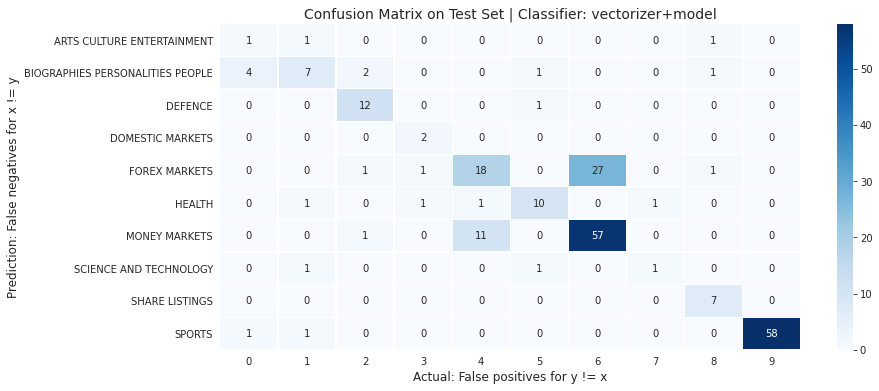

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_50
F1 score for  Pipeline  model is  0.6910498576375944
Accuracy score for  Pipeline  model is  0.7350427350427351
Recall score for  Pipeline  model is  0.7358247730530338 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.73      0.53      0.62        15
           2       0.80      0.92      0.86        13
           3       0.67      1.00      0.80         2
           4       0.51      0.40      0.45        48
           5       0.79      0.79      0.79        14
           6       0.66      0.75      0.70        69
           7   

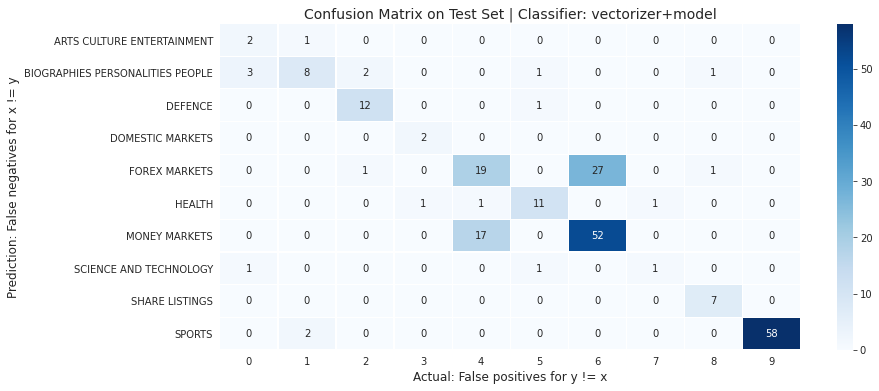

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_100
F1 score for  Pipeline  model is  0.6864944247316834
Accuracy score for  Pipeline  model is  0.7478632478632479
Recall score for  Pipeline  model is  0.7250509635292245 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.33      0.22         3
           1       0.83      0.67      0.74        15
           2       0.92      0.92      0.92        13
           3       0.50      1.00      0.67         2
           4       0.54      0.42      0.47        48
           5       0.80      0.86      0.83        14
           6       0.67      0.75      0.71        69
           7  

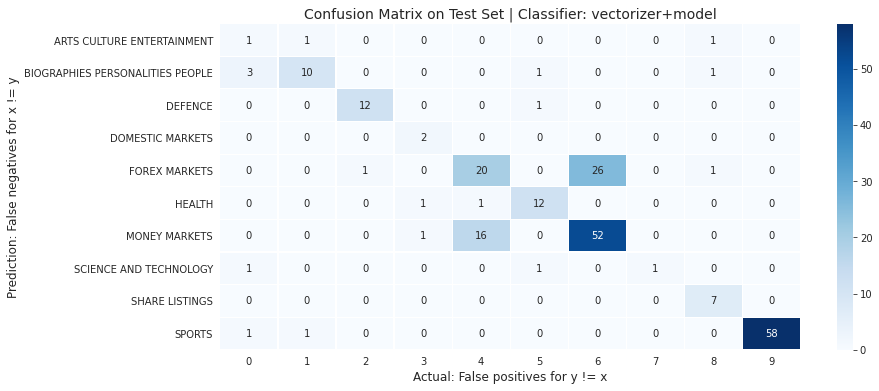

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_full
F1 score for  Pipeline  model is  0.6864944247316834
Accuracy score for  Pipeline  model is  0.7478632478632479
Recall score for  Pipeline  model is  0.7250509635292245 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.33      0.22         3
           1       0.83      0.67      0.74        15
           2       0.92      0.92      0.92        13
           3       0.50      1.00      0.67         2
           4       0.54      0.42      0.47        48
           5       0.80      0.86      0.83        14
           6       0.67      0.75      0.71        69
           7 

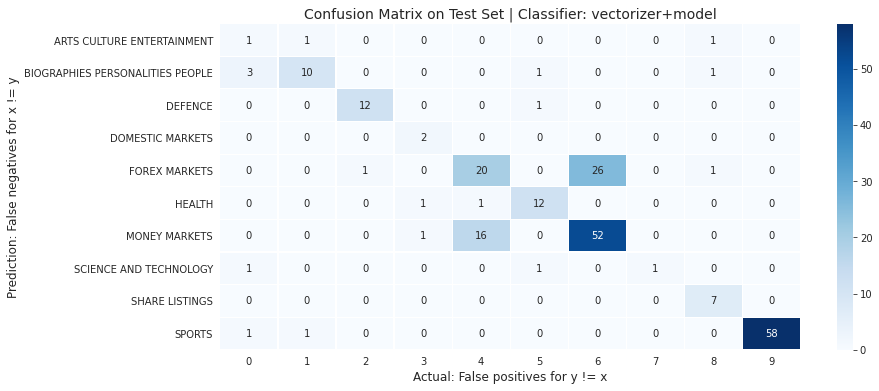

*************************************************************
Now the training set is df_train_full, and the model chosen is tfidf_clf_NB
The accuracy is 0.9479976090854751
----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_20
F1 score for  Pipeline  model is  0.5517323305685375
Accuracy score for  Pipeline  model is  0.6923076923076923
Recall score for  Pipeline  model is  0.6088139034878165 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.80      0.27      0.40        15
           2       0.80      0.92      0.86        13
           3       0.25      0.50      0.33         2
   

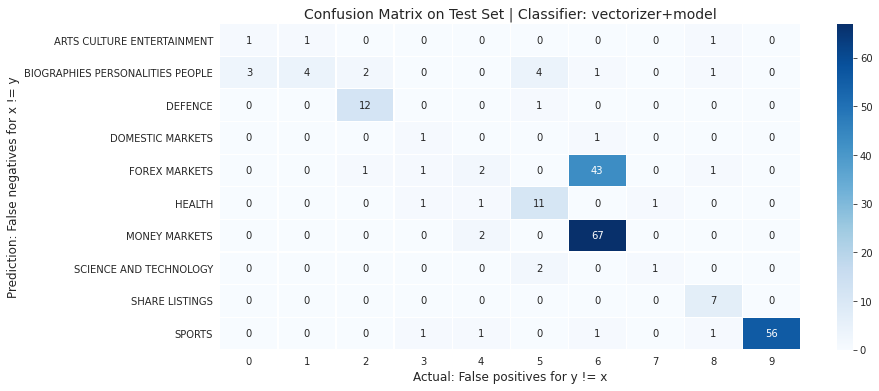

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_50
F1 score for  Pipeline  model is  0.6011891186128778
Accuracy score for  Pipeline  model is  0.7136752136752137
Recall score for  Pipeline  model is  0.6571127966236663 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.57      0.27      0.36        15
           2       0.69      0.85      0.76        13
           3       0.67      1.00      0.80         2
           4       0.60      0.19      0.29        48
           5       0.71      0.71      0.71        14
           6       0.63      0.96      0.76        69
           7  

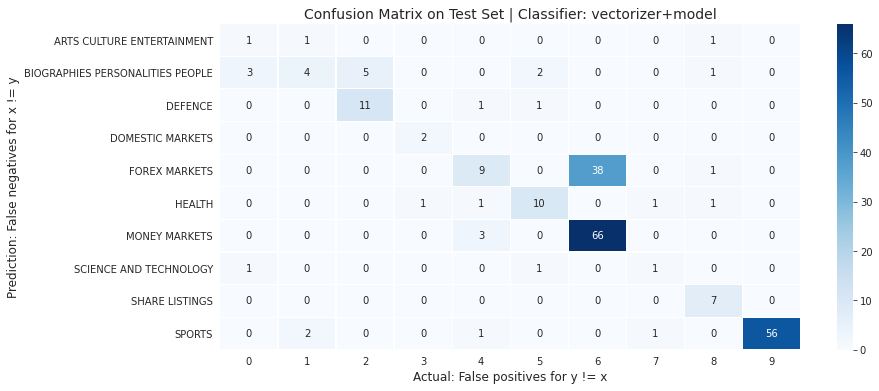

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_100
F1 score for  Pipeline  model is  0.6109527496753216
Accuracy score for  Pipeline  model is  0.7222222222222222
Recall score for  Pipeline  model is  0.6764166268514095 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.71      0.33      0.45        15
           2       0.79      0.85      0.81        13
           3       0.40      1.00      0.57         2
           4       0.57      0.17      0.26        48
           5       0.71      0.86      0.77        14
           6       0.62      0.93      0.74        69
           7 

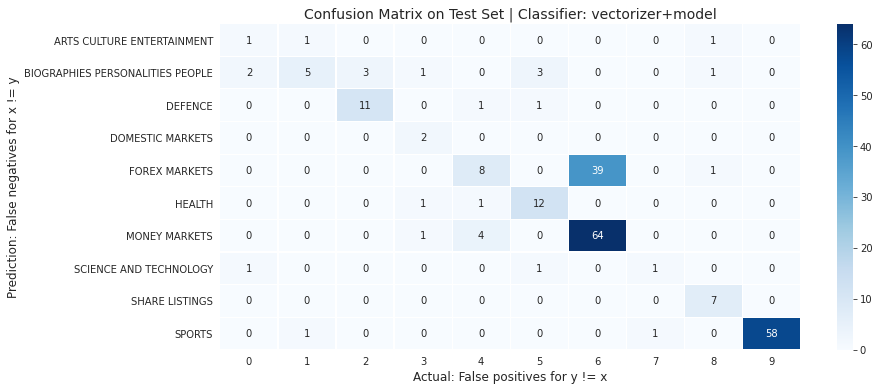

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_full
F1 score for  Pipeline  model is  0.6148285331821226
Accuracy score for  Pipeline  model is  0.717948717948718
Recall score for  Pipeline  model is  0.598677536231884 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.90      0.60      0.72        15
           2       0.72      1.00      0.84        13
           3       1.00      0.50      0.67         2
           4       0.46      0.27      0.34        48
           5       0.93      0.93      0.93        14
           6       0.60      0.78      0.68        69
           7  

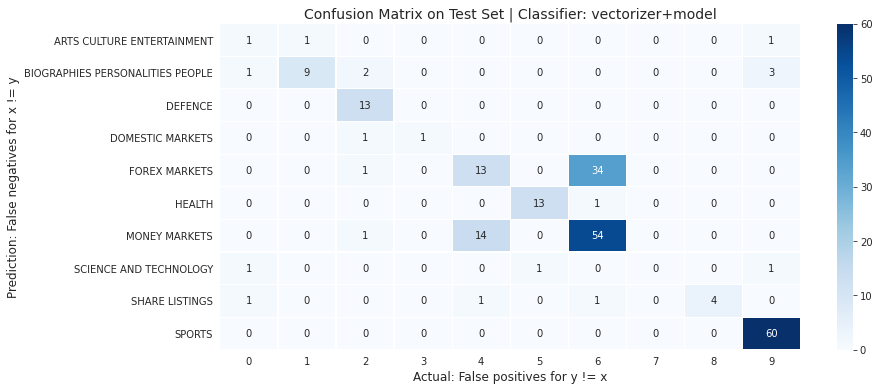

CPU times: user 1min 40s, sys: 28.7 s, total: 2min 9s
Wall time: 48min 57s


In [25]:
%%time
for train_df in df_train_all:
    clf_NB,le,encode_mapping = get_model(train_df)
    for test_df in df_test_all:
        if (test_df.isnull().values.any()):
            continue
        print('----------------------------------------------------------------------')
        print(f'Now, the train_df is {train_df.name}, the test_df is {test_df.name}')
        test_model(test_df,clf_NB,le,encode_mapping)

*************************************************************
Now the training set is df_train_10, and the model chosen is count_clf_NB
The accuracy is 0.762732174955063
----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_20
F1 score for  Pipeline  model is  0.6808757509384566
Accuracy score for  Pipeline  model is  0.7350427350427351
Recall score for  Pipeline  model is  0.765958552317248 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.23      1.00      0.38         3
           1       0.70      0.47      0.56        15
           2       0.92      0.85      0.88        13
           3       0.50      1.00      0.67         2
         

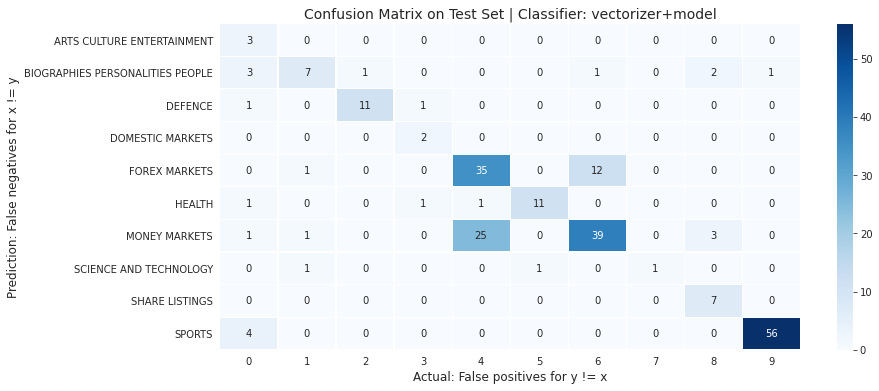

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_50
F1 score for  Pipeline  model is  0.6808757509384566
Accuracy score for  Pipeline  model is  0.7350427350427351
Recall score for  Pipeline  model is  0.765958552317248 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.23      1.00      0.38         3
           1       0.70      0.47      0.56        15
           2       0.92      0.85      0.88        13
           3       0.50      1.00      0.67         2
           4       0.57      0.73      0.64        48
           5       0.92      0.79      0.85        14
           6       0.75      0.57      0.64        69
           7     

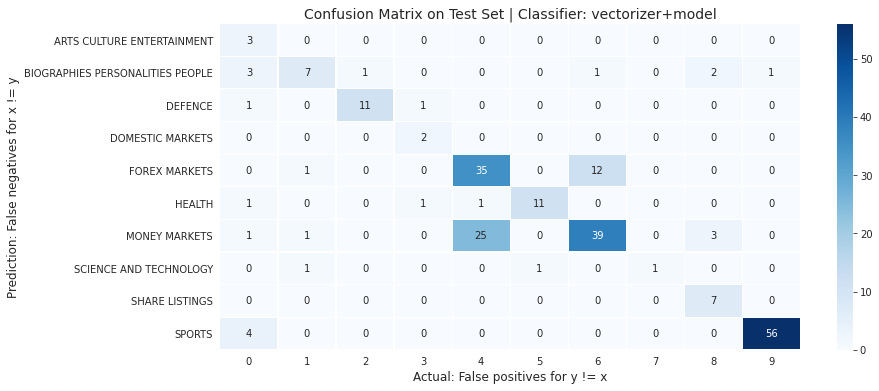

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_100
F1 score for  Pipeline  model is  0.6808757509384566
Accuracy score for  Pipeline  model is  0.7350427350427351
Recall score for  Pipeline  model is  0.765958552317248 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.23      1.00      0.38         3
           1       0.70      0.47      0.56        15
           2       0.92      0.85      0.88        13
           3       0.50      1.00      0.67         2
           4       0.57      0.73      0.64        48
           5       0.92      0.79      0.85        14
           6       0.75      0.57      0.64        69
           7    

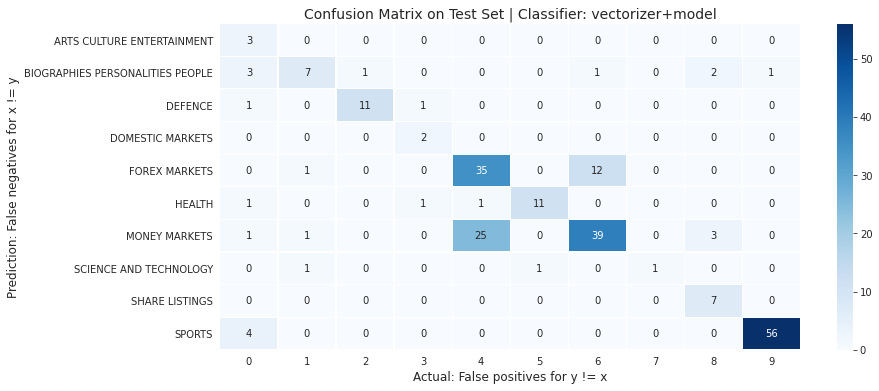

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_full
F1 score for  Pipeline  model is  0.6808757509384566
Accuracy score for  Pipeline  model is  0.7350427350427351
Recall score for  Pipeline  model is  0.765958552317248 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.23      1.00      0.38         3
           1       0.70      0.47      0.56        15
           2       0.92      0.85      0.88        13
           3       0.50      1.00      0.67         2
           4       0.57      0.73      0.64        48
           5       0.92      0.79      0.85        14
           6       0.75      0.57      0.64        69
           7   

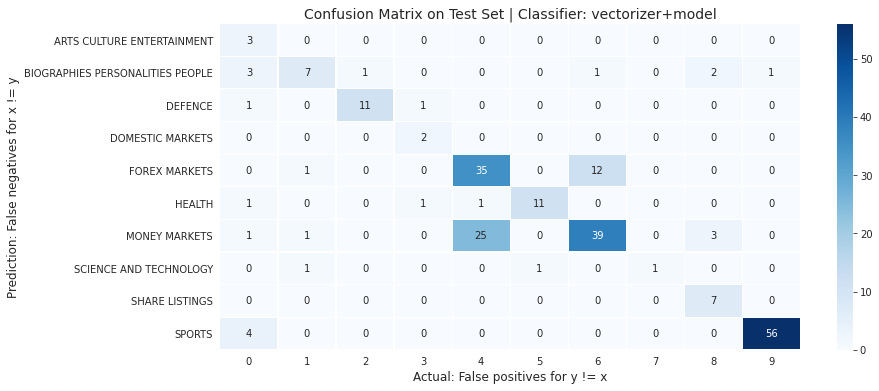

*************************************************************
Now the training set is df_train_20, and the model chosen is tfidf_clf_NB
The accuracy is 0.8002988643156007
----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_20
F1 score for  Pipeline  model is  0.7026514706830578
Accuracy score for  Pipeline  model is  0.7649572649572649
Recall score for  Pipeline  model is  0.778197961458831 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.27      1.00      0.43         3
           1       0.67      0.40      0.50        15
           2       0.86      0.92      0.89        13
           3       0.67      1.00      0.80         2
        

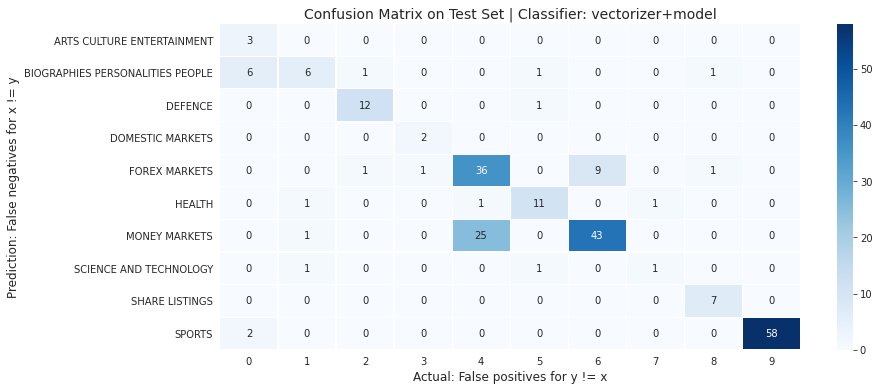

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_50
F1 score for  Pipeline  model is  0.7026514706830578
Accuracy score for  Pipeline  model is  0.7649572649572649
Recall score for  Pipeline  model is  0.778197961458831 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.27      1.00      0.43         3
           1       0.67      0.40      0.50        15
           2       0.86      0.92      0.89        13
           3       0.67      1.00      0.80         2
           4       0.58      0.75      0.65        48
           5       0.79      0.79      0.79        14
           6       0.83      0.62      0.71        69
           7     

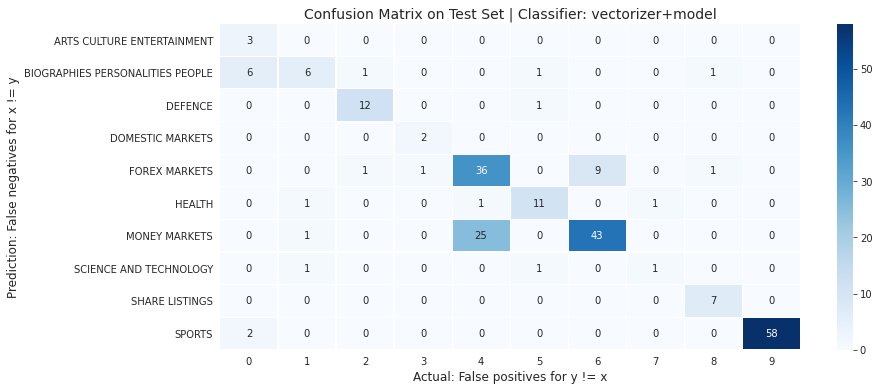

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_100
F1 score for  Pipeline  model is  0.7026514706830578
Accuracy score for  Pipeline  model is  0.7649572649572649
Recall score for  Pipeline  model is  0.778197961458831 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.27      1.00      0.43         3
           1       0.67      0.40      0.50        15
           2       0.86      0.92      0.89        13
           3       0.67      1.00      0.80         2
           4       0.58      0.75      0.65        48
           5       0.79      0.79      0.79        14
           6       0.83      0.62      0.71        69
           7    

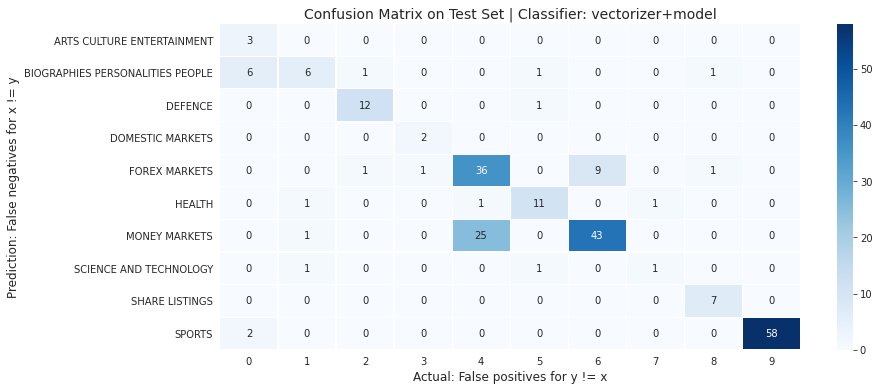

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_full
F1 score for  Pipeline  model is  0.7026514706830578
Accuracy score for  Pipeline  model is  0.7649572649572649
Recall score for  Pipeline  model is  0.778197961458831 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.27      1.00      0.43         3
           1       0.67      0.40      0.50        15
           2       0.86      0.92      0.89        13
           3       0.67      1.00      0.80         2
           4       0.58      0.75      0.65        48
           5       0.79      0.79      0.79        14
           6       0.83      0.62      0.71        69
           7   

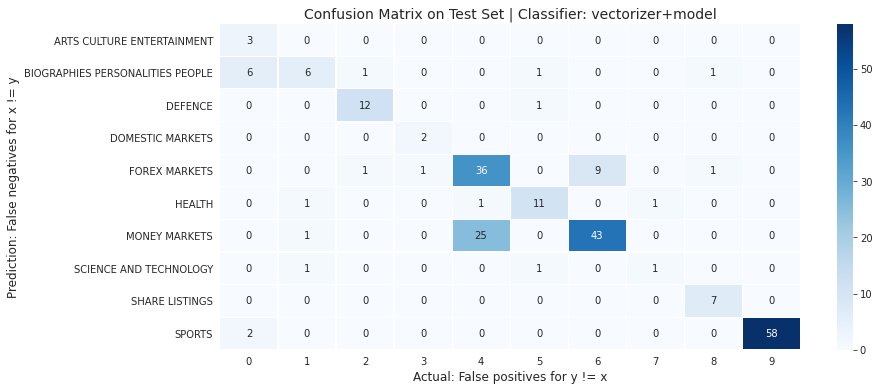

*************************************************************
Now the training set is df_train_50, and the model chosen is tfidf_clf_NB
The accuracy is 0.8441123729826658
----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_20
F1 score for  Pipeline  model is  0.7233162604387566
Accuracy score for  Pipeline  model is  0.7777777777777778
Recall score for  Pipeline  model is  0.7967849179805702 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         3
           1       0.73      0.53      0.62        15
           2       0.86      0.92      0.89        13
           3       0.67      1.00      0.80         2
       

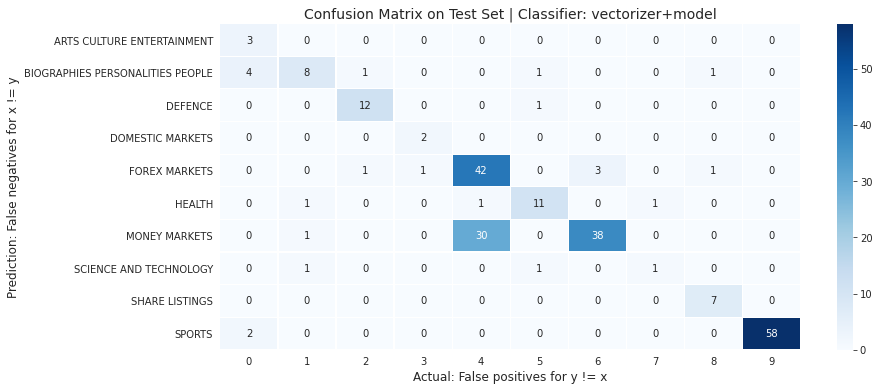

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_50
F1 score for  Pipeline  model is  0.7374343520640501
Accuracy score for  Pipeline  model is  0.7692307692307693
Recall score for  Pipeline  model is  0.8013087275043796 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       0.85      0.73      0.79        15
           2       0.92      0.92      0.92        13
           3       0.67      1.00      0.80         2
           4       0.54      0.79      0.64        48
           5       0.83      0.71      0.77        14
           6       0.83      0.55      0.66        69
           7    

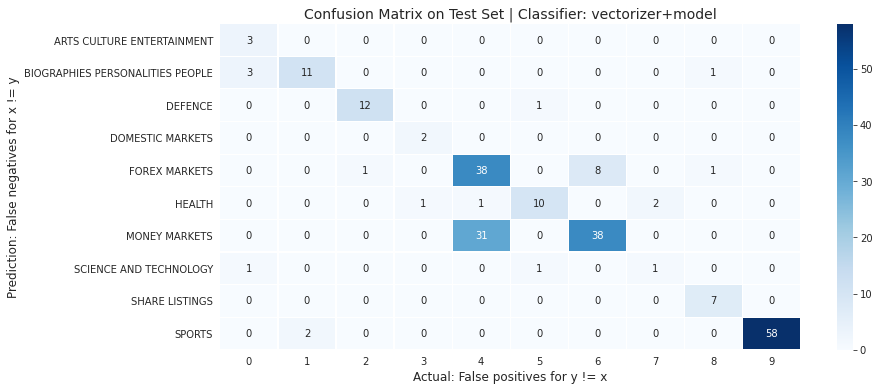

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_100
F1 score for  Pipeline  model is  0.7374343520640501
Accuracy score for  Pipeline  model is  0.7692307692307693
Recall score for  Pipeline  model is  0.8013087275043796 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       0.85      0.73      0.79        15
           2       0.92      0.92      0.92        13
           3       0.67      1.00      0.80         2
           4       0.54      0.79      0.64        48
           5       0.83      0.71      0.77        14
           6       0.83      0.55      0.66        69
           7   

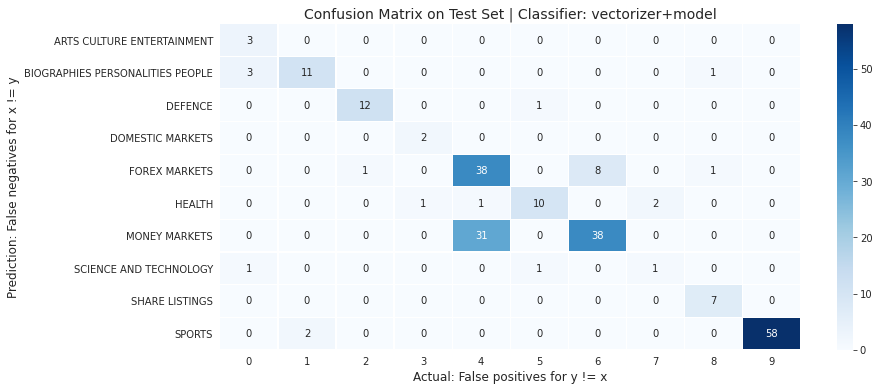

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_full
F1 score for  Pipeline  model is  0.7374343520640501
Accuracy score for  Pipeline  model is  0.7692307692307693
Recall score for  Pipeline  model is  0.8013087275043796 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       0.85      0.73      0.79        15
           2       0.92      0.92      0.92        13
           3       0.67      1.00      0.80         2
           4       0.54      0.79      0.64        48
           5       0.83      0.71      0.77        14
           6       0.83      0.55      0.66        69
           7  

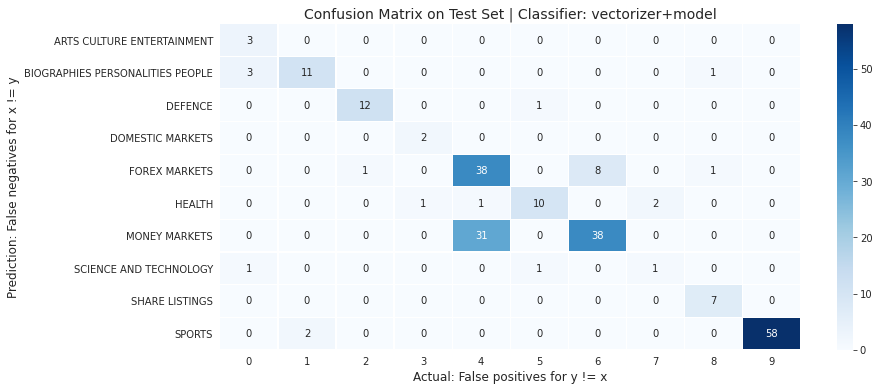

*************************************************************
Now the training set is df_train_100, and the model chosen is count_clf_NB
The accuracy is 0.8641362821279139
----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_20
F1 score for  Pipeline  model is  0.6891978134143489
Accuracy score for  Pipeline  model is  0.7521367521367521
Recall score for  Pipeline  model is  0.7775949593884377 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.70      0.47      0.56        15
           2       0.86      0.92      0.89        13
           3       0.50      1.00      0.67         2
     

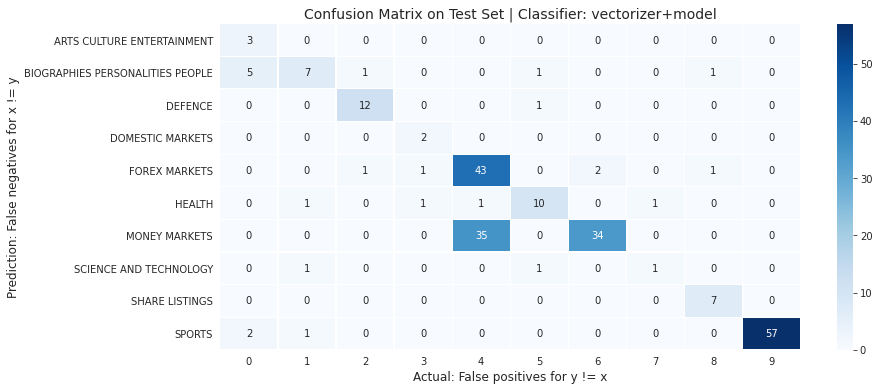

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_50
F1 score for  Pipeline  model is  0.7451631763989364
Accuracy score for  Pipeline  model is  0.7649572649572649
Recall score for  Pipeline  model is  0.8061870918936137 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       0.85      0.73      0.79        15
           2       0.92      0.92      0.92        13
           3       0.67      1.00      0.80         2
           4       0.53      0.81      0.64        48
           5       0.85      0.79      0.81        14
           6       0.83      0.51      0.63        69
           7   

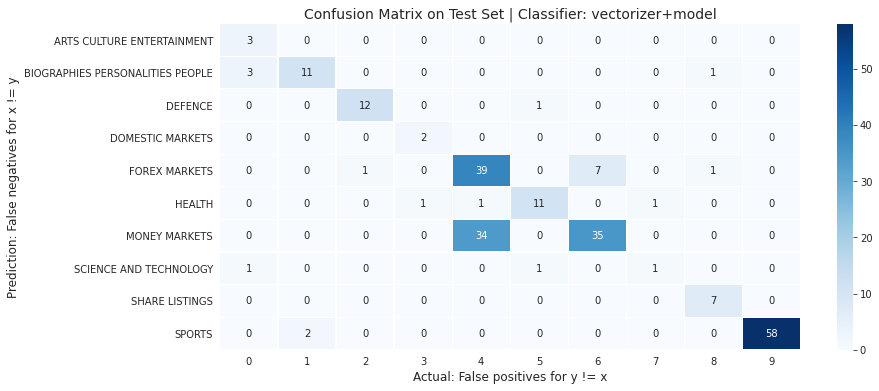

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_100
F1 score for  Pipeline  model is  0.7410018802873858
Accuracy score for  Pipeline  model is  0.782051282051282
Recall score for  Pipeline  model is  0.8067668020385412 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.38      1.00      0.55         3
           1       0.83      0.67      0.74        15
           2       0.86      0.92      0.89        13
           3       0.67      1.00      0.80         2
           4       0.57      0.81      0.67        48
           5       0.85      0.79      0.81        14
           6       0.85      0.58      0.69        69
           7   

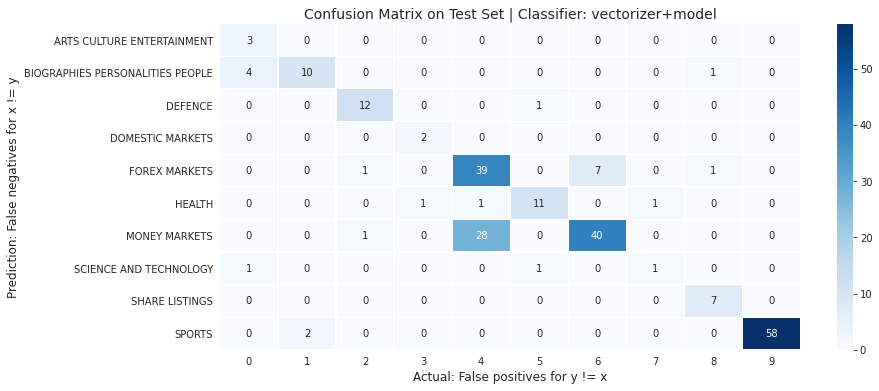

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_full
F1 score for  Pipeline  model is  0.7410018802873858
Accuracy score for  Pipeline  model is  0.782051282051282
Recall score for  Pipeline  model is  0.8067668020385412 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.38      1.00      0.55         3
           1       0.83      0.67      0.74        15
           2       0.86      0.92      0.89        13
           3       0.67      1.00      0.80         2
           4       0.57      0.81      0.67        48
           5       0.85      0.79      0.81        14
           6       0.85      0.58      0.69        69
           7  

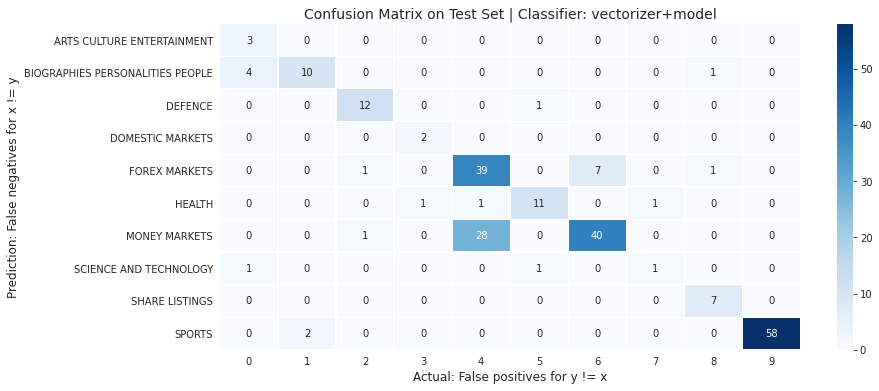

*************************************************************
Now the training set is df_train_full, and the model chosen is tfidf_clf_NB
The accuracy is 0.9365809922295277
----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_20
F1 score for  Pipeline  model is  0.6640148550302885
Accuracy score for  Pipeline  model is  0.7222222222222222
Recall score for  Pipeline  model is  0.740982640547858 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.67      0.33         3
           1       0.80      0.53      0.64        15
           2       0.75      0.92      0.83        13
           3       0.50      1.00      0.67         2
    

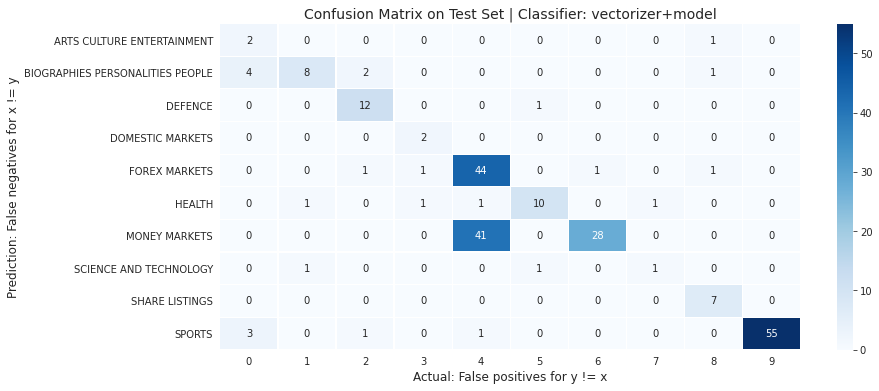

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_50
F1 score for  Pipeline  model is  0.7122247593469584
Accuracy score for  Pipeline  model is  0.7393162393162394
Recall score for  Pipeline  model is  0.7836819159101768 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       0.82      0.60      0.69        15
           2       0.80      0.92      0.86        13
           3       0.67      1.00      0.80         2
           4       0.51      0.90      0.65        48
           5       0.83      0.71      0.77        14
           6       0.91      0.42      0.57        69
           7  

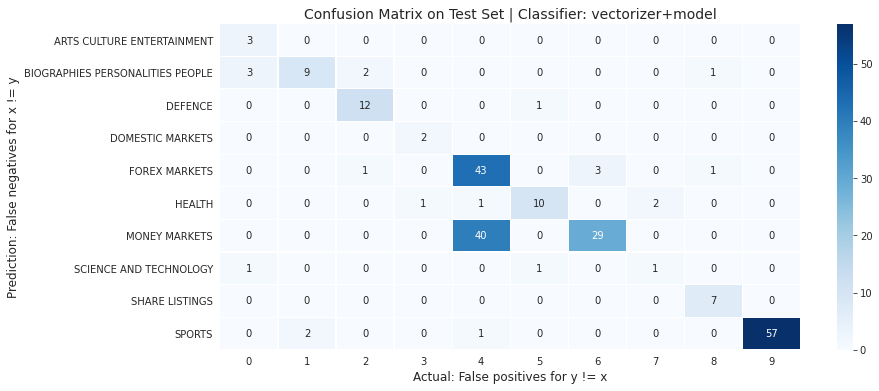

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_100
F1 score for  Pipeline  model is  0.6841924965744609
Accuracy score for  Pipeline  model is  0.7564102564102564
Recall score for  Pipeline  model is  0.7576544831979615 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.80      0.53      0.64        15
           2       0.80      0.92      0.86        13
           3       0.40      1.00      0.57         2
           4       0.55      0.88      0.67        48
           5       0.85      0.79      0.81        14
           6       0.89      0.49      0.64        69
           7 

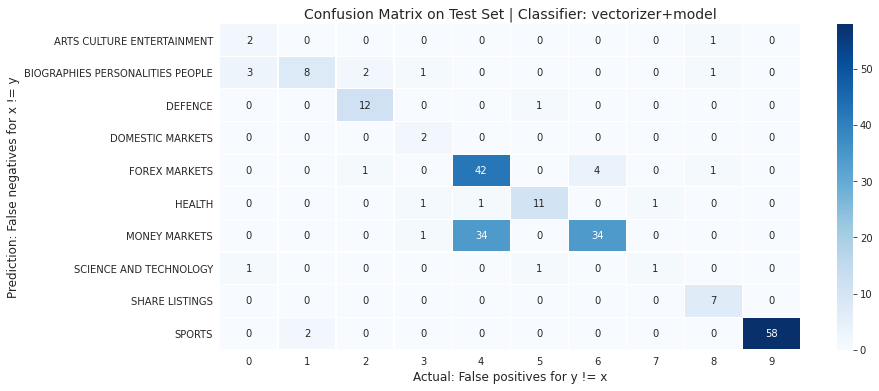

----------------------------------------------------------------------
Now, the train_df is df_train_full, the test_df is df_test_full
F1 score for  Pipeline  model is  0.7850120027492331
Accuracy score for  Pipeline  model is  0.7905982905982906
Recall score for  Pipeline  model is  0.8210274327122151 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'MONEY MARKETS': 6, 'SCIENCE AND TECHNOLOGY': 7, 'SHARE LISTINGS': 8, 'SPORTS': 9}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       0.90      0.60      0.72        15
           2       0.81      1.00      0.90        13
           3       1.00      1.00      1.00         2
           4       0.58      0.77      0.66        48
           5       0.93      0.93      0.93        14
           6       0.79      0.59      0.68        69
           7

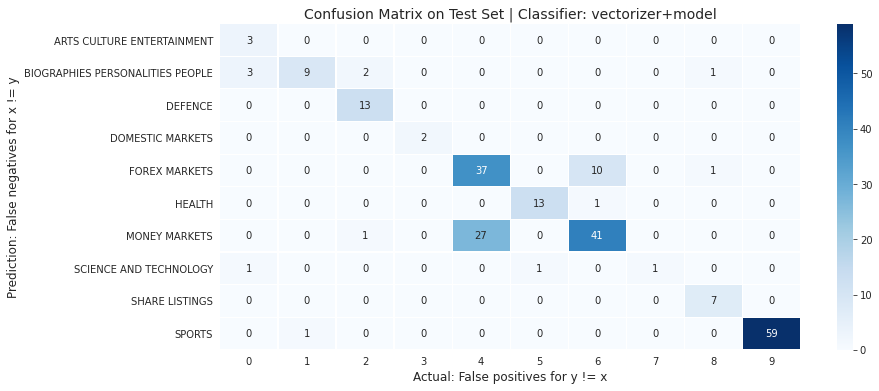

CPU times: user 1min 9s, sys: 3.86 s, total: 1min 12s
Wall time: 18min 16s


In [26]:
%%time
for train_df in df_train_all:
    clf_NB,le,encode_mapping = get_model_2(train_df)
    for test_df in df_test_all:
        if (test_df.isnull().values.any()):
            continue
        print('----------------------------------------------------------------------')
        print(f'Now, the train_df is {train_df.name}, the test_df is {test_df.name}')
        test_model(test_df,clf_NB,le,encode_mapping)

# Train Test Split on SMOTED Training Data

## SMOTE with Tfidf

In [5]:
TRAINING_FILE = "../keyword.csv"
TEST_FILE = "../key_word_test.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
print(df_train.isnull().sum())
df_train.head(5)

Unnamed: 0         0
article_number     0
article_words      0
topic              0
IR_binary          0
key_word_10       62
key_word_20       18
key_word_50        0
key_word_100       0
dtype: int64


Unnamed: 0  article_number  \
0           0               1   
1           1               2   
2           2               3   
3           3               4   
4           4               5   

                                       article_words          topic  \
0  open,absent,cent,cent,cent,stock,inflow,rate,k...  FOREX MARKETS   
1  morn,stead,end,end,day,day,day,patch,patch,pat...  MONEY MARKETS   
2  socc,socc,world,world,recent,law,fifa,fifa,fif...         SPORTS   
3  open,forint,forint,forint,forint,cent,cent,ste...  FOREX MARKETS   
4  morn,complet,weekend,minut,minut,minut,arrow,d...     IRRELEVANT   

   IR_binary                                        key_word_10  \
0      False  stock,rate,defend,bank,bank,bank,bank,bank,dol...   
1      False  day,day,day,bank,year,dollar,dollar,deal,deal,...   
2      False  world,world,stat,stat,stat,stat,year,releas,re...   
3      False  play,bank,bank,mark,mark,percent,percent,perce...   
4       True                                                day   

                                         key_word_20  \
0  cent,cent,cent,stock,rate,end,won,won,won,won,...   
1  end,end,day,day,day,point,time,bank,year,dolla...   
2  world,world,stat,stat,stat,stat,govern,time,ye...   
3  cent,cent,end,play,unit,bank,bank,mark,mark,pe...   
4                               day,time,season,clos   

                                         key_word_50  \
0  open,cent,cent,cent,stock,rate,end,won,won,won...   
1  end,end,day,day,day,point,time,bank,early,year...   
2  socc,socc,world,world,stat,stat,stat,stat,gove...   
3  open,cent,cent,end,play,unit,made,bank,bank,tu...   
4  minut,minut,minut,day,friday,friday,race,time,...   

                                        key_word_100  
0  open,cent,cent,cent,stock,rate,end,won,won,won...  
1  end,end,day,day,day,index,point,time,busi,bank...  
2  socc,socc,world,world,recent,law,stat,stat,sta...  
3  open,cent,cent,end,play,unit,made,bank,bank,ra...  
4  minut,minut,minut,day,friday,friday,race,time,...

In [6]:
# get train_x and train_y
new_df = shuffle(df_train,random_state=42).dropna().apply(lambda x: x.replace('_', ''))
train_x = new_df.article_words
train_y = new_df.topic
le = preprocessing.LabelEncoder()
le.fit(train_y)
encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
en_train_y = le.transform(train_y)
topics = list(set(new_df['topic']))
# Using SMOTE to solve imbalance
smote = SMOTE(random_state=1)
vectorizer = TfidfVectorizer()
vectorizer.fit(train_x)
train_vectors = vectorizer.transform(train_x)
smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
new_train_x = vectorizer.inverse_transform(smo_x)
new_train_x = pd.Series([','.join(item) for item in new_train_x])

In [7]:
train_x_10 = new_df.key_word_10
vectorizer.fit(train_x_10)
train_vectors_10 = vectorizer.transform(train_x_10)
smo_x_10,smo_y = smote.fit_sample(train_vectors_10,en_train_y)
new_train_x_10 = vectorizer.inverse_transform(smo_x_10)
new_train_x_10 = pd.Series([','.join(item) for item in new_train_x_10])

In [8]:
train_x_20 = new_df.key_word_20
vectorizer.fit(train_x_20)
train_vectors_20 = vectorizer.transform(train_x_20)
smo_x_20,smo_y = smote.fit_sample(train_vectors_20,en_train_y)
new_train_x_20 = vectorizer.inverse_transform(smo_x_20)
new_train_x_20 = pd.Series([','.join(item) for item in new_train_x_20])

In [9]:
train_x_50 = new_df.key_word_50
vectorizer.fit(train_x_50)
train_vectors_50 = vectorizer.transform(train_x_50)
smo_x_50,smo_y = smote.fit_sample(train_vectors_50,en_train_y)
new_train_x_50 = vectorizer.inverse_transform(smo_x_50)
new_train_x_50 = pd.Series([','.join(item) for item in new_train_x_50])

In [10]:
train_x_100 = new_df.key_word_100
vectorizer.fit(train_x_100)
train_vectors_100 = vectorizer.transform(train_x_100)
smo_x_100,smo_y = smote.fit_sample(train_vectors_100,en_train_y)
new_train_x_100 = vectorizer.inverse_transform(smo_x_100)
new_train_x_100 = pd.Series([','.join(item) for item in new_train_x_100])

In [11]:
train_x,valid_x,train_y,valid_y = train_test_split(new_train_x,smo_y,test_size=0.3,random_state=42)
valid_size = valid_x.shape[0]
train_x_10,valid_x_10,train_y,valid_y = train_test_split(new_train_x_10,smo_y,test_size=0.3,random_state=42)
train_x_20,valid_x_20,train_y,valid_y = train_test_split(new_train_x_20,smo_y,test_size=0.3,random_state=42)
train_x_50,valid_x_50,train_y,valid_y = train_test_split(new_train_x_50,smo_y,test_size=0.3,random_state=42)
train_x_100,valid_x_100,train_y,valid_y = train_test_split(new_train_x_100,smo_y,test_size=0.3,random_state=42)
print(valid_size)
print(valid_x_10.shape)

15504
(15504,)


First we build the model with train_x first

In [12]:
%%time
# Start grid search
count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                              train_x,train_y,topics)
tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                              train_x,train_y,topics)

CPU times: user 1min 17s, sys: 1min 10s, total: 2min 27s
Wall time: 1h 4min


In [13]:
clf_NB = None
if(count_clf_accuracy>=tfidf_clf_accuracy):
    print('count chosen')
    clf_NB = count_clf_NB
else:
    print('tfidf chosen')
    clf_NB = tfidf_clf_NB

tfidf chosen


In [14]:
def namestr(obj):
    return [name for name in globals() if globals()[name] is obj][0]

In [15]:
# reverse valid_y
rev_valid_y = le.inverse_transform(valid_y)

----------------------------------------------------------------------
Now,the test_df is valid_x_10
F1 score for  Pipeline  model is  0.6060058186436652
Accuracy score for  Pipeline  model is  0.6394478844169247
Recall score for  Pipeline  model is  0.642822930876334 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.48      0.60      1381
           1       0.75      0.30      0.43      1408
           2       0.73      0.85      0.78      1414
           3       0.62      0.97      0.76      1346
           4       0.57      0.30      0.39      1411
           5       0.65      0.77      0.70      1432
           6       0.17      0.05      0.08      1480
           7       0.46      

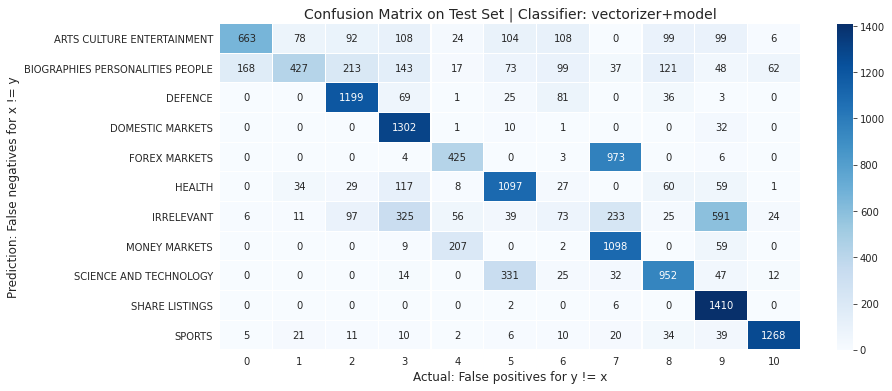

----------------------------------------------------------------------
Now,the test_df is valid_x_20
F1 score for  Pipeline  model is  0.6690282734882739
Accuracy score for  Pipeline  model is  0.6926599587203303
Recall score for  Pipeline  model is  0.6960156377166793 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.51      0.64      1381
           1       0.72      0.50      0.59      1408
           2       0.79      0.91      0.84      1414
           3       0.75      0.99      0.86      1346
           4       0.64      0.32      0.42      1411
           5       0.70      0.88      0.78      1432
           6       0.18      0.08      0.11      1480
           7       0.46     

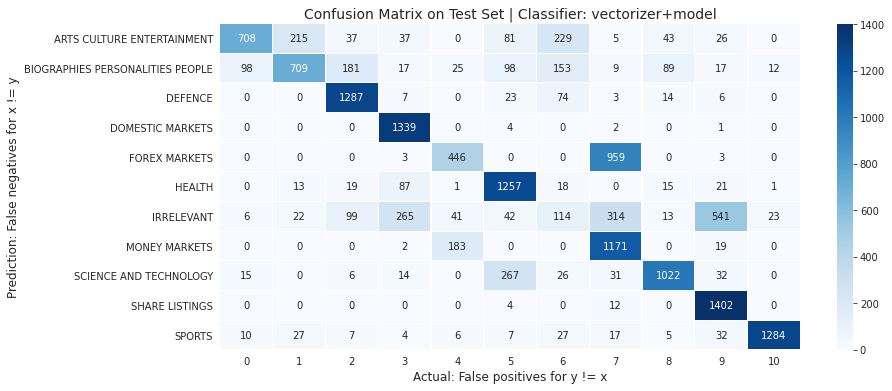

----------------------------------------------------------------------
Now,the test_df is valid_x_50
F1 score for  Pipeline  model is  0.7090315321806421
Accuracy score for  Pipeline  model is  0.7297471620227038
Recall score for  Pipeline  model is  0.7330162220650392 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1381
           1       0.79      0.58      0.67      1408
           2       0.73      0.94      0.82      1414
           3       0.83      0.99      0.90      1346
           4       0.65      0.30      0.41      1411
           5       0.79      0.94      0.86      1432
           6       0.26      0.12      0.16      1480
           7       0.47     

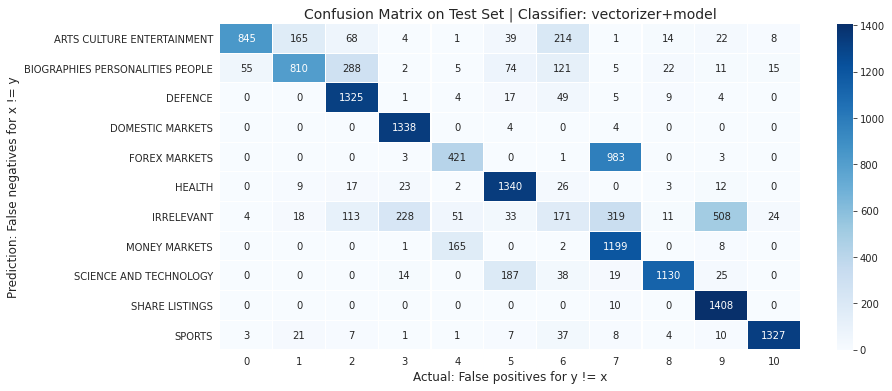

----------------------------------------------------------------------
Now,the test_df is valid_x_100
F1 score for  Pipeline  model is  0.768182732198574
Accuracy score for  Pipeline  model is  0.7816692466460269
Recall score for  Pipeline  model is  0.7847917024466192 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      1381
           1       0.85      0.74      0.79      1408
           2       0.81      0.93      0.86      1414
           3       0.87      1.00      0.93      1346
           4       0.69      0.34      0.45      1411
           5       0.85      0.94      0.89      1432
           6       0.45      0.22      0.30      1480
           7       0.49     

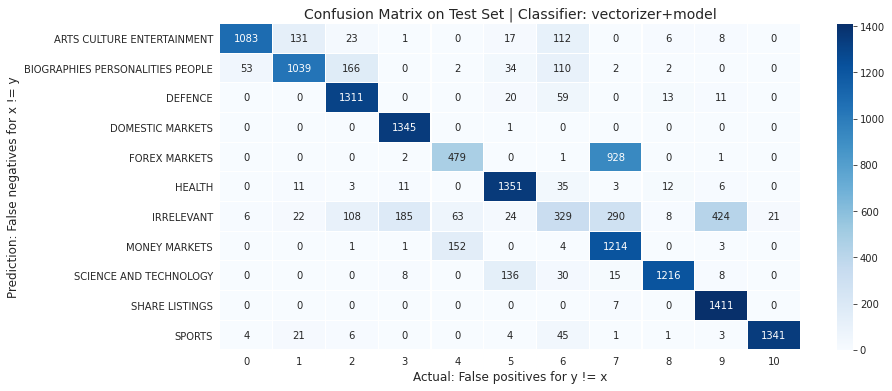

----------------------------------------------------------------------
Now,the test_df is valid_x
F1 score for  Pipeline  model is  0.9614464063257244
Accuracy score for  Pipeline  model is  0.9612358101135191
Recall score for  Pipeline  model is  0.9618060278223646 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1381
           1       0.99      1.00      1.00      1408
           2       0.99      1.00      1.00      1414
           3       0.99      1.00      1.00      1346
           4       0.90      0.81      0.85      1411
           5       1.00      1.00      1.00      1432
           6       0.99      0.84      0.91      1480
           7       0.77      0.

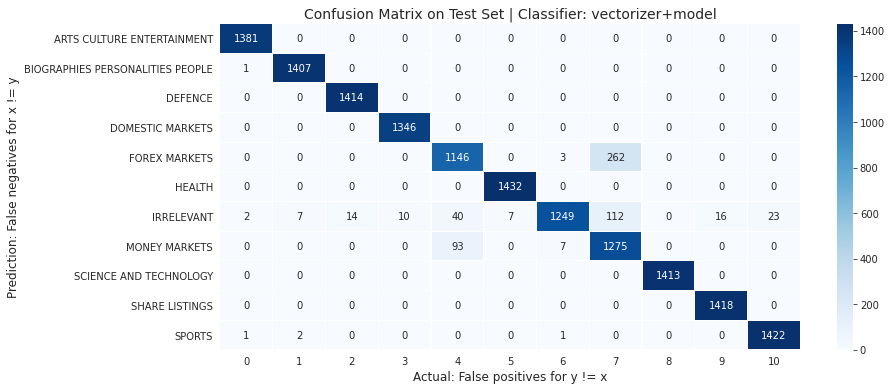

In [16]:
valid_set =[valid_x_10,valid_x_20,valid_x_50,valid_x_100,valid_x]
for ele in valid_set:
    print('----------------------------------------------------------------------')
    print(f'Now,the test_df is {namestr(ele)}') 
    df_valid = pd.DataFrame({'key_word':ele,'topic':rev_valid_y})
    test_model(df_valid,clf_NB,le,encode_mapping)

In [17]:
%%time
# Start grid search
count_clf_NB_100,count_clf_100_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                              train_x_100,train_y,topics)
tfidf_clf_NB_100,tfidf_clf_100_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                              train_x_100,train_y,topics)

CPU times: user 46.6 s, sys: 5.17 s, total: 51.7 s
Wall time: 21min 52s


tfidf chosen
----------------------------------------------------------------------
Now,the test_df is valid_x_10
F1 score for  Pipeline  model is  0.6864399599467194
Accuracy score for  Pipeline  model is  0.7054308565531475
Recall score for  Pipeline  model is  0.7079436010041952 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.62      0.68      1381
           1       0.67      0.49      0.57      1408
           2       0.79      0.89      0.84      1414
           3       0.75      0.95      0.84      1346
           4       0.62      0.73      0.67      1411
           5       0.67      0.84      0.74      1432
           6       0.32      0.13      0.18      1480
           7   

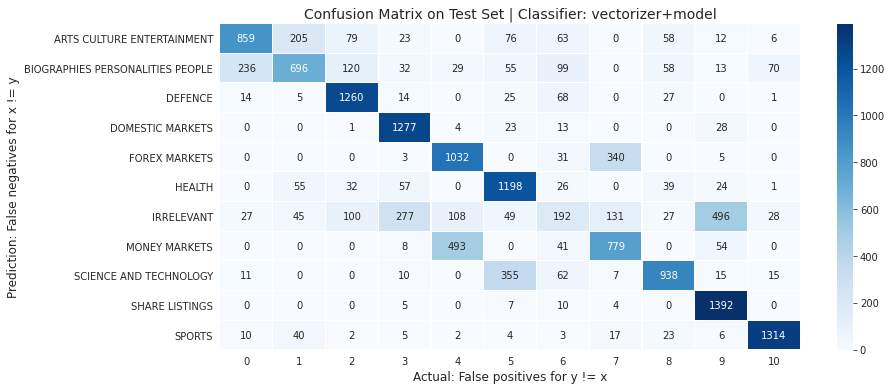

----------------------------------------------------------------------
Now,the test_df is valid_x_20
F1 score for  Pipeline  model is  0.7408080995788019
Accuracy score for  Pipeline  model is  0.7530959752321982
Recall score for  Pipeline  model is  0.7553985045818248 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73      1381
           1       0.70      0.68      0.69      1408
           2       0.83      0.94      0.88      1414
           3       0.82      0.95      0.88      1346
           4       0.65      0.70      0.67      1411
           5       0.71      0.91      0.79      1432
           6       0.45      0.21      0.29      1480
           7       0.61     

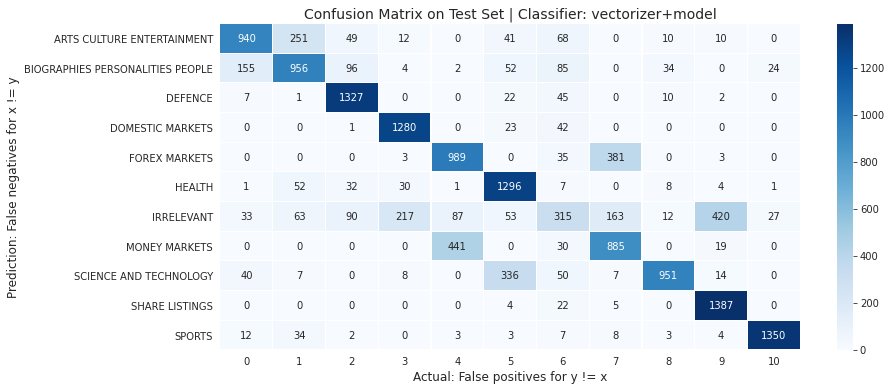

----------------------------------------------------------------------
Now,the test_df is valid_x_50
F1 score for  Pipeline  model is  0.7987624424198337
Accuracy score for  Pipeline  model is  0.8071465428276574
Recall score for  Pipeline  model is  0.80922575870362 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1381
           1       0.78      0.80      0.79      1408
           2       0.84      0.96      0.90      1414
           3       0.87      0.97      0.91      1346
           4       0.64      0.72      0.68      1411
           5       0.79      0.93      0.85      1432
           6       0.65      0.32      0.43      1480
           7       0.64      0

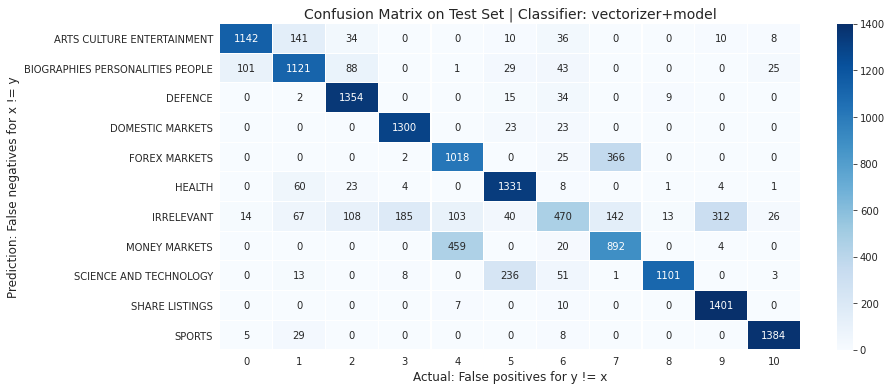

----------------------------------------------------------------------
Now,the test_df is valid_x_100
F1 score for  Pipeline  model is  0.832104107646368
Accuracy score for  Pipeline  model is  0.8360423116615067
Recall score for  Pipeline  model is  0.8377748099659977 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1381
           1       0.84      0.87      0.85      1408
           2       0.89      0.95      0.92      1414
           3       0.90      0.99      0.94      1346
           4       0.64      0.66      0.65      1411
           5       0.83      0.96      0.89      1432
           6       0.73      0.46      0.56      1480
           7       0.61     

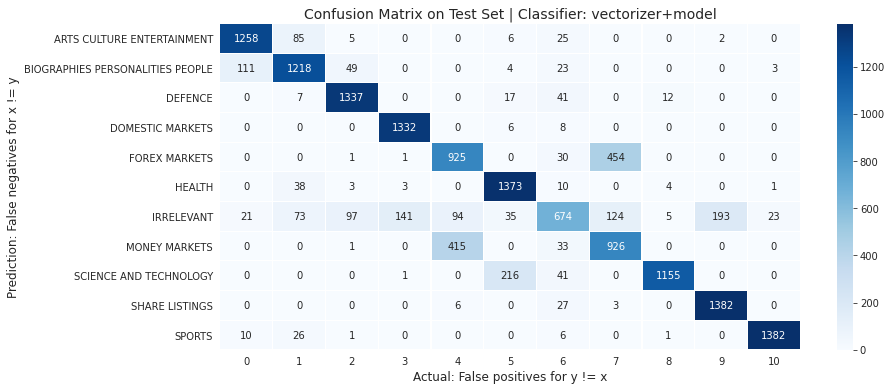

----------------------------------------------------------------------
Now,the test_df is valid_x
F1 score for  Pipeline  model is  0.833076656396831
Accuracy score for  Pipeline  model is  0.8369453044375645
Recall score for  Pipeline  model is  0.83869077560183 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1381
           1       0.83      0.87      0.85      1408
           2       0.91      0.96      0.93      1414
           3       0.90      0.99      0.94      1346
           4       0.64      0.66      0.65      1411
           5       0.84      0.95      0.89      1432
           6       0.74      0.46      0.56      1480
           7       0.62      0.67 

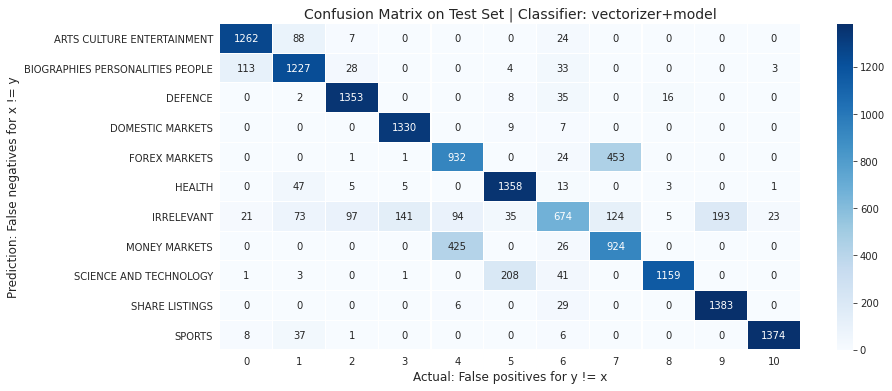

In [18]:
clf_NB_100 = None
if(count_clf_100_accuracy>=tfidf_clf_100_accuracy):
    print('count chosen')
    clf_NB_100 = count_clf_NB_100
else:
    print('tfidf chosen')
    clf_NB_100 = tfidf_clf_NB_100
rev_valid_y = le.inverse_transform(valid_y)
valid_set =[valid_x_10,valid_x_20,valid_x_50,valid_x_100,valid_x]
for ele in valid_set:
    print('----------------------------------------------------------------------')
    print(f'Now,the test_df is {namestr(ele)}') 
    df_valid = pd.DataFrame({'key_word':ele,'topic':rev_valid_y})
    test_model(df_valid,clf_NB_100,le,encode_mapping)

# SMOTE With CountVectorizer

In [19]:
TRAINING_FILE = "../keyword.csv"
TEST_FILE = "../key_word_test.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
print(df_train.isnull().sum())
df_train.head(5)

Unnamed: 0         0
article_number     0
article_words      0
topic              0
IR_binary          0
key_word_10       62
key_word_20       18
key_word_50        0
key_word_100       0
dtype: int64


Unnamed: 0  article_number  \
0           0               1   
1           1               2   
2           2               3   
3           3               4   
4           4               5   

                                       article_words          topic  \
0  open,absent,cent,cent,cent,stock,inflow,rate,k...  FOREX MARKETS   
1  morn,stead,end,end,day,day,day,patch,patch,pat...  MONEY MARKETS   
2  socc,socc,world,world,recent,law,fifa,fifa,fif...         SPORTS   
3  open,forint,forint,forint,forint,cent,cent,ste...  FOREX MARKETS   
4  morn,complet,weekend,minut,minut,minut,arrow,d...     IRRELEVANT   

   IR_binary                                        key_word_10  \
0      False  stock,rate,defend,bank,bank,bank,bank,bank,dol...   
1      False  day,day,day,bank,year,dollar,dollar,deal,deal,...   
2      False  world,world,stat,stat,stat,stat,year,releas,re...   
3      False  play,bank,bank,mark,mark,percent,percent,perce...   
4       True                                                day   

                                         key_word_20  \
0  cent,cent,cent,stock,rate,end,won,won,won,won,...   
1  end,end,day,day,day,point,time,bank,year,dolla...   
2  world,world,stat,stat,stat,stat,govern,time,ye...   
3  cent,cent,end,play,unit,bank,bank,mark,mark,pe...   
4                               day,time,season,clos   

                                         key_word_50  \
0  open,cent,cent,cent,stock,rate,end,won,won,won...   
1  end,end,day,day,day,point,time,bank,early,year...   
2  socc,socc,world,world,stat,stat,stat,stat,gove...   
3  open,cent,cent,end,play,unit,made,bank,bank,tu...   
4  minut,minut,minut,day,friday,friday,race,time,...   

                                        key_word_100  
0  open,cent,cent,cent,stock,rate,end,won,won,won...  
1  end,end,day,day,day,index,point,time,busi,bank...  
2  socc,socc,world,world,recent,law,stat,stat,sta...  
3  open,cent,cent,end,play,unit,made,bank,bank,ra...  
4  minut,minut,minut,day,friday,friday,race,time,...

In [20]:
# get train_x and train_y
new_df = shuffle(df_train,random_state=42).dropna().apply(lambda x: x.replace('_', ''))
train_x = new_df.article_words
train_y = new_df.topic
le = preprocessing.LabelEncoder()
le.fit(train_y)
encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
en_train_y = le.transform(train_y)
topics = list(set(new_df['topic']))
# Using SMOTE to solve imbalance
smote = SMOTE(random_state=1)
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
train_vectors = vectorizer.transform(train_x)
smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
new_train_x = vectorizer.inverse_transform(smo_x)
new_train_x = pd.Series([','.join(item) for item in new_train_x])
train_x_10 = new_df.key_word_10
vectorizer.fit(train_x_10)
train_vectors_10 = vectorizer.transform(train_x_10)
smo_x_10,smo_y = smote.fit_sample(train_vectors_10,en_train_y)
new_train_x_10 = vectorizer.inverse_transform(smo_x_10)
new_train_x_10 = pd.Series([','.join(item) for item in new_train_x_10])
train_x_20 = new_df.key_word_20
vectorizer.fit(train_x_20)
train_vectors_20 = vectorizer.transform(train_x_20)
smo_x_20,smo_y = smote.fit_sample(train_vectors_20,en_train_y)
new_train_x_20 = vectorizer.inverse_transform(smo_x_20)
new_train_x_20 = pd.Series([','.join(item) for item in new_train_x_20])
train_x_50 = new_df.key_word_50
vectorizer.fit(train_x_50)
train_vectors_50 = vectorizer.transform(train_x_50)
smo_x_50,smo_y = smote.fit_sample(train_vectors_50,en_train_y)
new_train_x_50 = vectorizer.inverse_transform(smo_x_50)
new_train_x_50 = pd.Series([','.join(item) for item in new_train_x_50])
train_x_100 = new_df.key_word_100
vectorizer.fit(train_x_100)
train_vectors_100 = vectorizer.transform(train_x_100)
smo_x_100,smo_y = smote.fit_sample(train_vectors_100,en_train_y)
new_train_x_100 = vectorizer.inverse_transform(smo_x_100)
new_train_x_100 = pd.Series([','.join(item) for item in new_train_x_100])
train_x,valid_x,train_y,valid_y = train_test_split(new_train_x,smo_y,test_size=0.3,random_state=42)
valid_size = valid_x.shape[0]
train_x_10,valid_x_10,train_y,valid_y = train_test_split(new_train_x_10,smo_y,test_size=0.3,random_state=42)
train_x_20,valid_x_20,train_y,valid_y = train_test_split(new_train_x_20,smo_y,test_size=0.3,random_state=42)
train_x_50,valid_x_50,train_y,valid_y = train_test_split(new_train_x_50,smo_y,test_size=0.3,random_state=42)
train_x_100,valid_x_100,train_y,valid_y = train_test_split(new_train_x_100,smo_y,test_size=0.3,random_state=42)
print(valid_size)
print(valid_x_10.shape)


15504
(15504,)


In [21]:
%%time
# Start grid search
count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                              train_x,train_y,topics)
tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                              train_x,train_y,topics)

CPU times: user 37.5 s, sys: 3.34 s, total: 40.8 s
Wall time: 15min 56s


In [22]:
clf_NB = None
if(count_clf_accuracy>=tfidf_clf_accuracy):
    print('count chosen')
    clf_NB = count_clf_NB
else:
    print('tfidf chosen')
    clf_NB = tfidf_clf_NB

tfidf chosen


----------------------------------------------------------------------
Now,the test_df is valid_x_10
F1 score for  Pipeline  model is  0.6182848214081008
Accuracy score for  Pipeline  model is  0.6611197110423117
Recall score for  Pipeline  model is  0.6635177618675048 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.39      0.51      1381
           1       0.61      0.50      0.55      1408
           2       0.66      0.88      0.75      1414
           3       0.54      0.97      0.69      1346
           4       0.55      0.95      0.70      1411
           5       0.69      0.72      0.71      1432
           6       0.91      0.01      0.01      1480
           7       0.79     

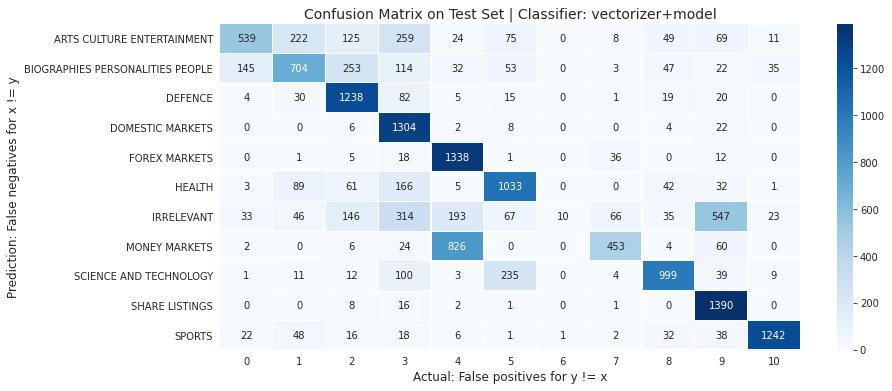

----------------------------------------------------------------------
Now,the test_df is valid_x_20
F1 score for  Pipeline  model is  0.6711941130314357
Accuracy score for  Pipeline  model is  0.7078173374613003
Recall score for  Pipeline  model is  0.7105199584304711 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.52      0.60      1381
           1       0.67      0.59      0.63      1408
           2       0.74      0.91      0.81      1414
           3       0.66      0.99      0.79      1346
           4       0.54      0.94      0.69      1411
           5       0.74      0.80      0.77      1432
           6       0.83      0.02      0.04      1480
           7       0.74     

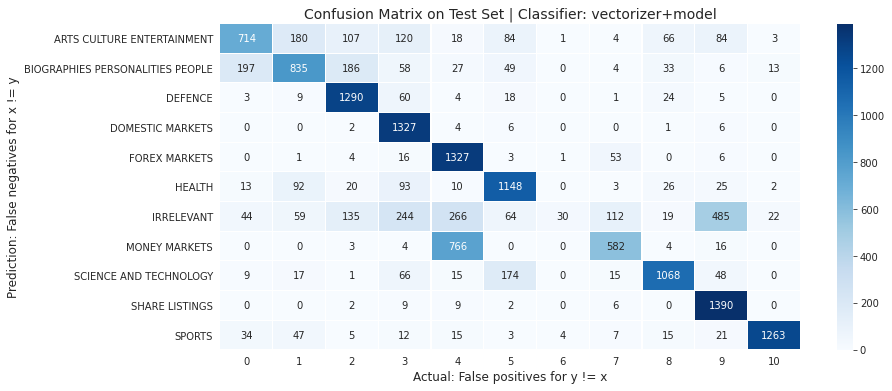

----------------------------------------------------------------------
Now,the test_df is valid_x_50
F1 score for  Pipeline  model is  0.7308612343385583
Accuracy score for  Pipeline  model is  0.7582559339525283
Recall score for  Pipeline  model is  0.7610655822537894 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.66      0.74      1381
           1       0.75      0.72      0.73      1408
           2       0.74      0.92      0.82      1414
           3       0.79      0.99      0.88      1346
           4       0.56      0.90      0.69      1411
           5       0.79      0.85      0.82      1432
           6       0.88      0.07      0.13      1480
           7       0.66     

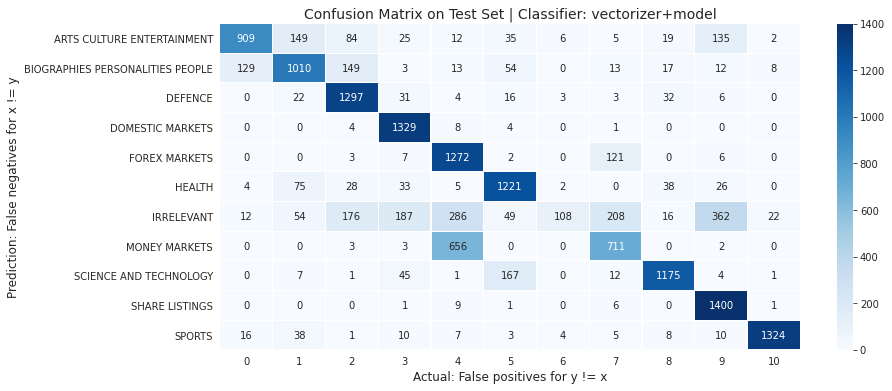

----------------------------------------------------------------------
Now,the test_df is valid_x_100
F1 score for  Pipeline  model is  0.7859317370418019
Accuracy score for  Pipeline  model is  0.7997291021671826
Recall score for  Pipeline  model is  0.8019479008067528 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.75      0.80      1381
           1       0.80      0.79      0.79      1408
           2       0.81      0.93      0.87      1414
           3       0.84      0.98      0.91      1346
           4       0.58      0.87      0.70      1411
           5       0.85      0.87      0.86      1432
           6       0.87      0.24      0.37      1480
           7       0.64    

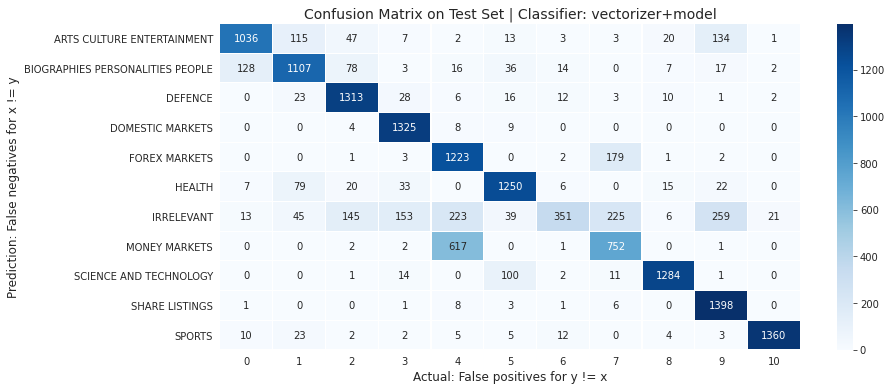

----------------------------------------------------------------------
Now,the test_df is valid_x
F1 score for  Pipeline  model is  0.9303539042327637
Accuracy score for  Pipeline  model is  0.9300825593395253
Recall score for  Pipeline  model is  0.930055853282677 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1381
           1       0.99      0.98      0.98      1408
           2       0.99      0.97      0.98      1414
           3       0.99      0.98      0.99      1346
           4       0.73      0.86      0.79      1411
           5       0.99      0.98      0.99      1432
           6       0.83      0.84      0.84      1480
           7       0.77      0.6

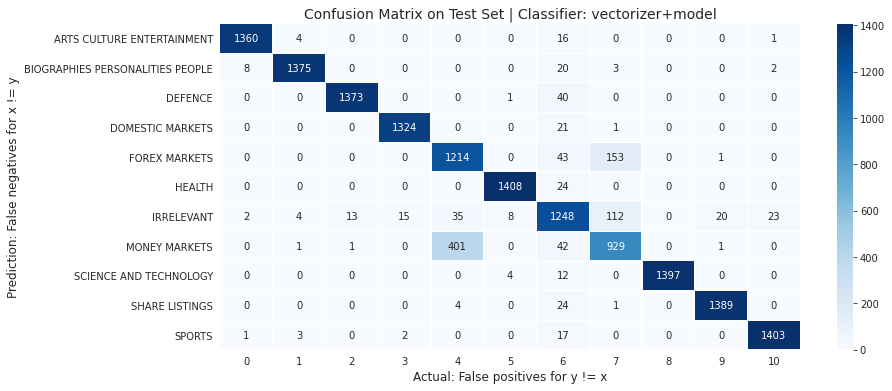

In [23]:
# reverse valid_y
rev_valid_y = le.inverse_transform(valid_y)
valid_set =[valid_x_10,valid_x_20,valid_x_50,valid_x_100,valid_x]
for ele in valid_set:
    print('----------------------------------------------------------------------')
    print(f'Now,the test_df is {namestr(ele)}') 
    df_valid = pd.DataFrame({'key_word':ele,'topic':rev_valid_y})
    test_model(df_valid,clf_NB,le,encode_mapping)